In [1]:
# if local use new_torch_env

import os

import numpy as np
import pandas as pd
# import seaborn as sns

from collections import Counter

import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from xml.etree import ElementTree, ElementInclude

import pickle
from functools import reduce

import iptcinfo3
from iptcinfo3 import IPTCInfo

import detectron2

from utills_output import *

# remember: 
All thresholds were set at 0.1 in prediction scripts.  

> cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold

If everything is over estimated, lower it. But this you can also do model specific! Seem like it is mostly ratinanet that overestimates.. Number, but on the flip side it is way better at rare objects! As should be expected.
- In theory you shoould be abel to just use the instance object and create a new output_list.pkl and all_img_feature_list wiht a lower threshold for "score"

# testing:

## Important to do:
- Also think about doing the last ratina net also 
- and maybe not including the fasterRCNN in rare cases (or some other rule)
    - Right now stuff gets fucked up when the Faster's esitmate only zeores..


- Ok... the "overestimation" due to threshold is kind of irretating now.. But how to decide on that abitrary number? 
    - actually - you do have the socers savd so you maybe you could just do asomething there?


# FULL
Todo:
- Make sure meta works here
- Explore...


# final:
The generation of the dfs should be in their own script. Not here.
Make both annotated_df and df as pickles.



# TWO MAIN ISSUES RIGHT NOW:
1) 0.1 threshold is too high for Retina. Can you fix it from you data or do you need to run new models?
2) What should be the critaria for including models for ensamble? Or should they be weigted?
(need to fix 1 beofre I can survey 2...)


In [2]:
## You should just load the dfs here.
# with open('spanner_annotated_df.pkl', 'wb') as file:
#     pickle.dump(annotated_df, file)

annotated_df = annotate_df()
annotated_df = meta_to_df(annotated_df)

annotated_df.sample(10)

Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_50_FPN_3x/output_list.pkl 
 features path: /home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_50_FPN_3x/all_img_feature_list.pkl 
Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_101_FPN_3x/output_list.pkl 
 features path: /home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_R_101_FPN_3x/all_img_feature_list.pkl 
Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_X_101_32x8d_FPN_3x/output_list.pkl 
 features path: /home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/faster_rcnn_X_101_32x8d_FPN_3x/all_img_feature_list.pkl 
Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/detectron_outputs_test/retinane

img_id  male_fasterR50  adult_fasterR50  female_fasterR50  \
529  JS31301               5                5                 1   
968  JS23911               3                2                 0   
448  JS36187               7                4                 0   
401  JS25519               2                1                 0   
420  JS76574               1                1                 0   
767  JS16121               4                4                 0   
385   JS8361               3                2                 0   
649  JS40184               4                5                 0   
709  JS17497               2                3                 0   
11   JS28407               1                1                 0   

     firearm_fasterR50  religiousGarmentFemale_fasterR50  uniformed_fasterR50  \
529                  0                                 0                    2   
968                  0                                 0                    0   
448                  2                                 0                    0   
401                  0                                 0                    0   
420                  1                                 0                    0   
767                  0                                 0                    0   
385                  0                                 0                    0   
649                  0                                 0                    0   
709                  0                                 0                    0   
11                   0                                 0                    0   

     falgIRQ_fasterR50  flagUS_fasterR50  person_fasterR50  ...  \
529                  0                 3                 6  ...   
968                  0                 0                 5  ...   
448                  0                 0                 8  ...   
401                  0                 1                 2  ...   
420                  0                 1                 1  ...   
767                  1                 2                 4  ...   
385                  0                 0                 3  ...   
649                  0                 0                 4  ...   
709                  0                 0                 3  ...   
11                   0                 0                 1  ...   

                                              headline  \
529                 \rOngoing operations in Mosul area   
968                                                NaN   
448         U.S. Ambassador  to Iraq Zalmay Khalilzad    
401                                                NaN   
420                                                NaN   
767  Iraqis demonstrate on the second anniversary o...   
385                                                NaN   
649                                                NaN   
709                                                NaN   
11                                                 NaN   

                             credit                          source  \
529                         Polaris                             NaN   
968                             NaN                             NaN   
448                  Polaris Images                             NaN   
401                             NaN                             NaN   
420                             NaN                             NaN   
767                  Polaris Images                             NaN   
385  Johan Spanner/WorldPictureNews  Johan Spanner/WorldPictureNews   
649                             NaN                             NaN   
709                             NaN                             NaN   
11                              NaN                             NaN   

                   copyright notice  \
529    Johan Spanner/Polaris Images   
968                             NaN   
448                             NaN   
401                             NaN   
420                   

In [3]:
np.corrcoef(annotated_df['person_fasterR50'], annotated_df['person_annotated'])

array([[1.       , 0.7905977],
       [0.7905977, 1.       ]])

In [ ]:
# Plotting

plot_corr(annotated_df)
plot_corr(annotated_df, 'train')
plot_corr(annotated_df, 'test')

feature_version_list = ['annotated', 'mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50']
for i in feature_version_list:
    feature_dist_plots(annotated_df, i)

# Annotated, alt threshold (0.3):

In [4]:
# try w/ alt threshold:
annotated_df_t30 = annotate_df(alt_threshold= True)
annotated_df_t30 = meta_to_df(annotated_df_t30)

annotated_df_t30.sample(10)

Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/alt_threshold_outputs/faster_rcnn_R_50_FPN_3x/output_list_t30.pkl 
 features path: /home/simon/Documents/Bodies/data/computerome_outputs/alt_threshold_outputs/faster_rcnn_R_50_FPN_3x/all_img_feature_list_t30.pkl 
Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/alt_threshold_outputs/faster_rcnn_R_101_FPN_3x/output_list_t30.pkl 
 features path: /home/simon/Documents/Bodies/data/computerome_outputs/alt_threshold_outputs/faster_rcnn_R_101_FPN_3x/all_img_feature_list_t30.pkl 
Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/alt_threshold_outputs/faster_rcnn_X_101_32x8d_FPN_3x/output_list_t30.pkl 
 features path: /home/simon/Documents/Bodies/data/computerome_outputs/alt_threshold_outputs/faster_rcnn_X_101_32x8d_FPN_3x/all_img_feature_list_t30.pkl 
Files exists:
 Outputs path: /home/simon/Documents/Bodies/data/computerome_outputs/alt_threshold

img_id  male_fasterR50  adult_fasterR50  female_fasterR50  \
727  JS18531               6                4                 0   
632  JS54950               1                1                 0   
958  JS28898               3                1                 0   
682  JS22566               0                0                 0   
619  JS30469               3                3                 0   
57    JS7254               9                8                 0   
260   JS5416               0                0                 0   
80   JS23889               1                1                 0   
628  JS37747               5                4                 0   
50   JS26969              13                8                 0   

     firearm_fasterR50  religiousGarmentFemale_fasterR50  uniformed_fasterR50  \
727                  0                                 0                    0   
632                  0                                 0                    0   
958                  0                                 0                    2   
682                  0                                 0                    0   
619                  0                                 0                    0   
57                   0                                 0                    1   
260                  0                                 0                    0   
80                   9                                 0                    3   
628                  0                                 0                    2   
50                   1                                 0                    1   

     falgIRQ_fasterR50  flagUS_fasterR50  person_fasterR50  ...  headline  \
727                  0                 0                 6  ...       NaN   
632                  0                 0                 1  ...       NaN   
958                  0                 0                 4  ...       NaN   
682                  0                 0                 0  ...       NaN   
619                  0                 1                 3  ...       NaN   
57                   0                 0                 9  ...       NaN   
260                  0                 0                 0  ...       NaN   
80                   0                 0                 1  ...       NaN   
628                  0                 5                 7  ...       NaN   
50                   1                 0                11  ...       NaN   

     credit  source  copyright notice  caption/abstract  writer/editor  \
727     NaN     NaN               NaN               NaN            NaN   
632     NaN     NaN               NaN               NaN            NaN   
958     NaN     NaN               NaN               NaN            NaN   
682     NaN     NaN               NaN               NaN            NaN   
619     NaN     NaN               NaN               NaN            NaN   
57      NaN     NaN               NaN               NaN            NaN   
260     NaN     NaN               NaN               NaN            NaN   
80      NaN     NaN               NaN               NaN            NaN   
628     NaN     NaN               NaN               NaN            NaN   
50      NaN     NaN               NaN               NaN            NaN   

     custom1  custom2  custom3                     custom4  
727  Spanner      Raw     2005                DSC_3835.JPG  
632  Spanner      Raw     2005                DSC_6237.JPG  
958  Spanner      Raw     2005                DSC_5702.JPG  
682  Spanner      Raw     2005  LX-2005-05-28-000-0198.JPG  
619  Spanner      Raw     2005                DSC_7113.JPG  
57   Spanner      Raw     2003                DSC_0245.TIF  
260  Spanner      Raw     2003                DSC_1814.TIF  
80   Spanner      Raw     2005                DSC_1226.JPG  
628  Spanner      Raw     2005                DSC_3231.JPG  
50   Spanner      Raw     2005                DSC_3811.JPG  

[10 rows x 132 columns]

In [5]:
# See - this should be the same as the above... (since a sat threshold at 0...)
np.corrcoef(annotated_df_t30['person_fasterR50'], annotated_df_t30['person_annotated'])

array([[ 1.        , -0.00892509],
       [-0.00892509,  1.        ]])

In [5]:
annotated_df_t30['firearm_fasterR50'].sum()

489

In [4]:
annotated_df_t30['firearm_fasterR50'].sum()

187

plotting casualty: both. Dim: (1007, 132)


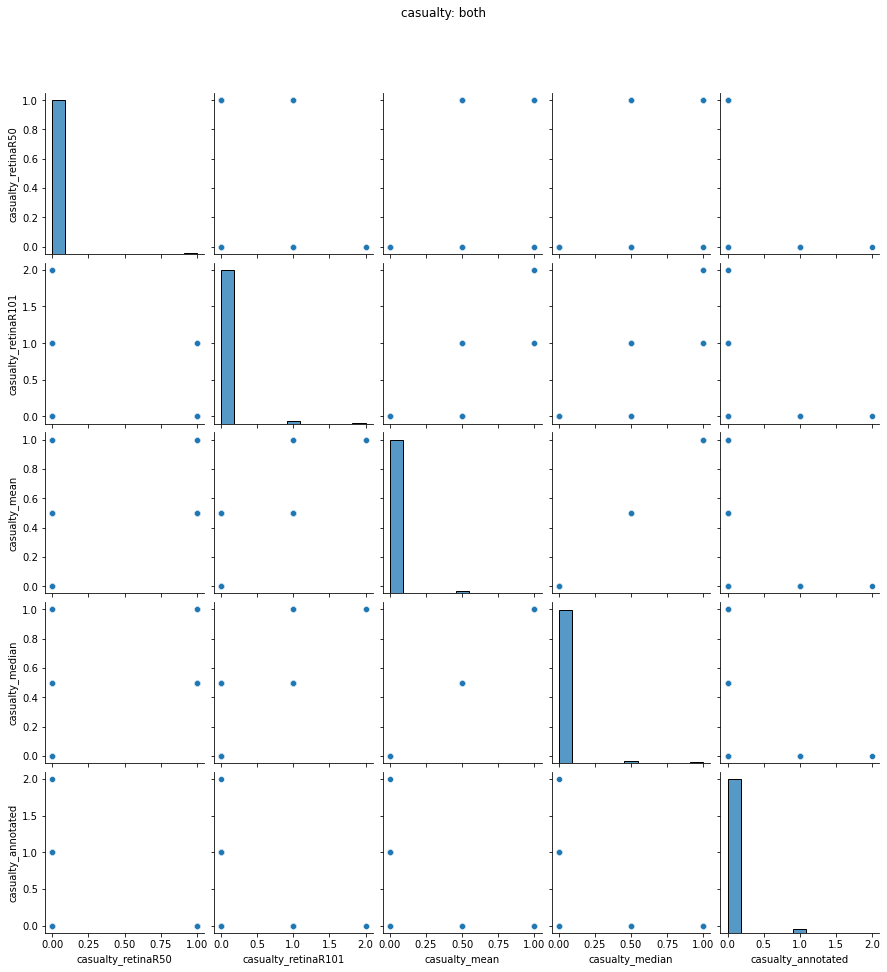

plotting flagUS: both. Dim: (1007, 132)


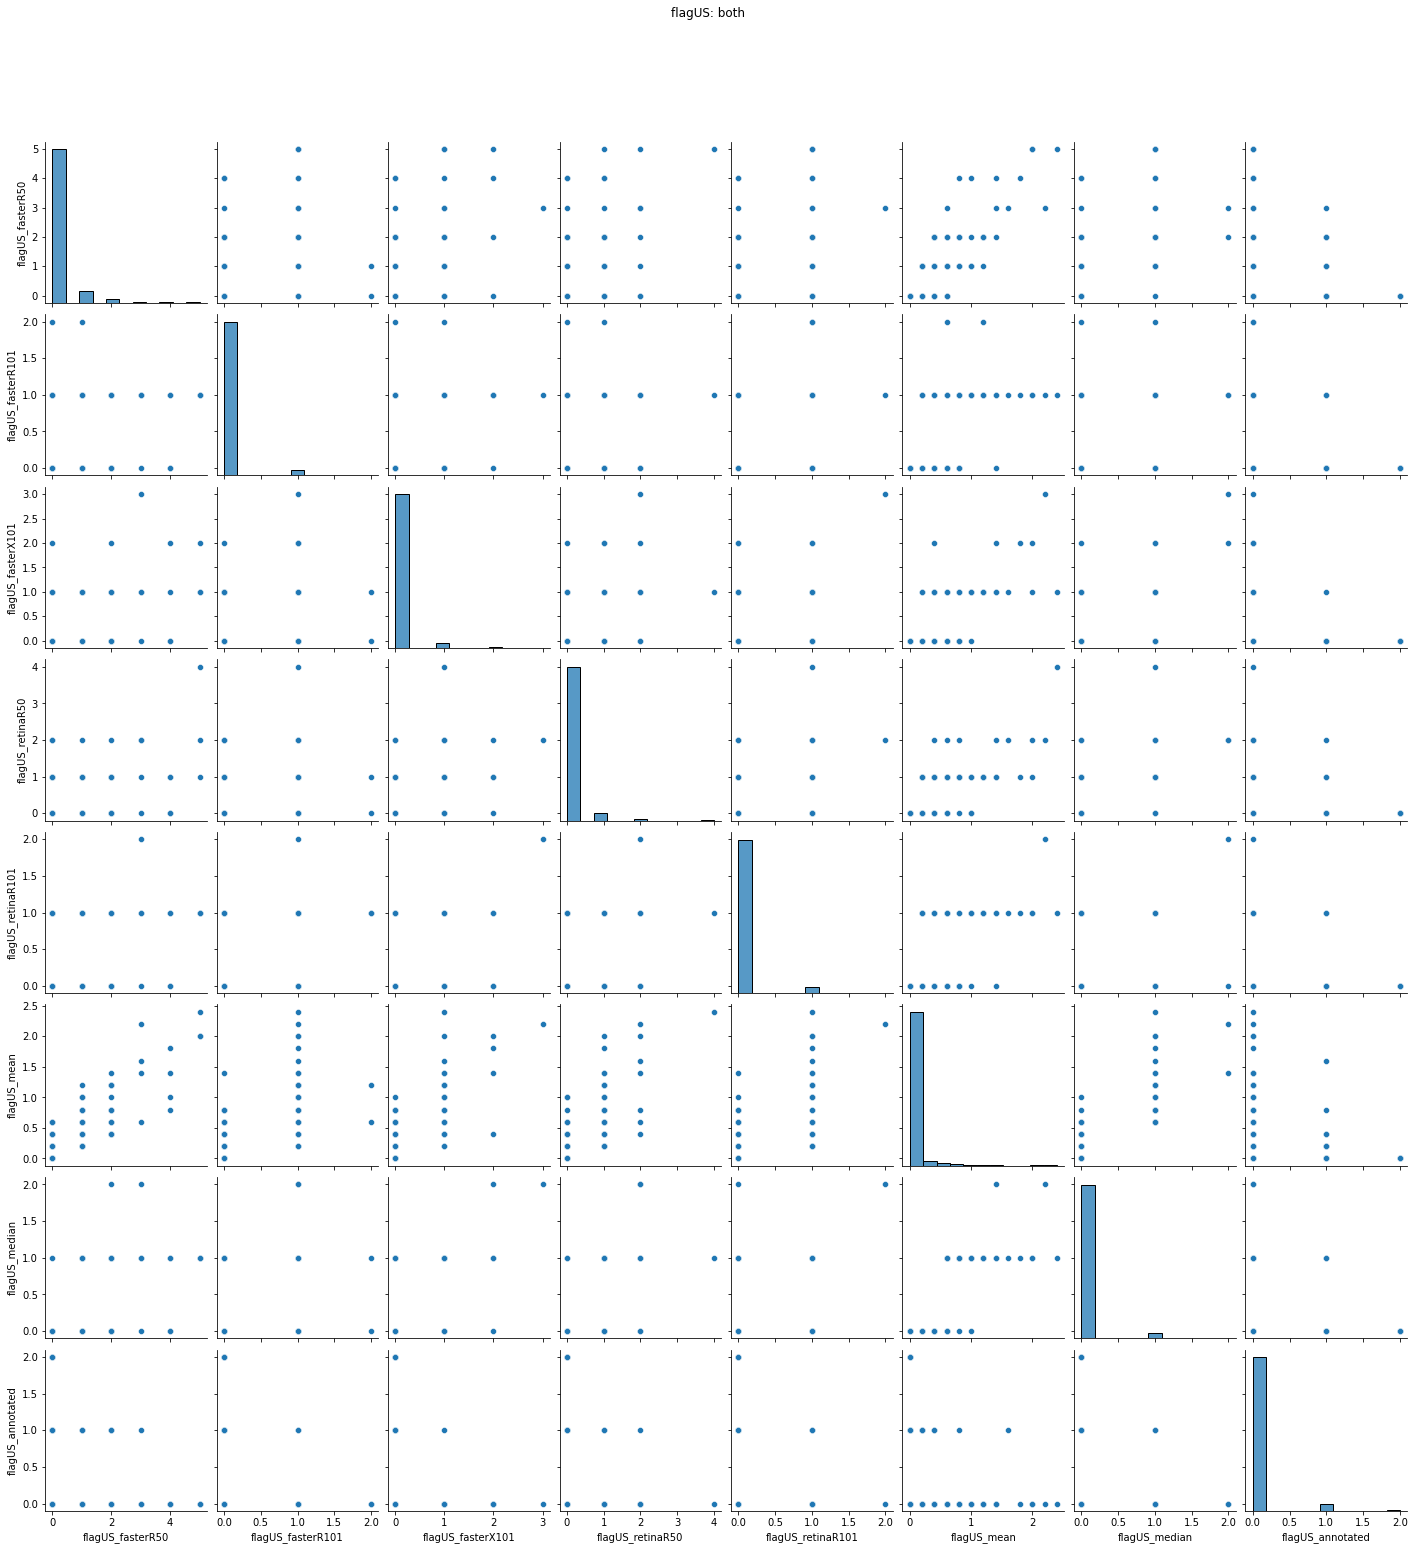

plotting youth: both. Dim: (1007, 132)


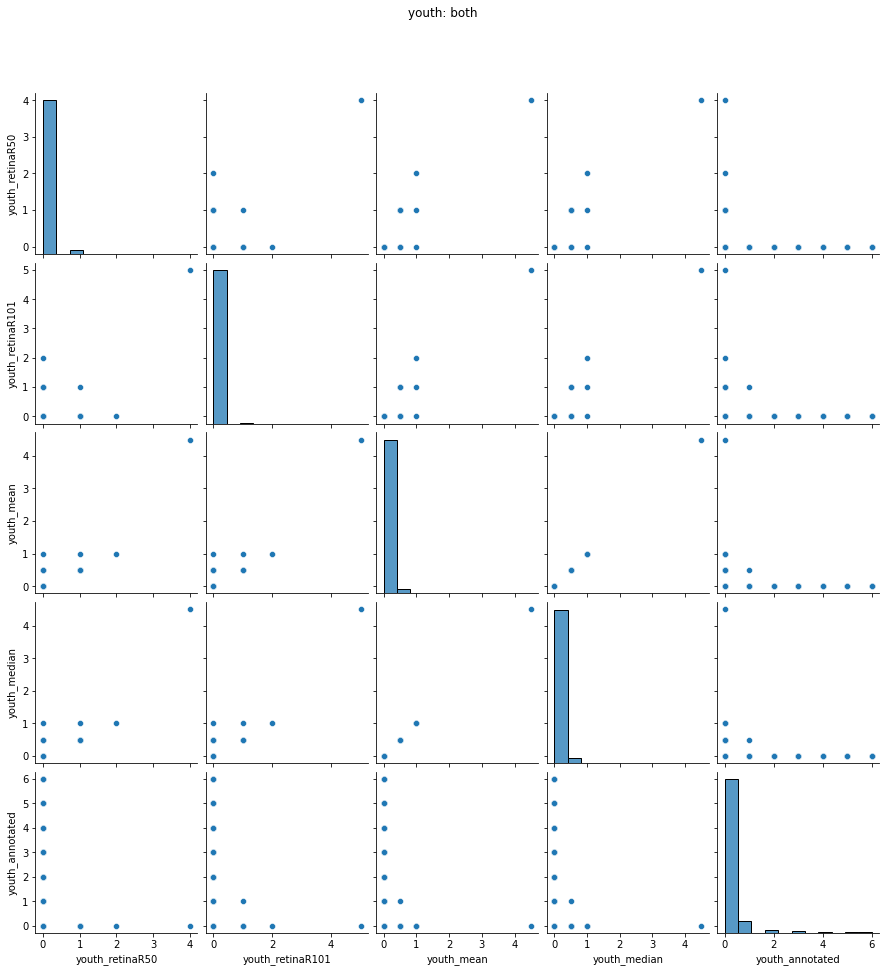

plotting elderly: both. Dim: (1007, 132)


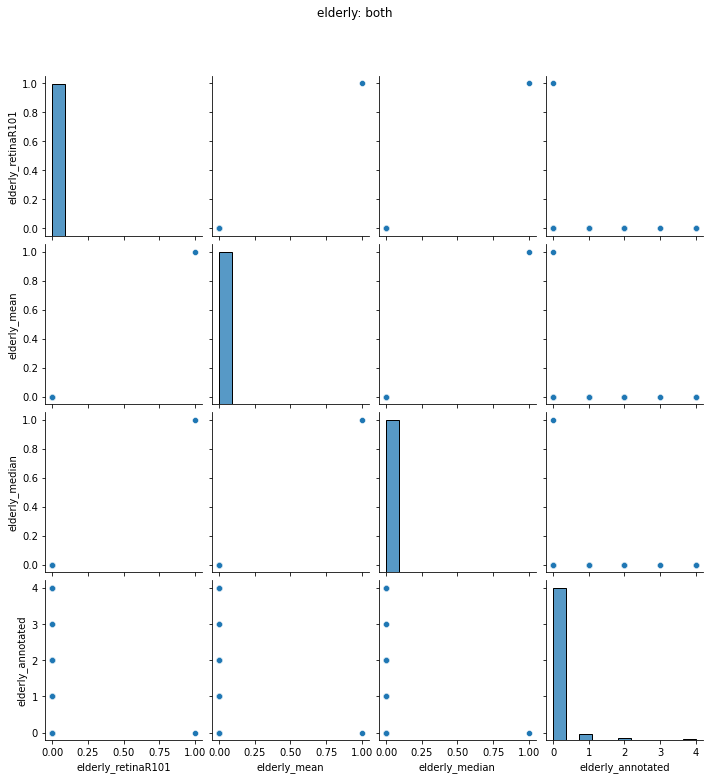

plotting child: both. Dim: (1007, 132)


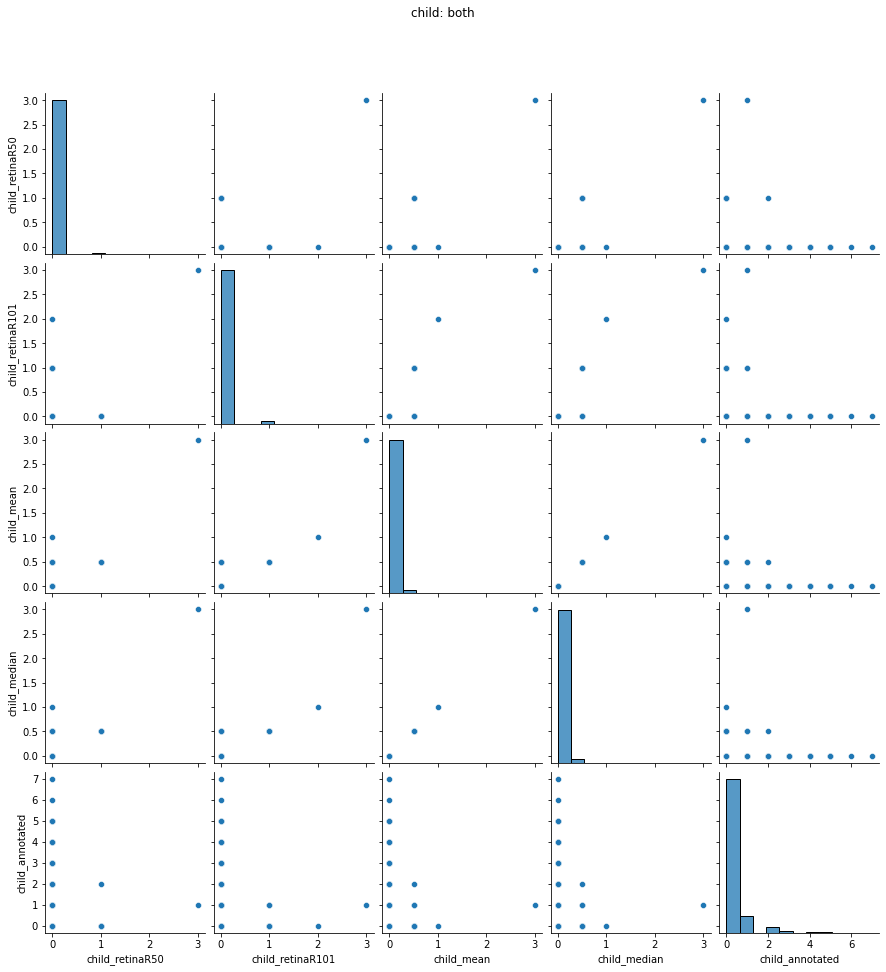

plotting person: both. Dim: (1007, 132)


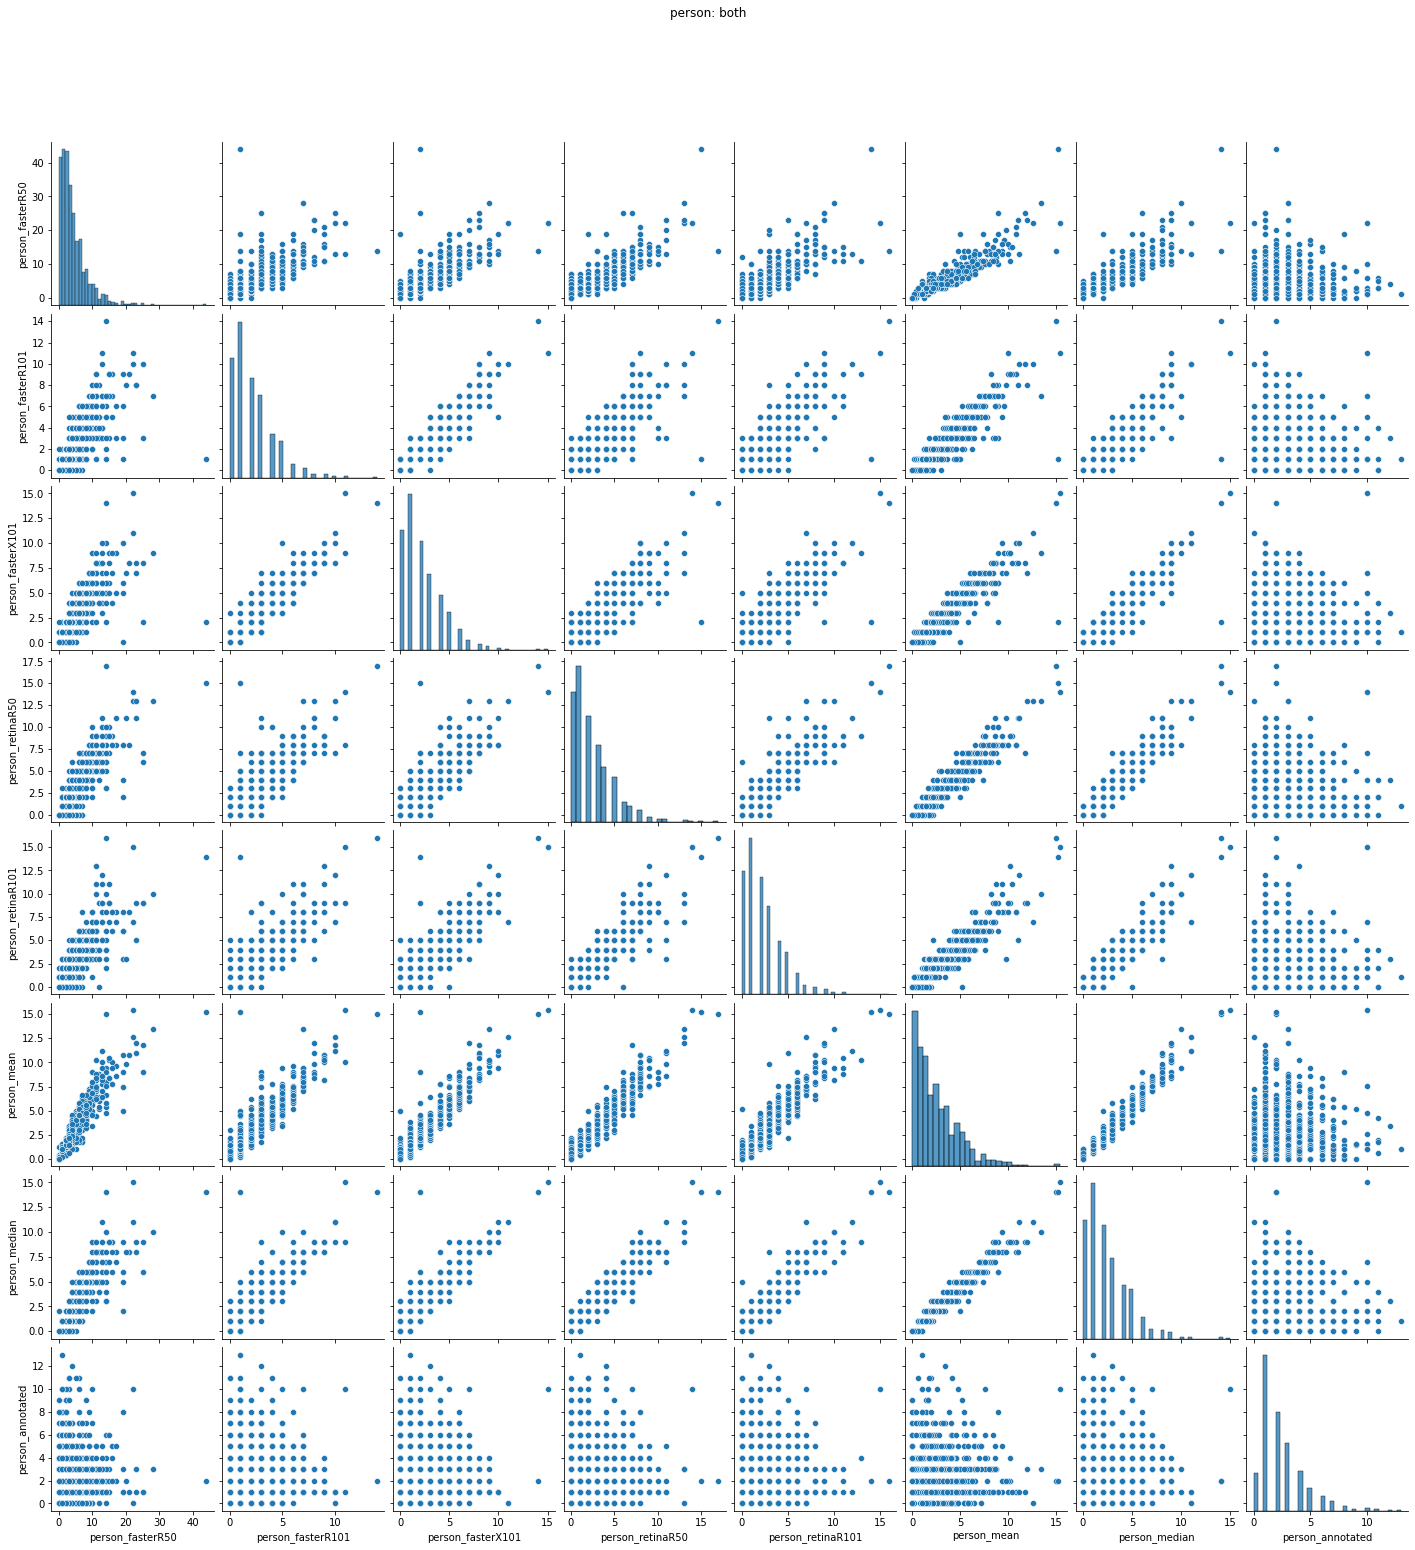

plotting hostage: both. Dim: (1007, 132)


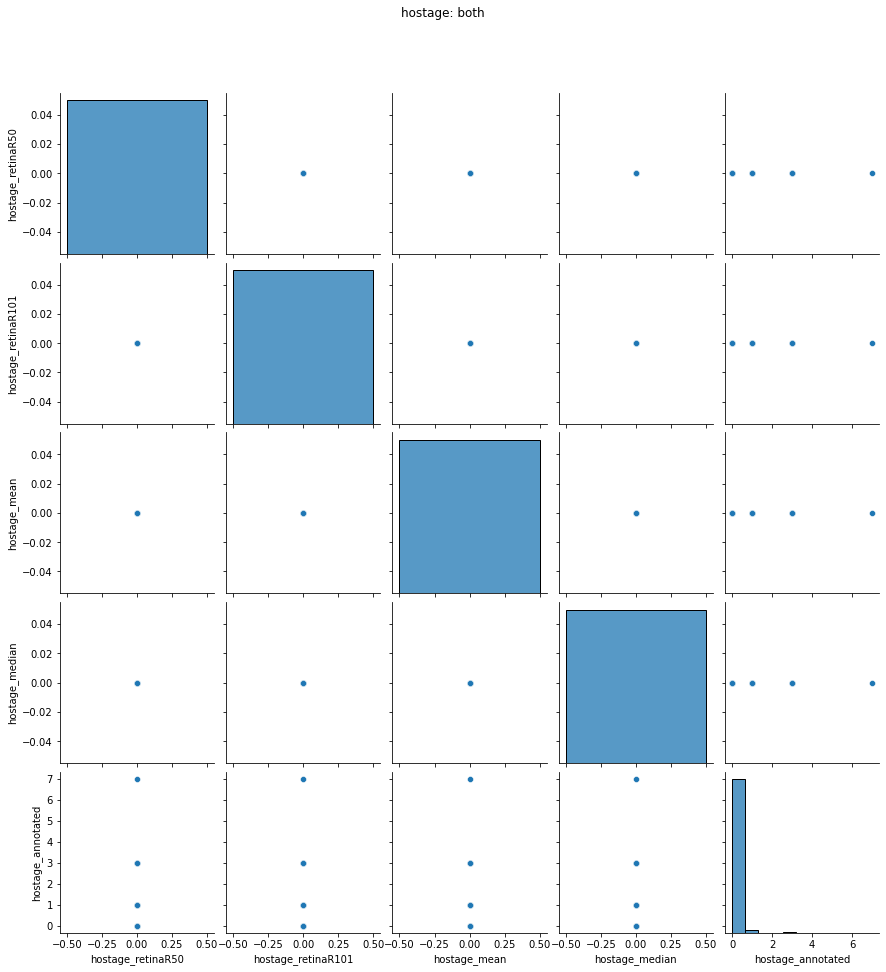

plotting adult: both. Dim: (1007, 132)


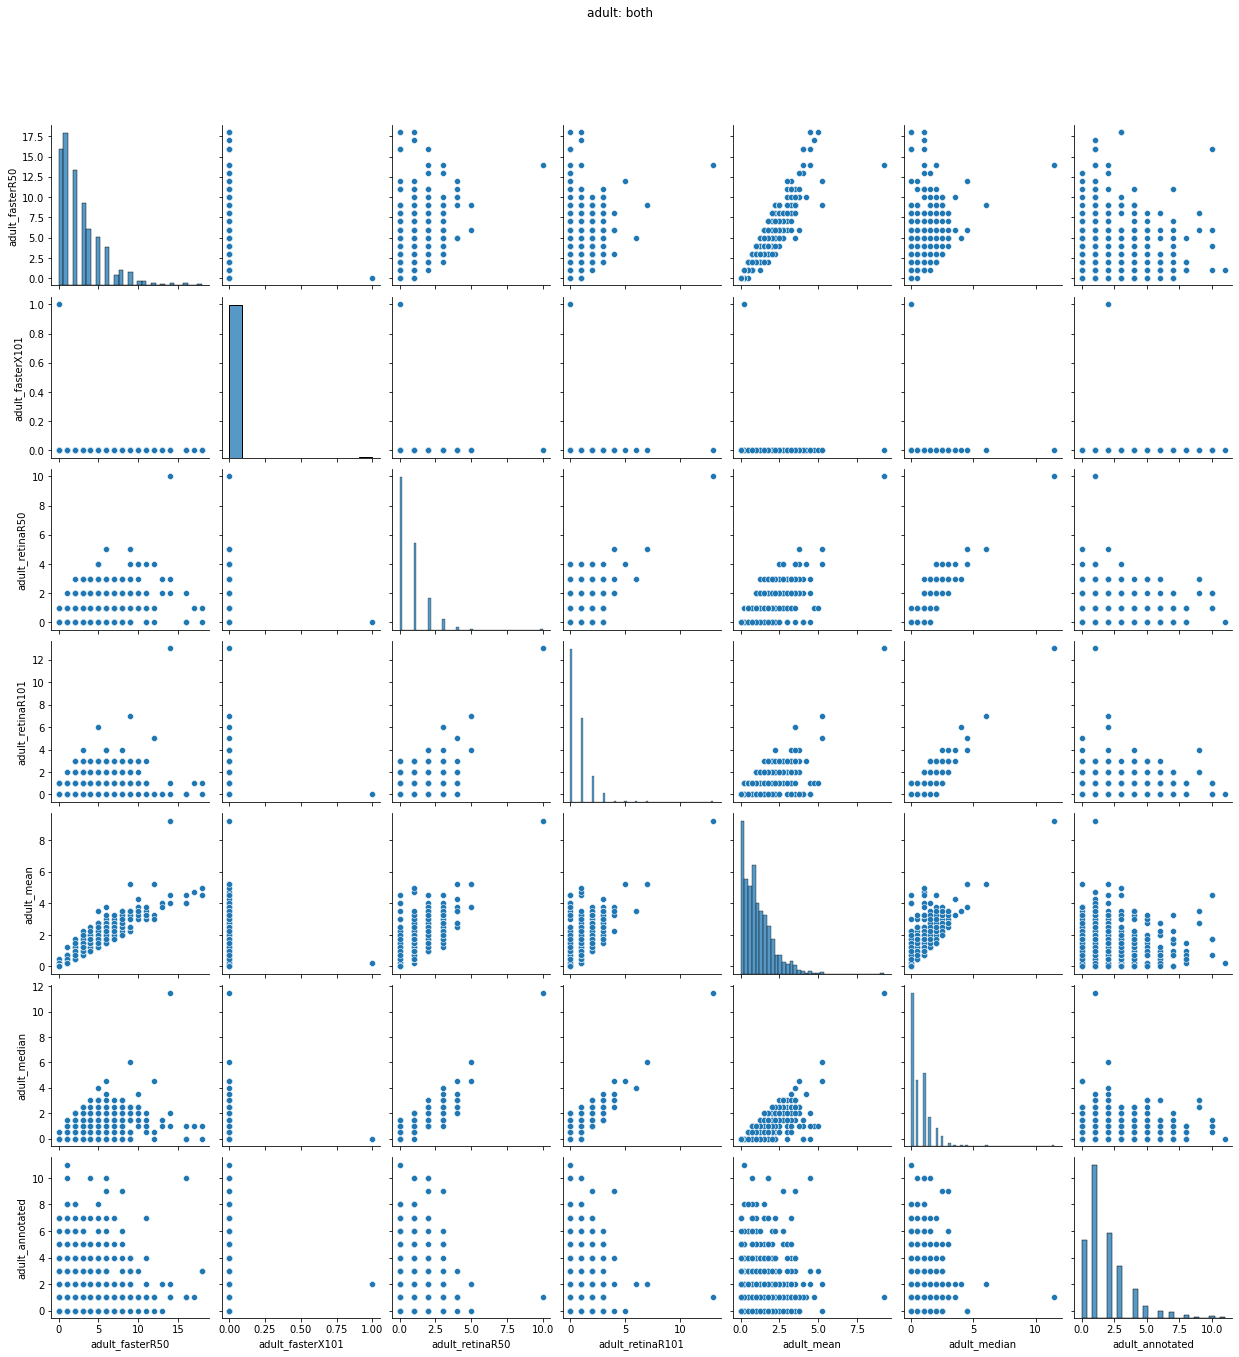

plotting religiousGarmentFemale: both. Dim: (1007, 132)


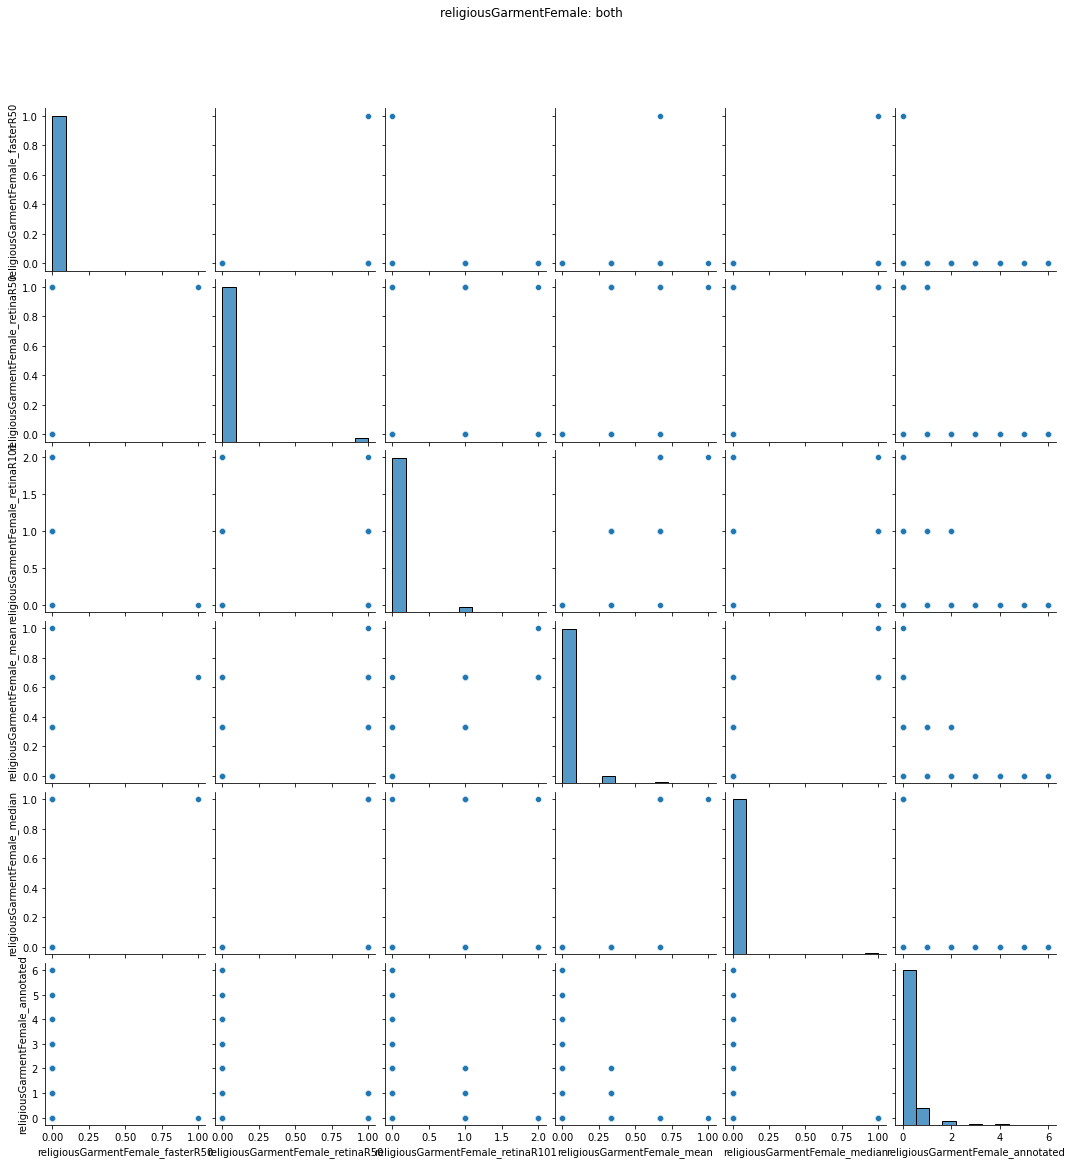

plotting firearm: both. Dim: (1007, 132)


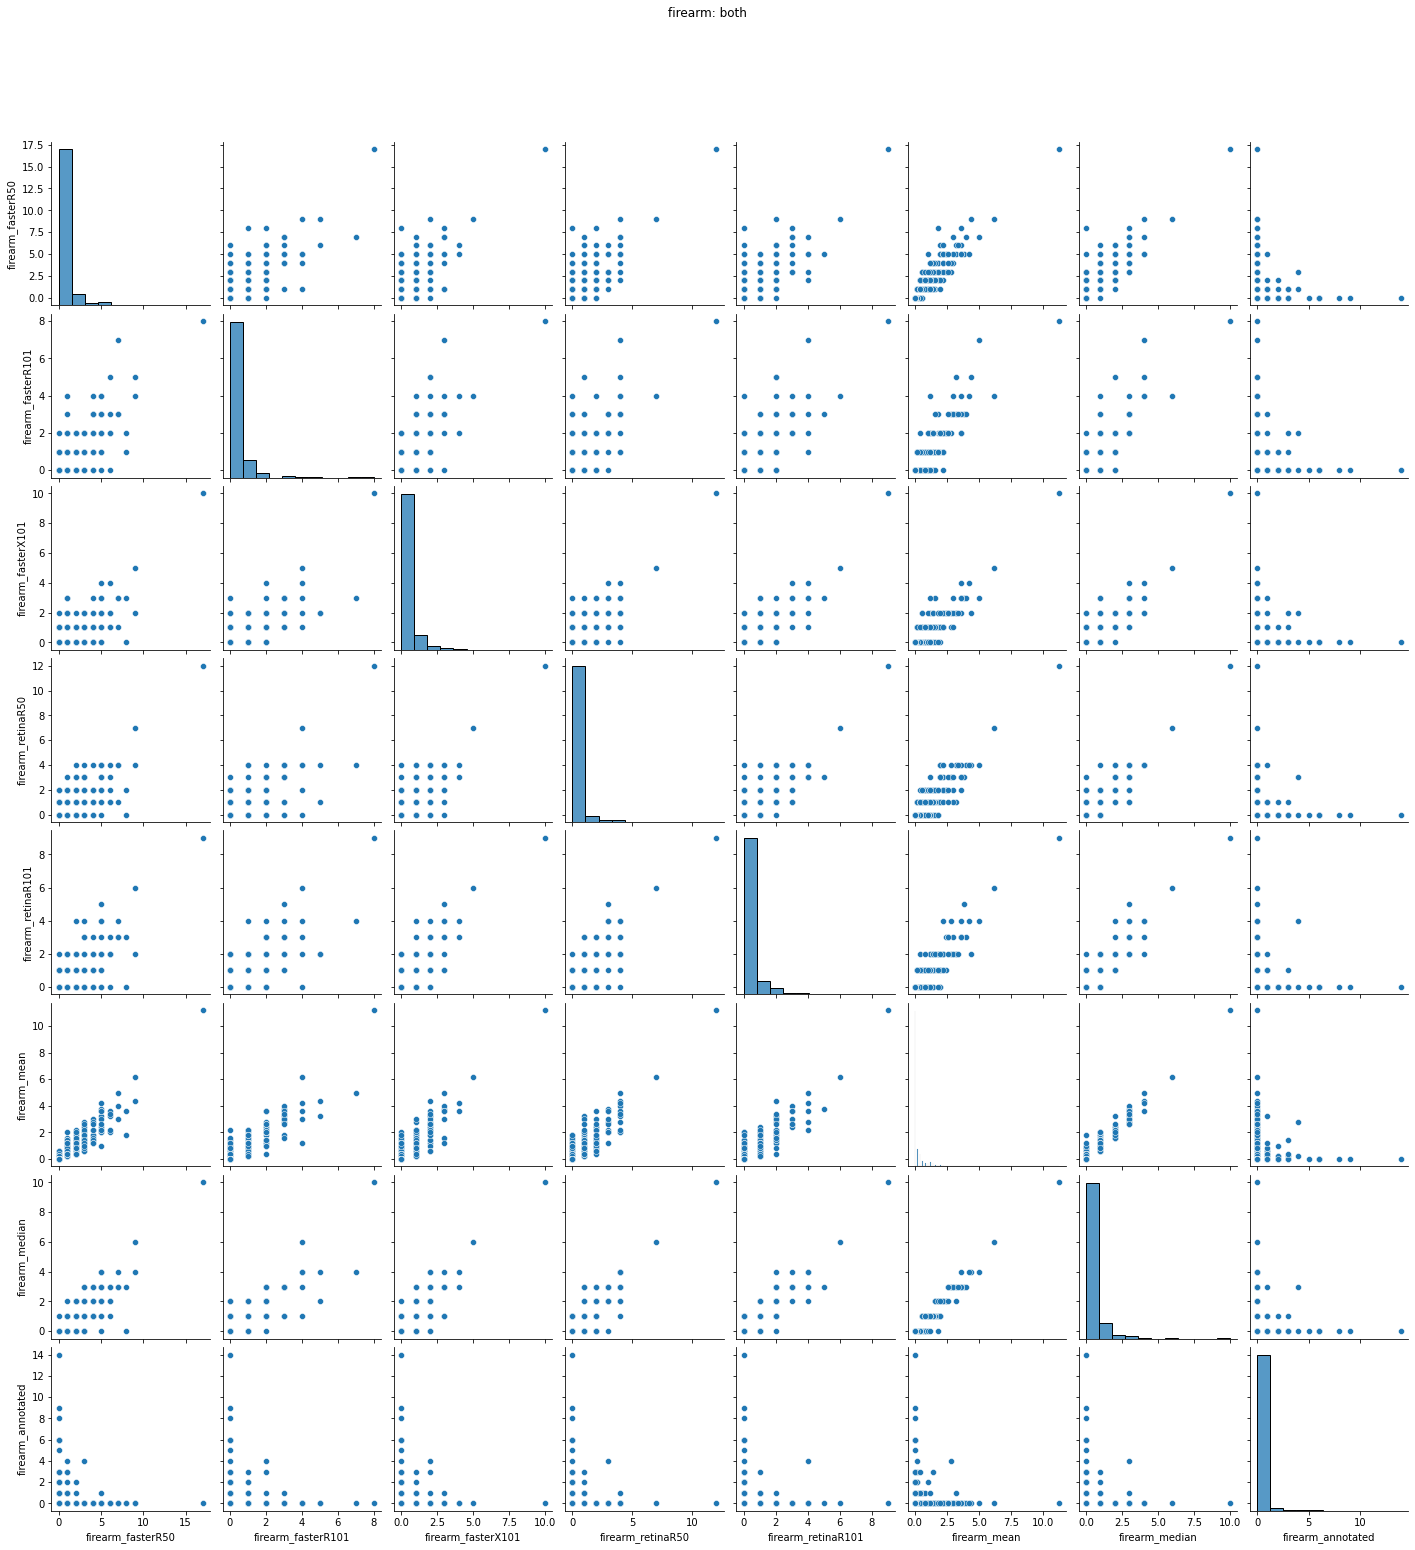

plotting falgIRQ: both. Dim: (1007, 132)


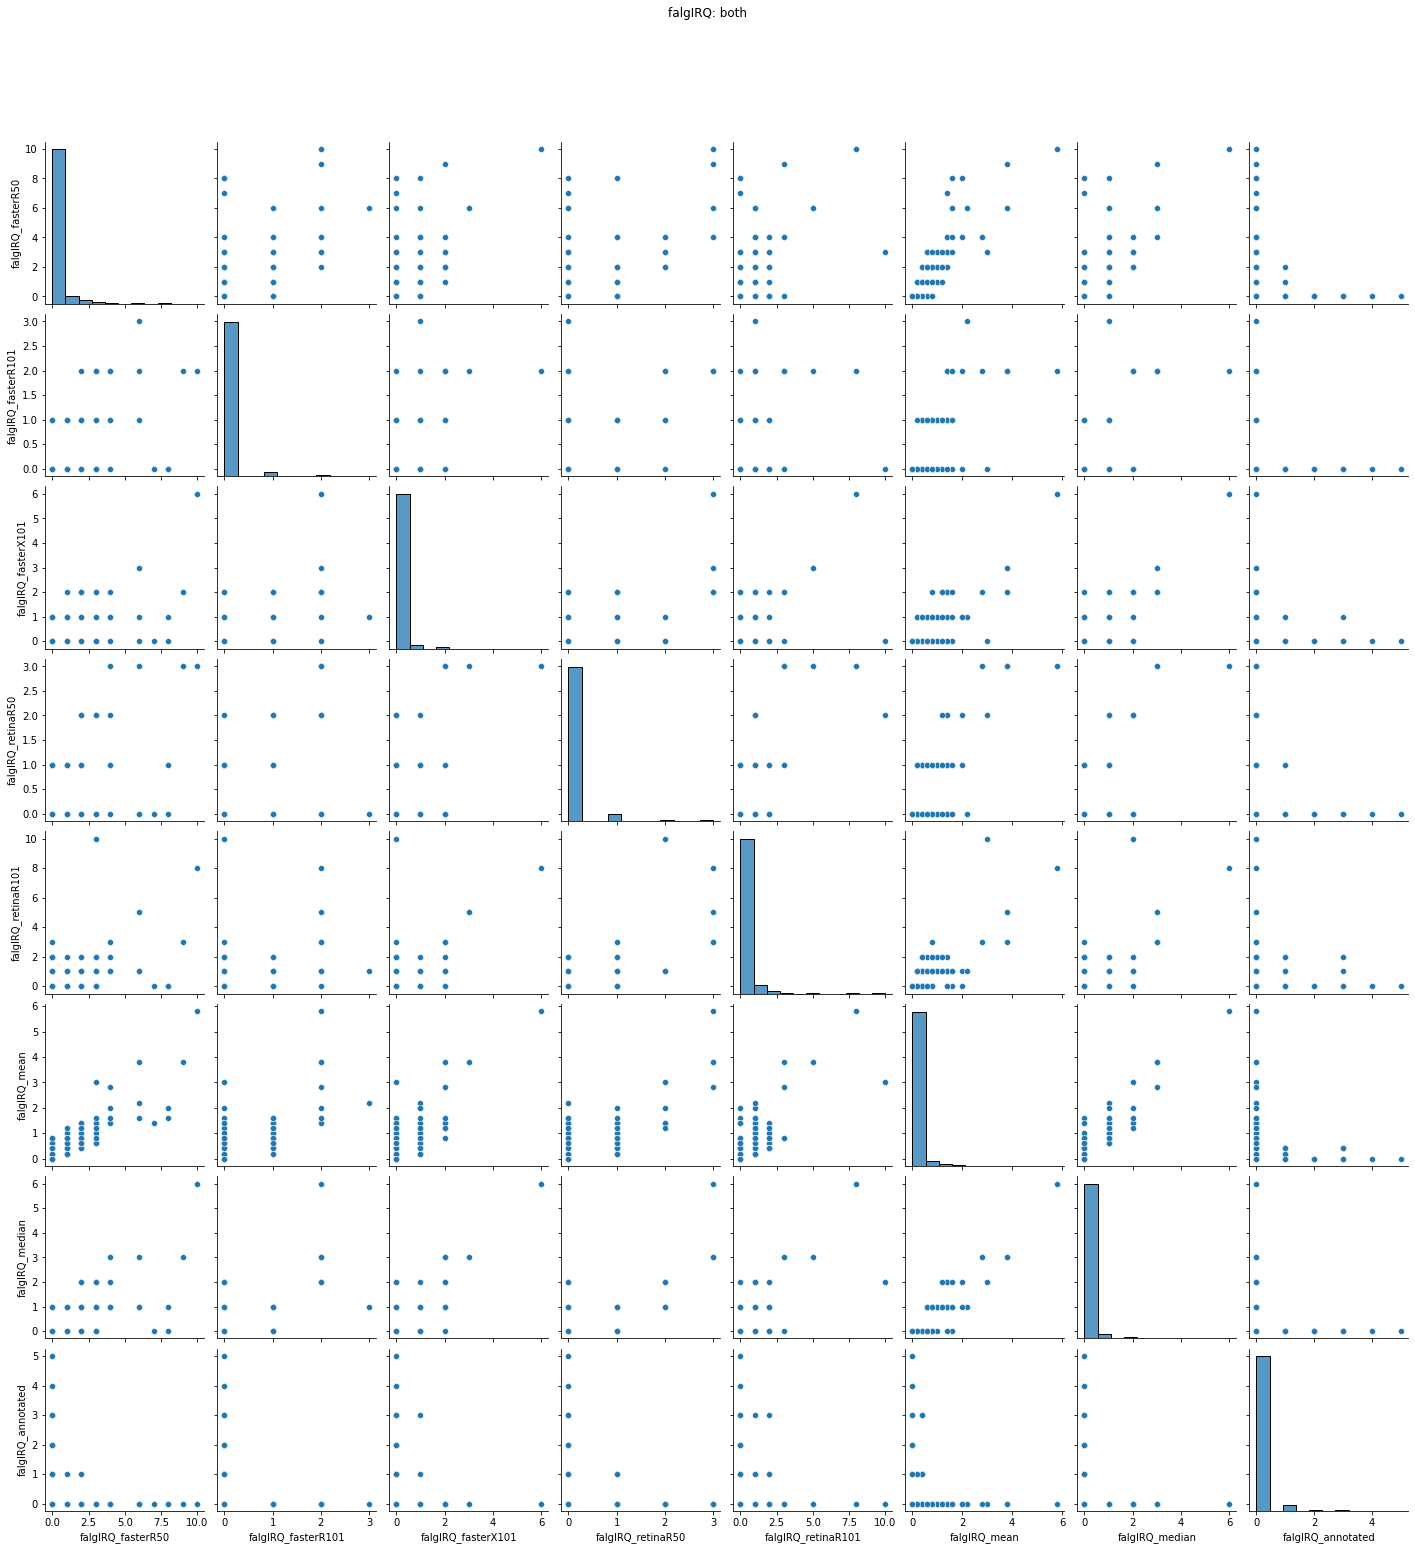

plotting militaryVehicle: both. Dim: (1007, 132)


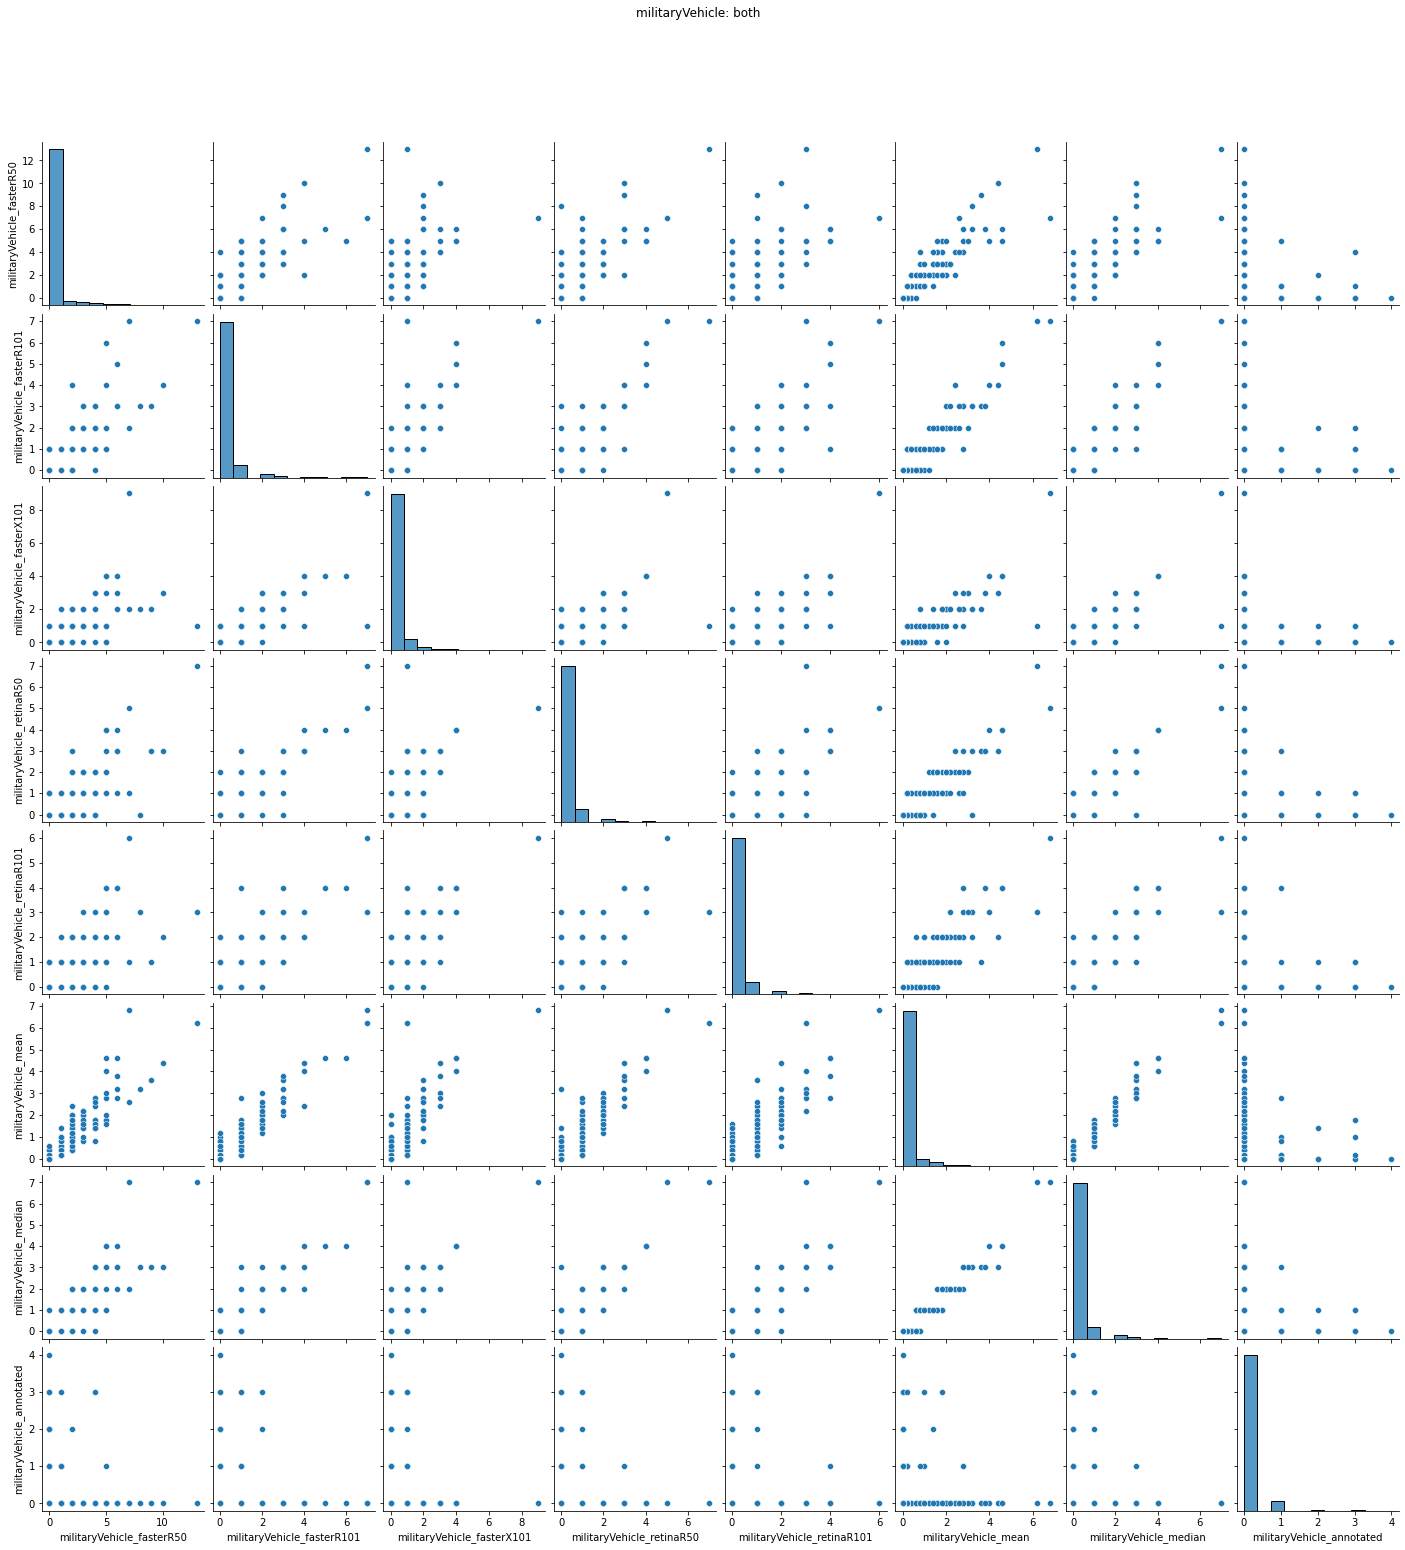

plotting female: both. Dim: (1007, 132)


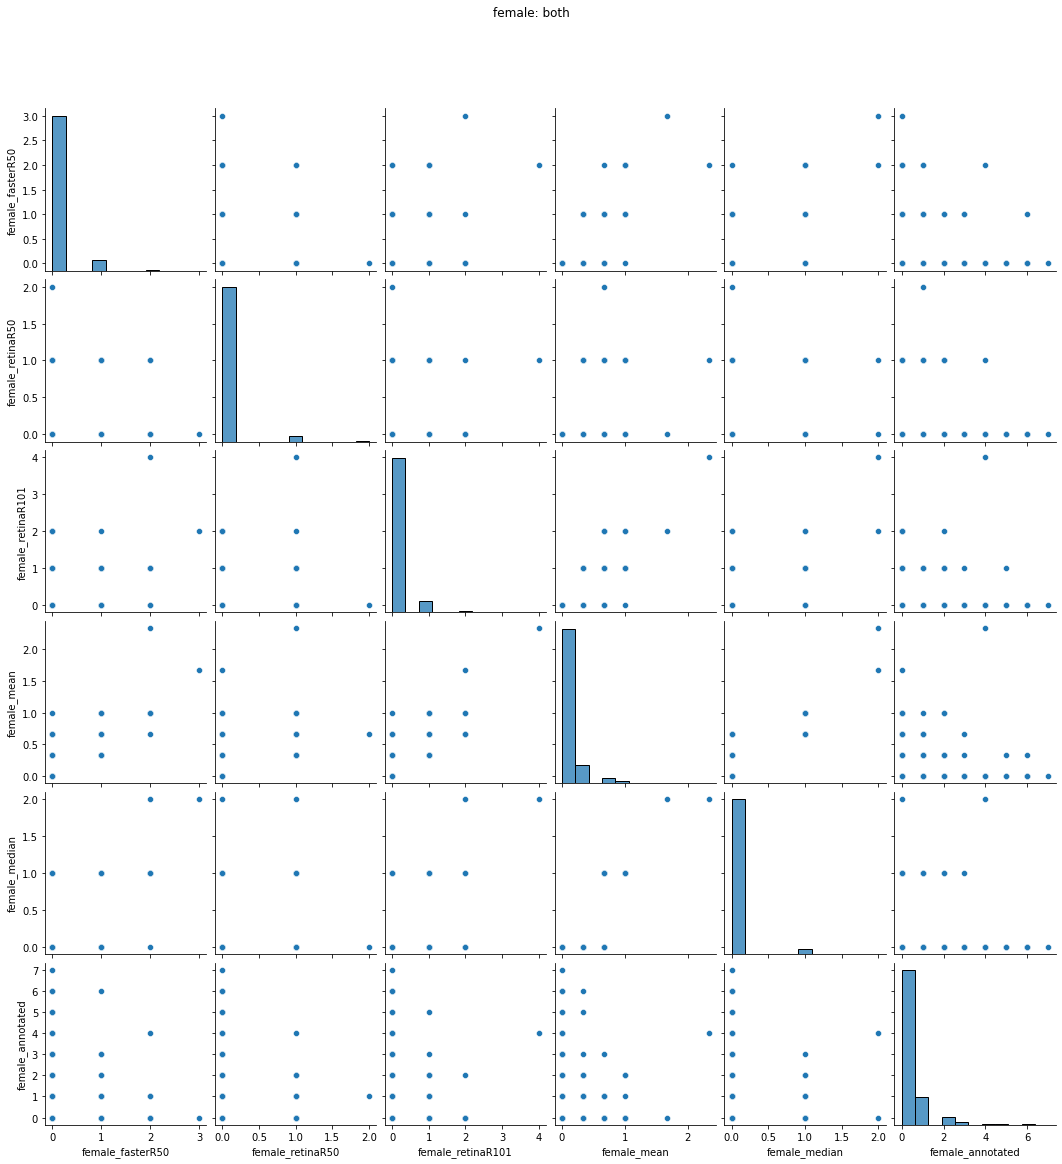

plotting uniformed: both. Dim: (1007, 132)


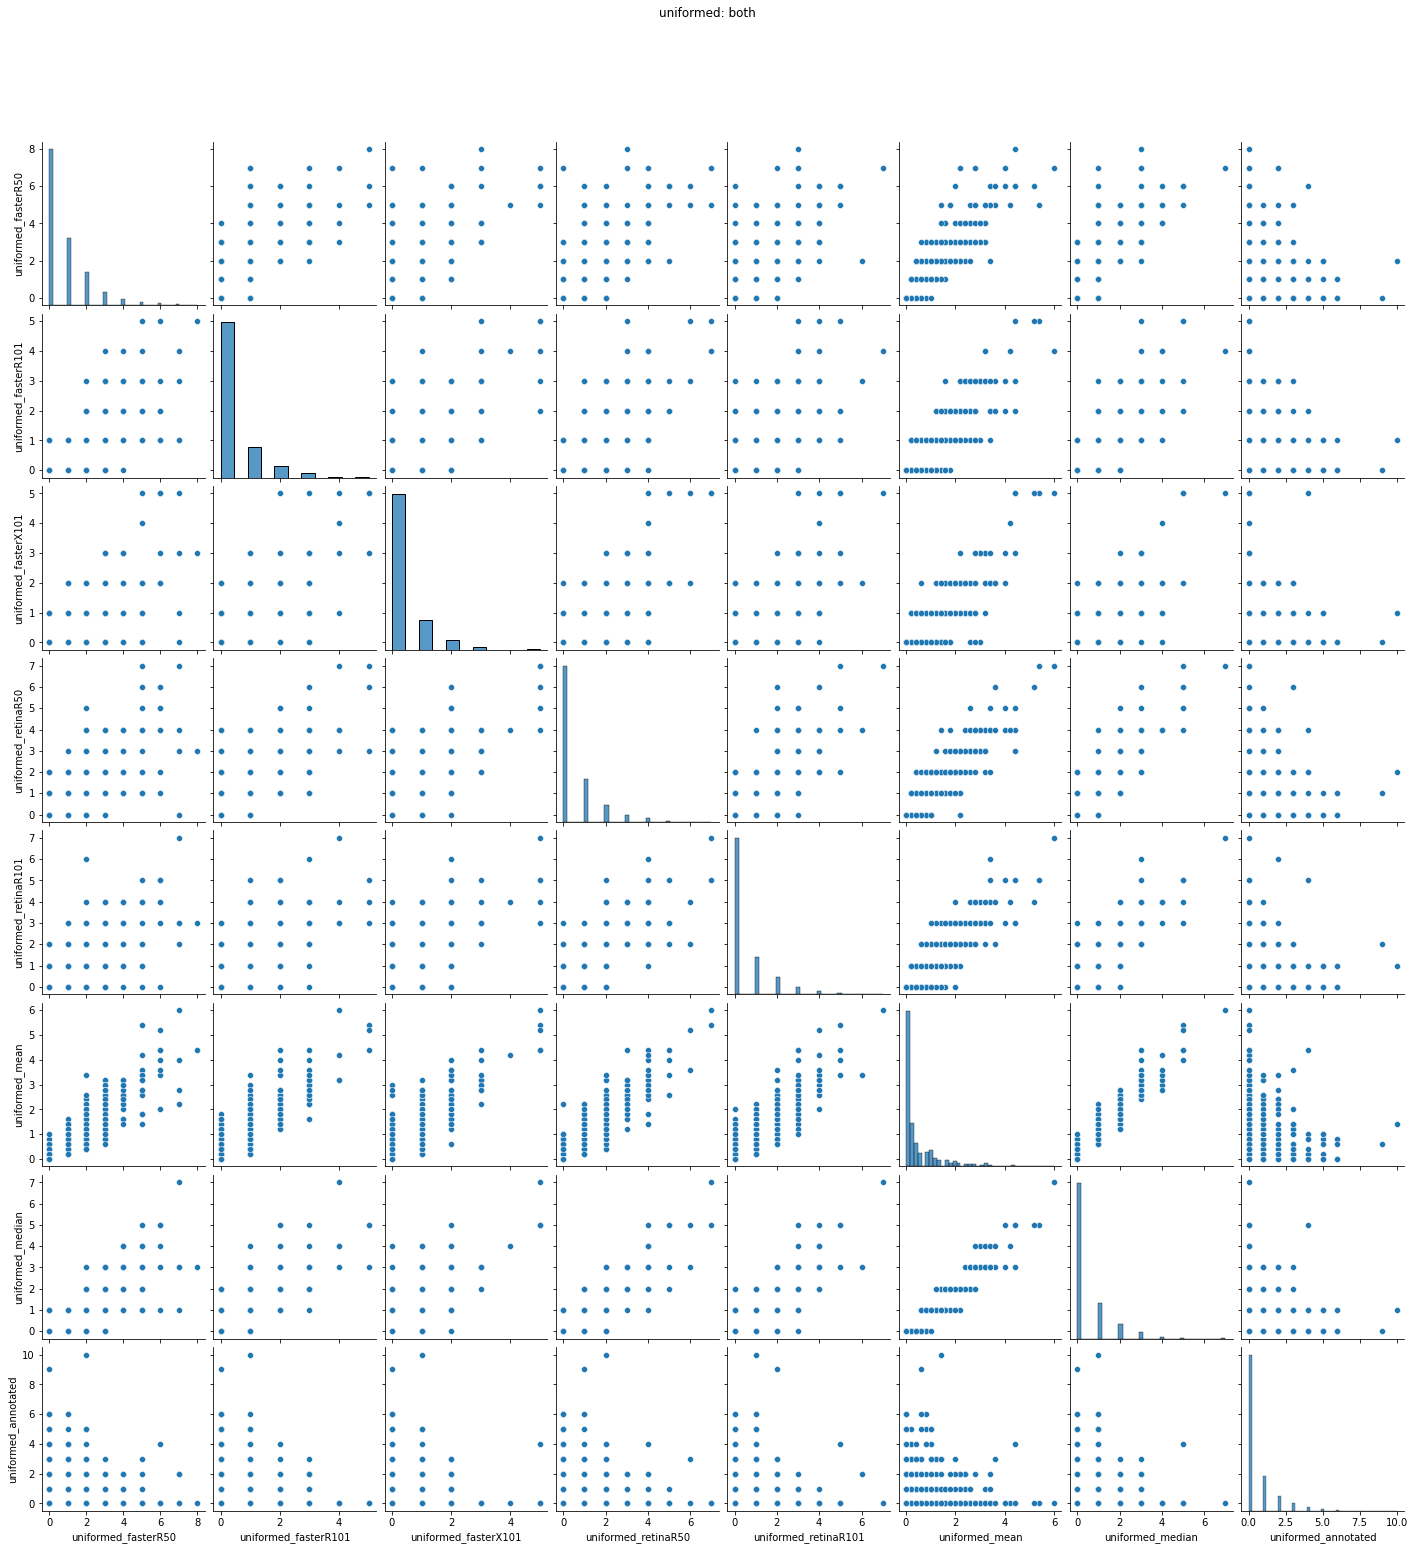

plotting bloodedArea: both. Dim: (1007, 132)


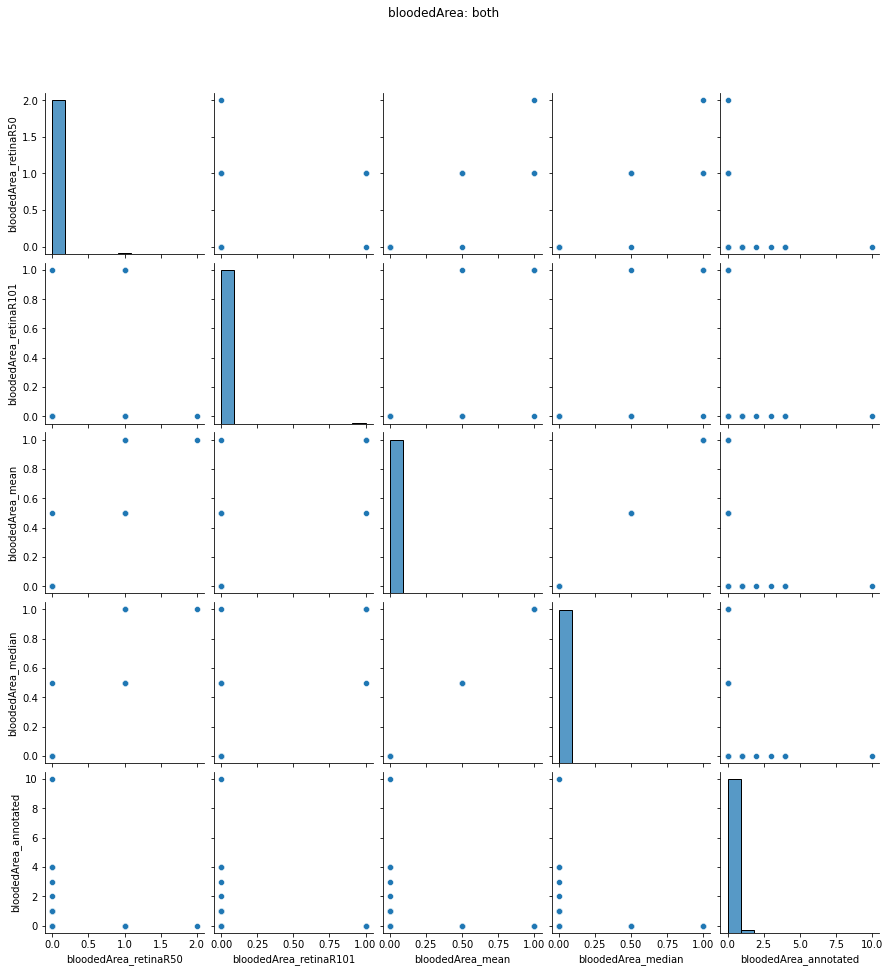

plotting male: both. Dim: (1007, 132)


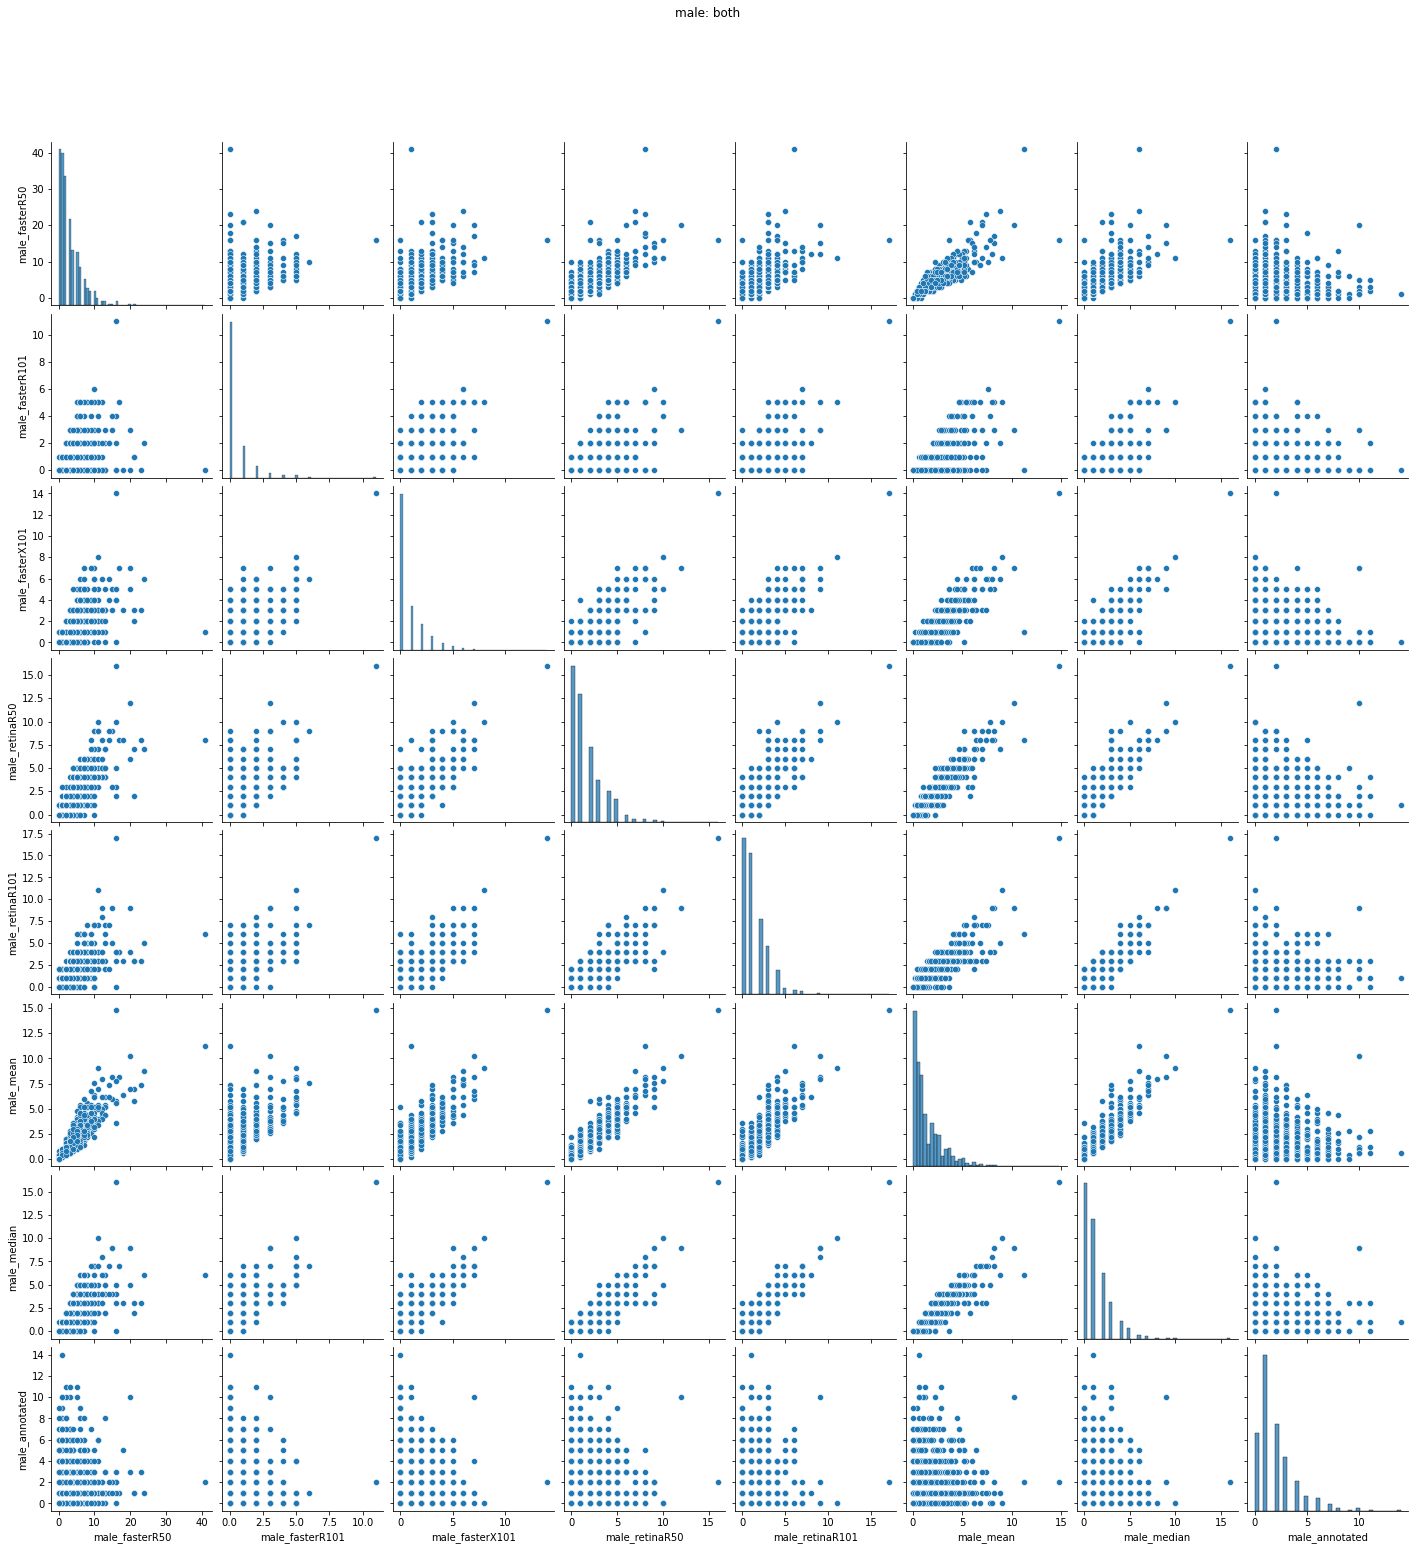

plotting casualty: train. Dim: (805, 132)


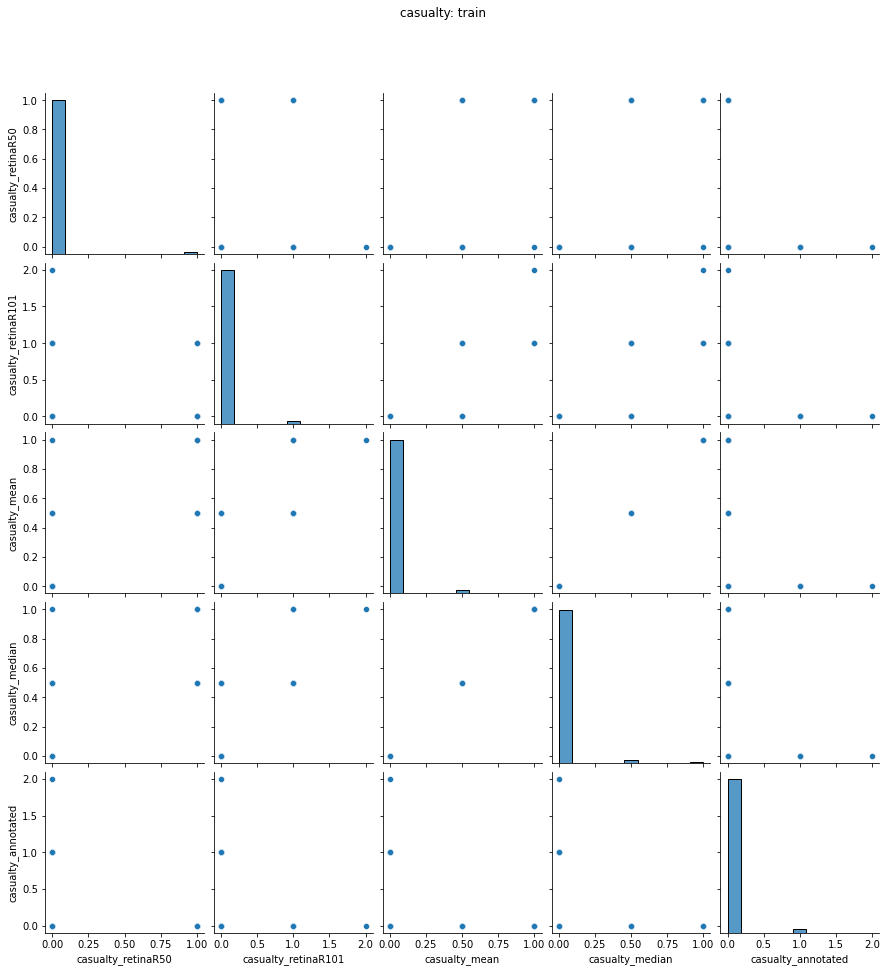

plotting flagUS: train. Dim: (805, 132)


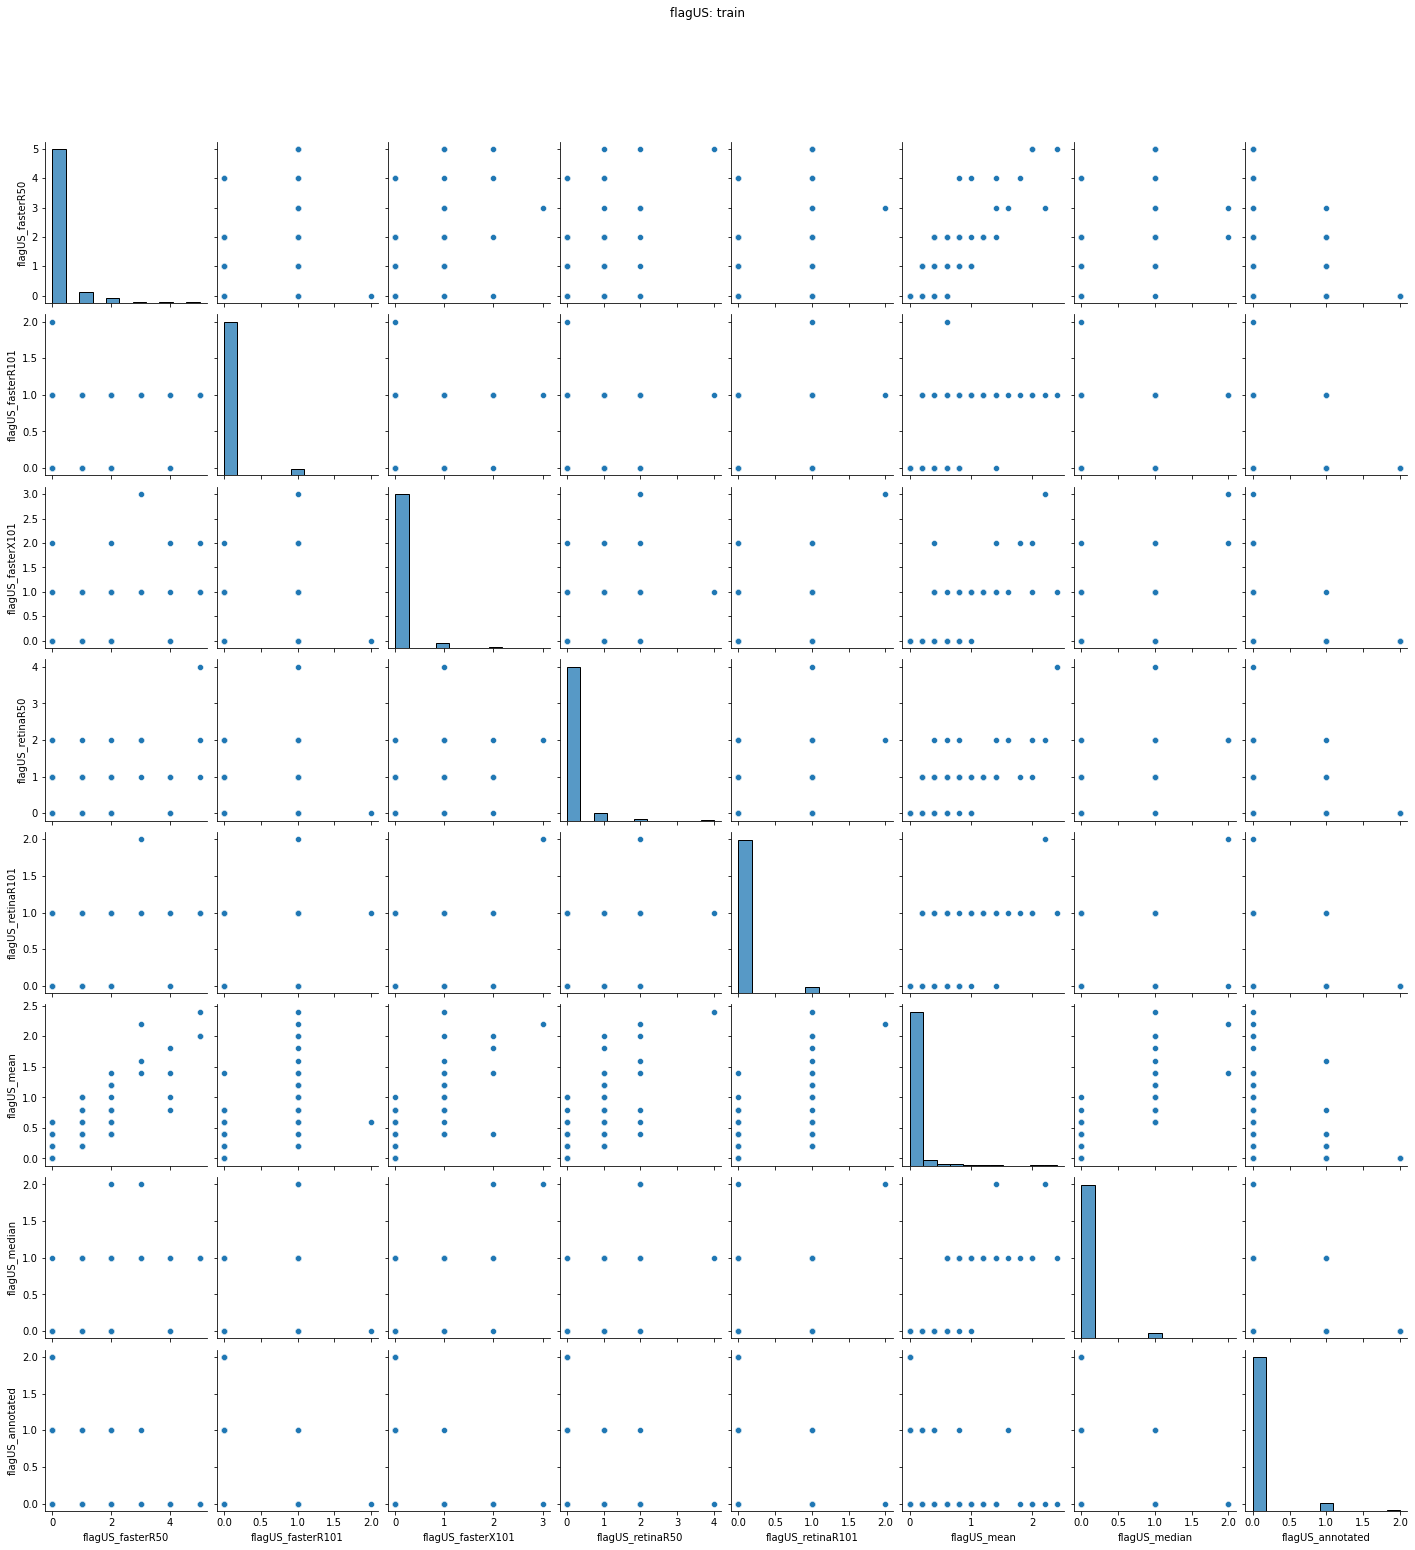

plotting youth: train. Dim: (805, 132)


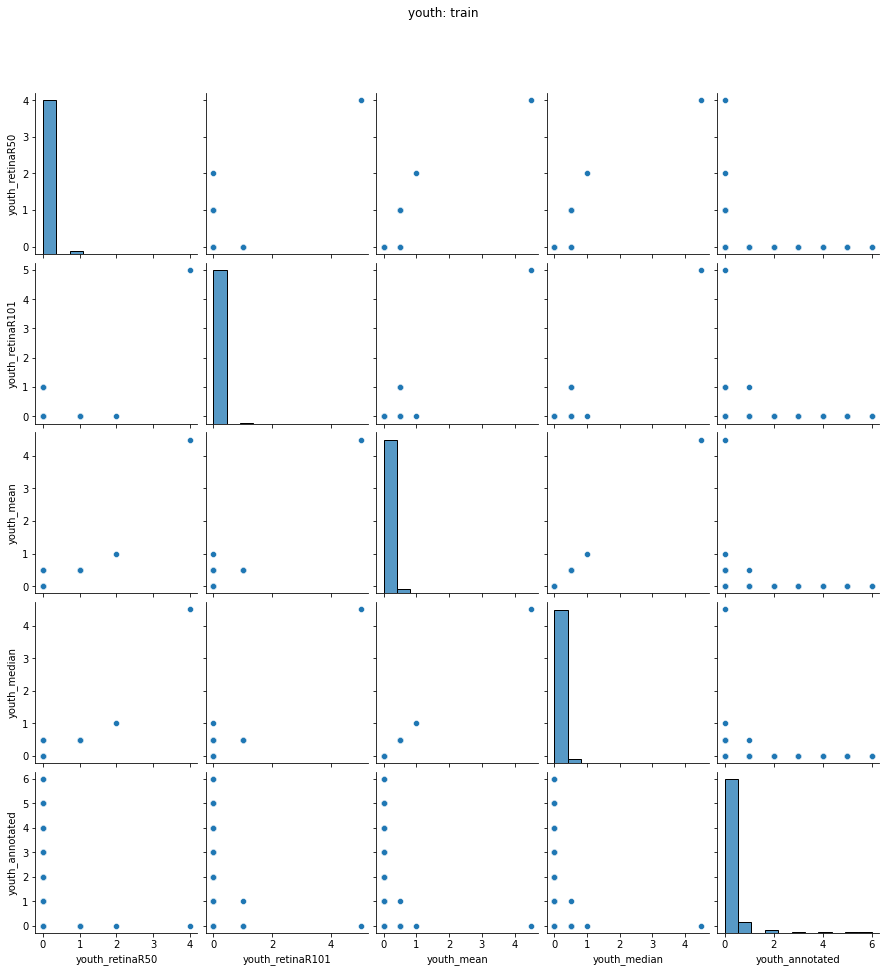

plotting elderly: train. Dim: (805, 132)


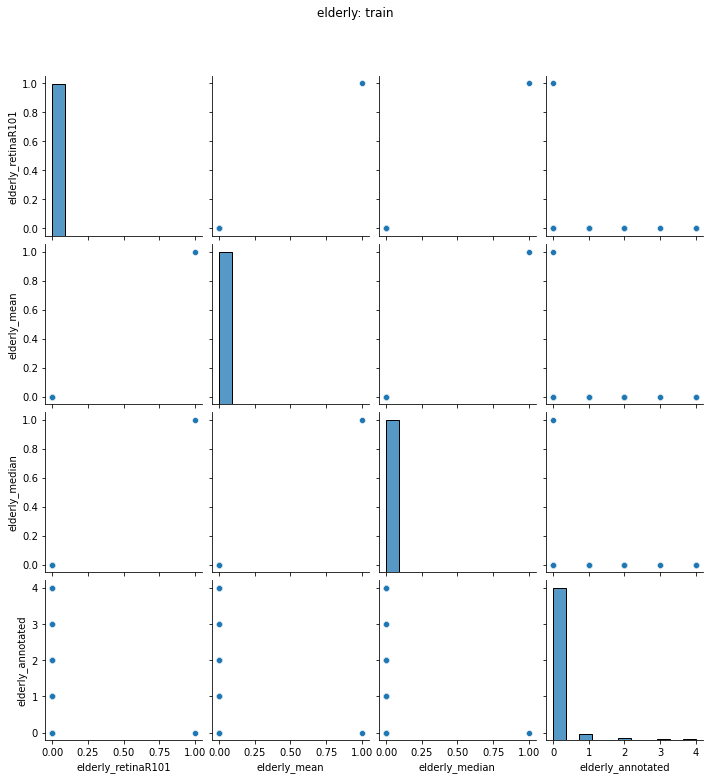

plotting child: train. Dim: (805, 132)


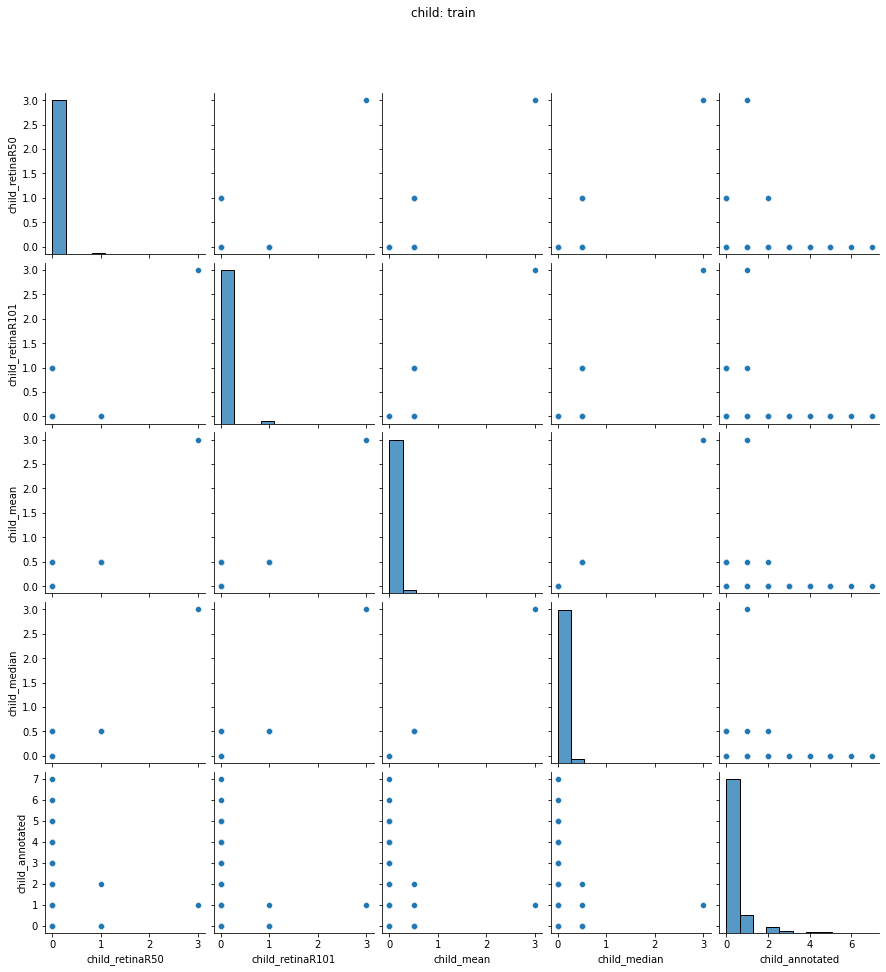

plotting person: train. Dim: (805, 132)


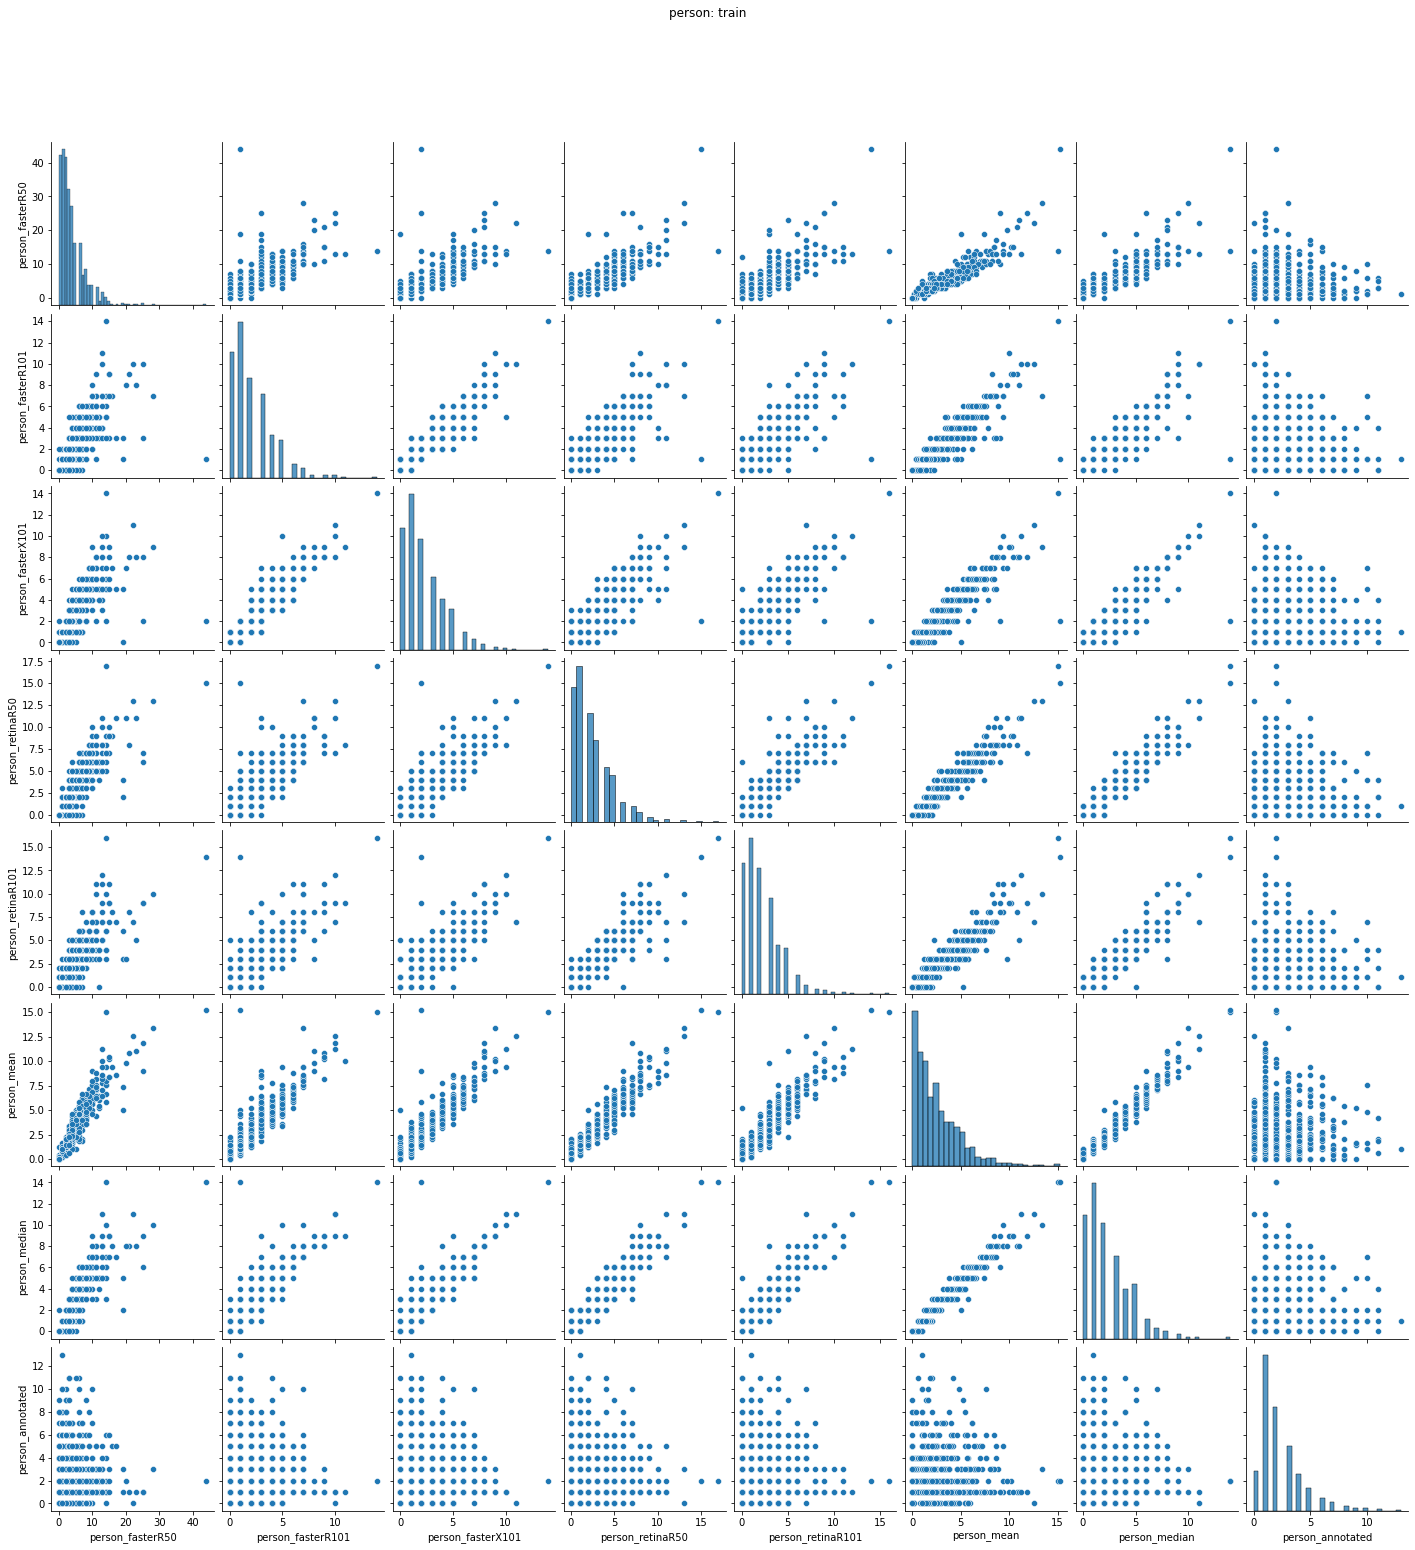

plotting hostage: train. Dim: (805, 132)


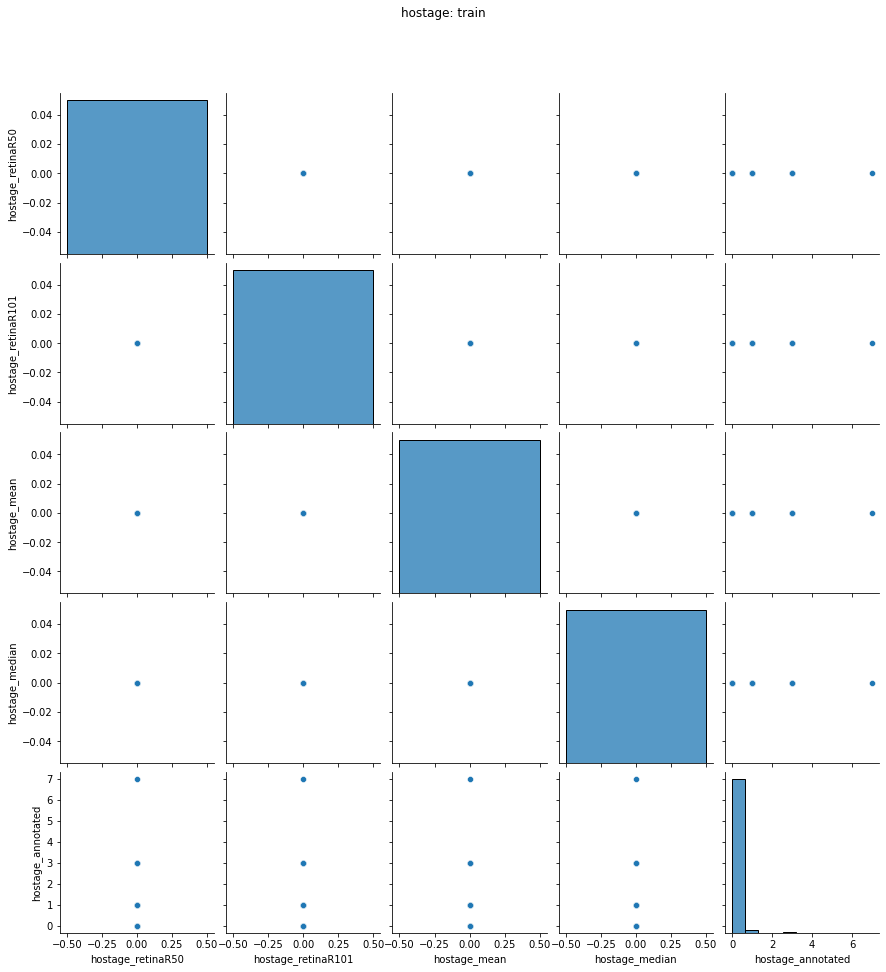

plotting adult: train. Dim: (805, 132)


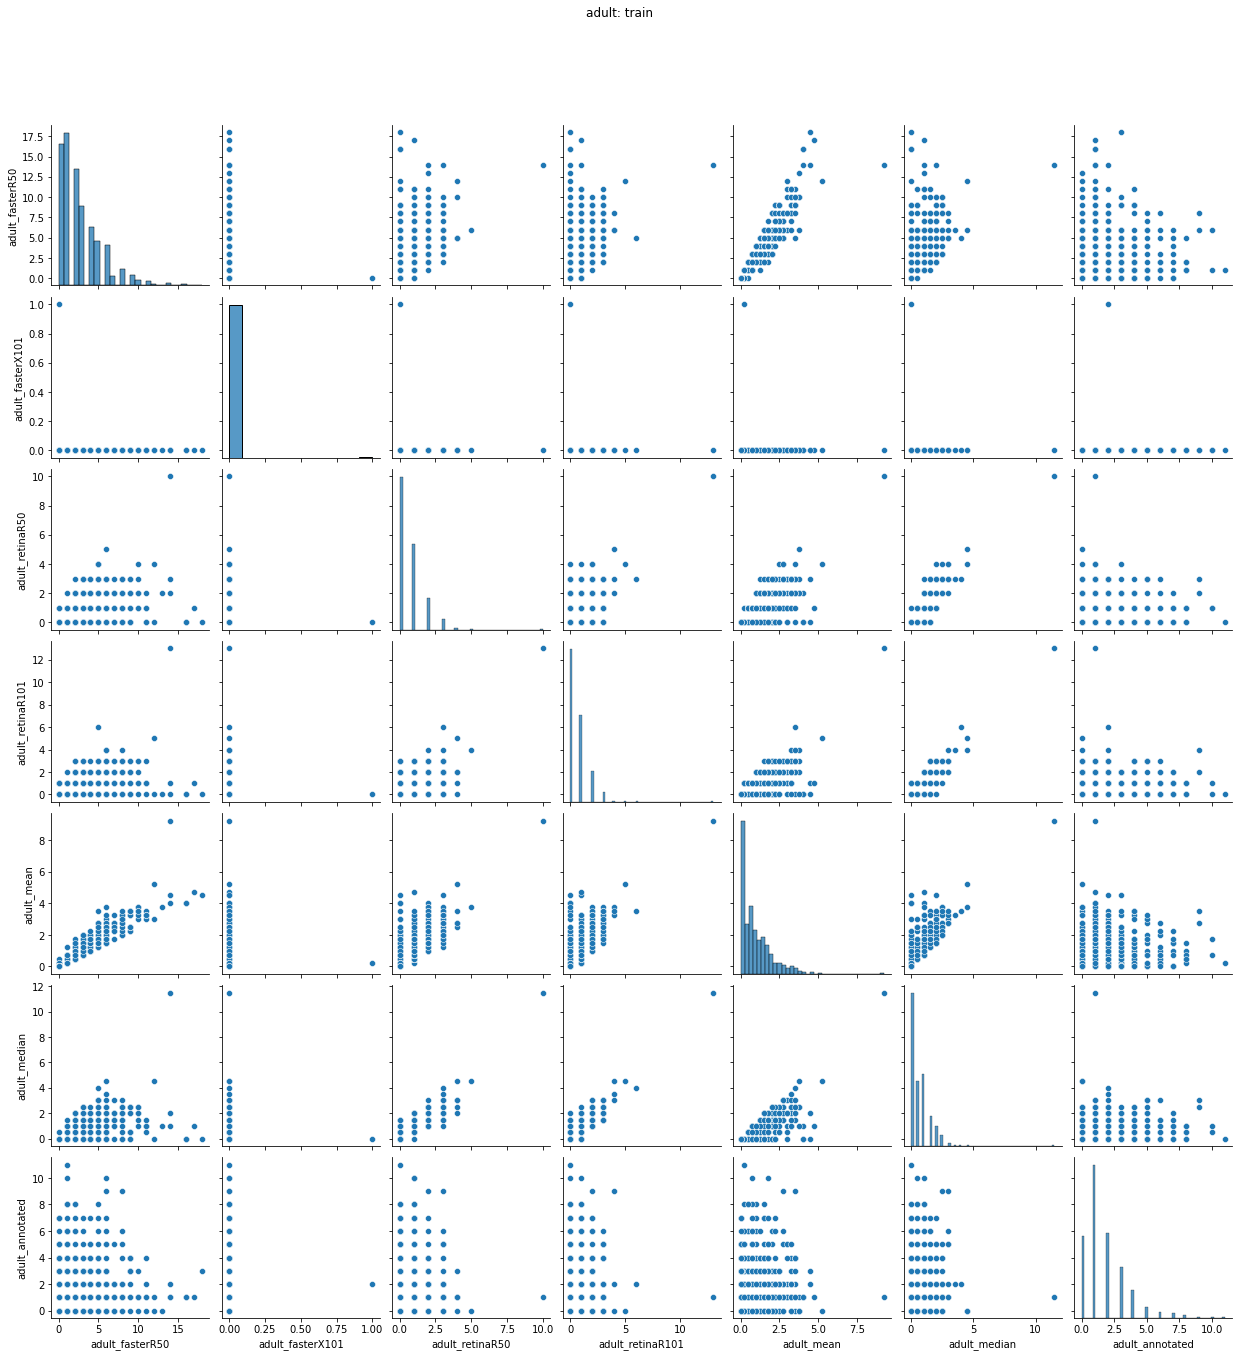

plotting religiousGarmentFemale: train. Dim: (805, 132)


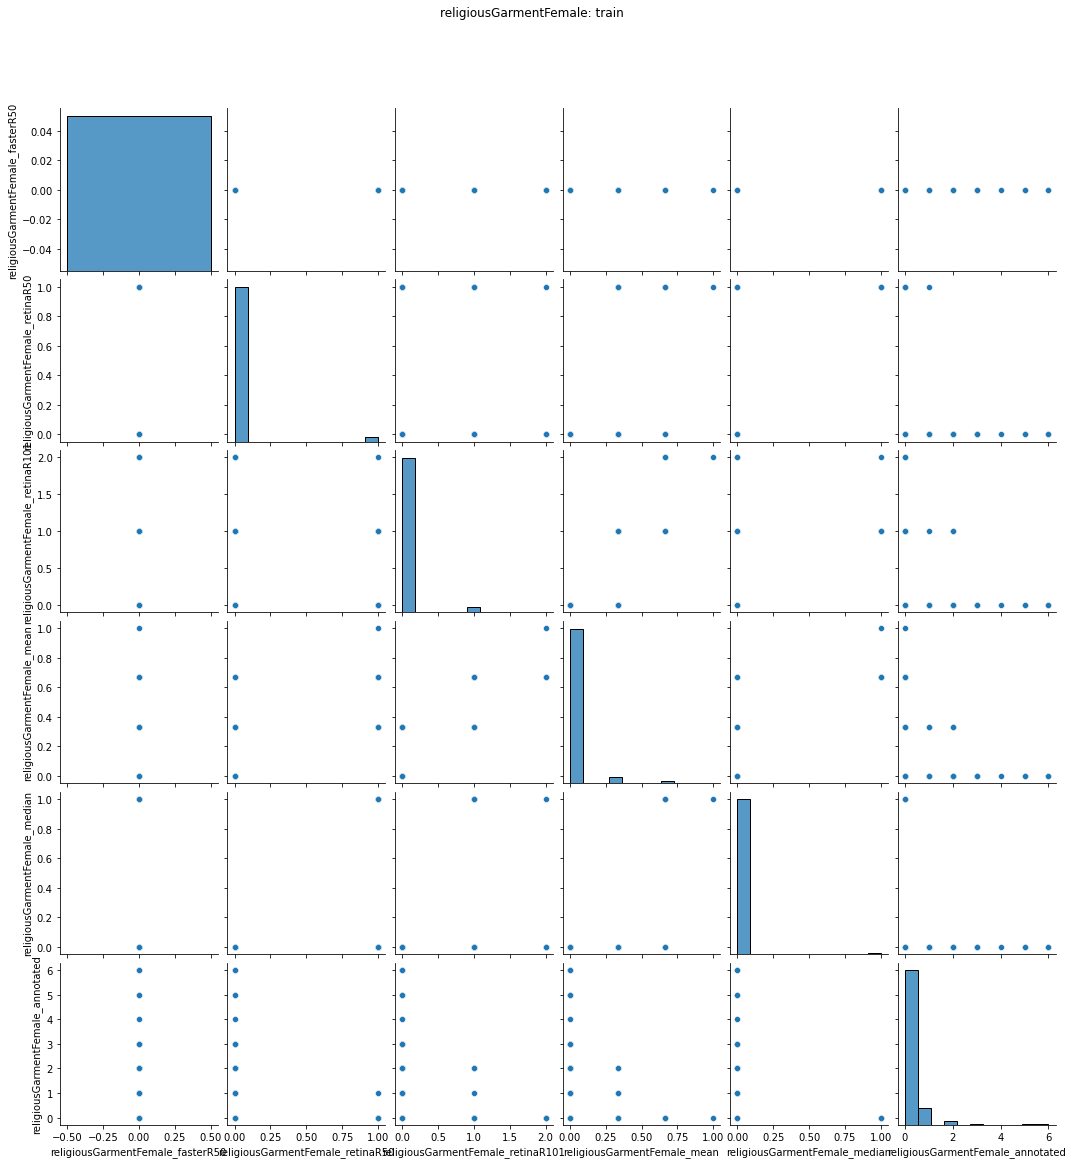

plotting firearm: train. Dim: (805, 132)


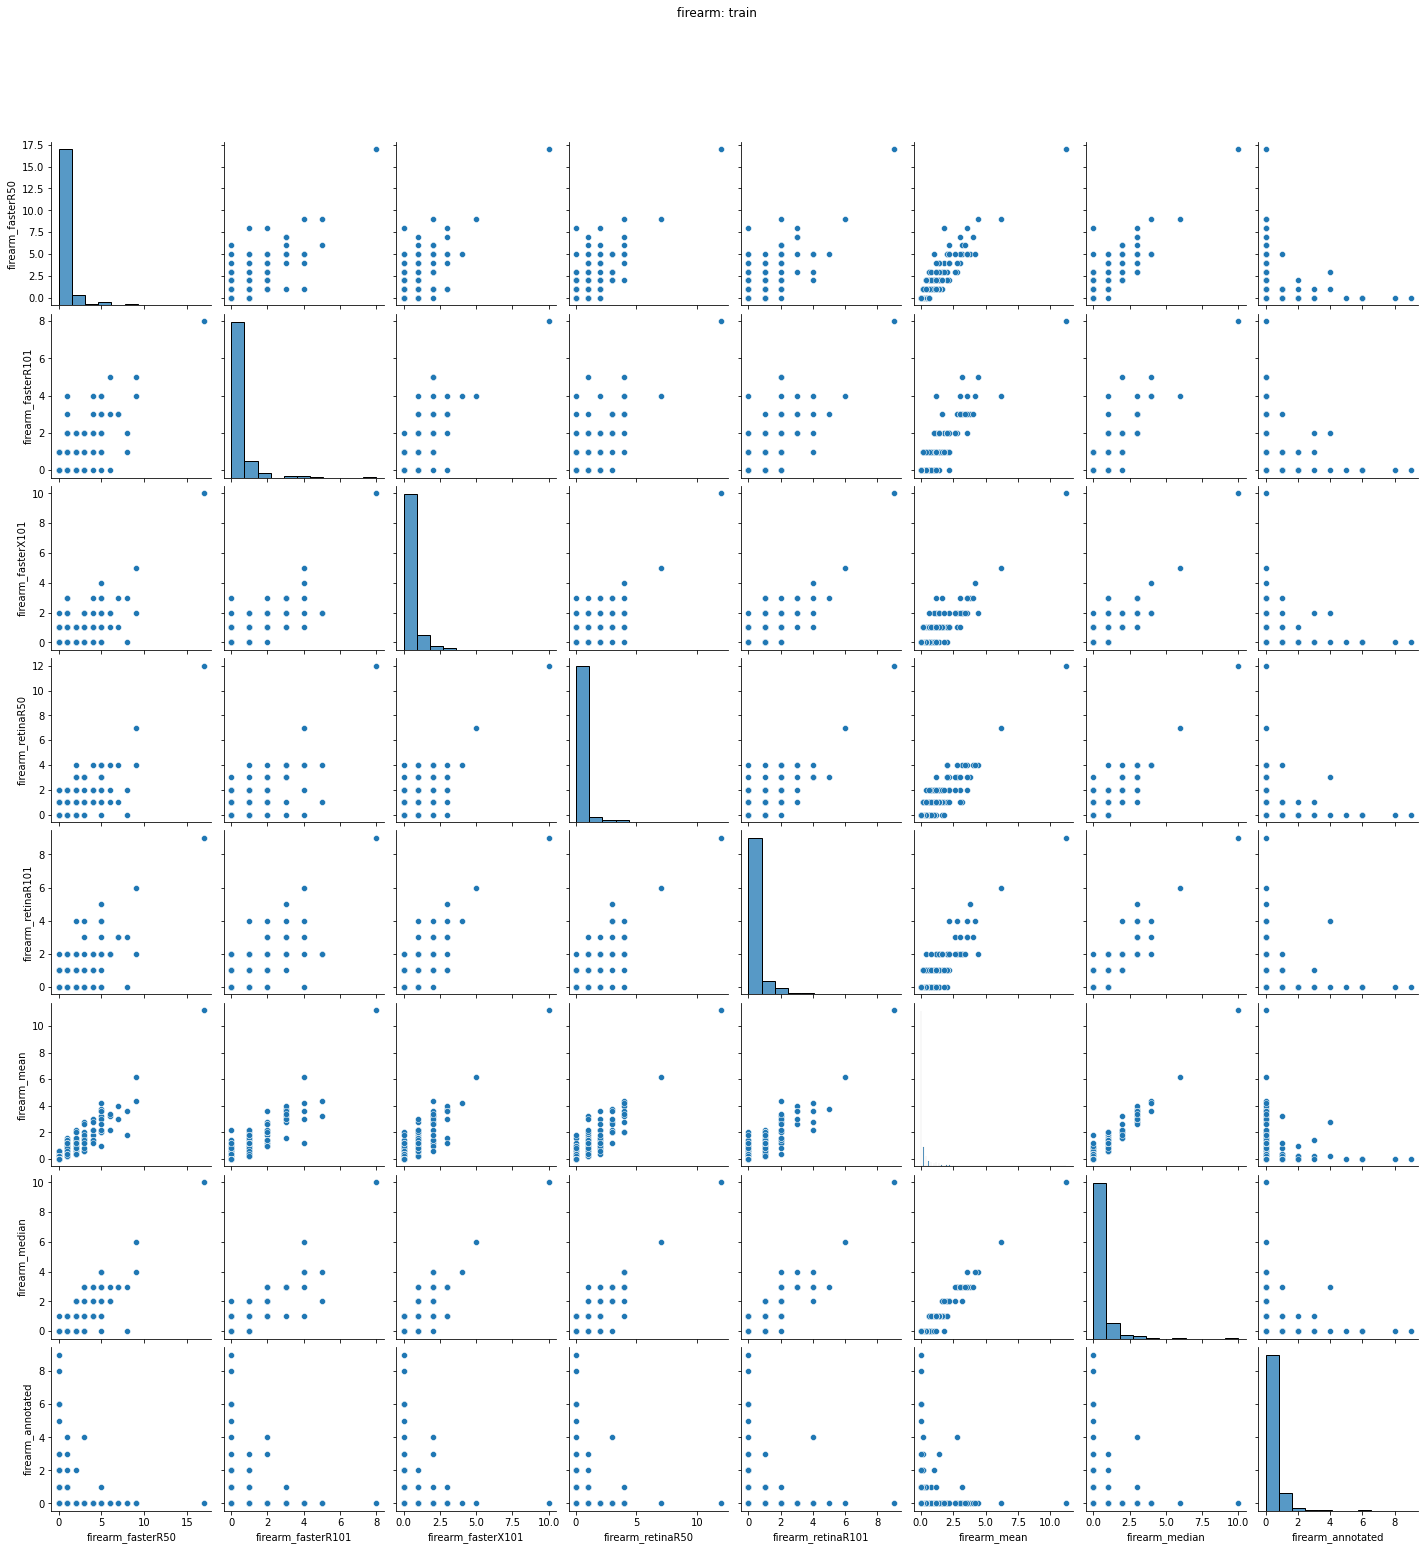

plotting falgIRQ: train. Dim: (805, 132)


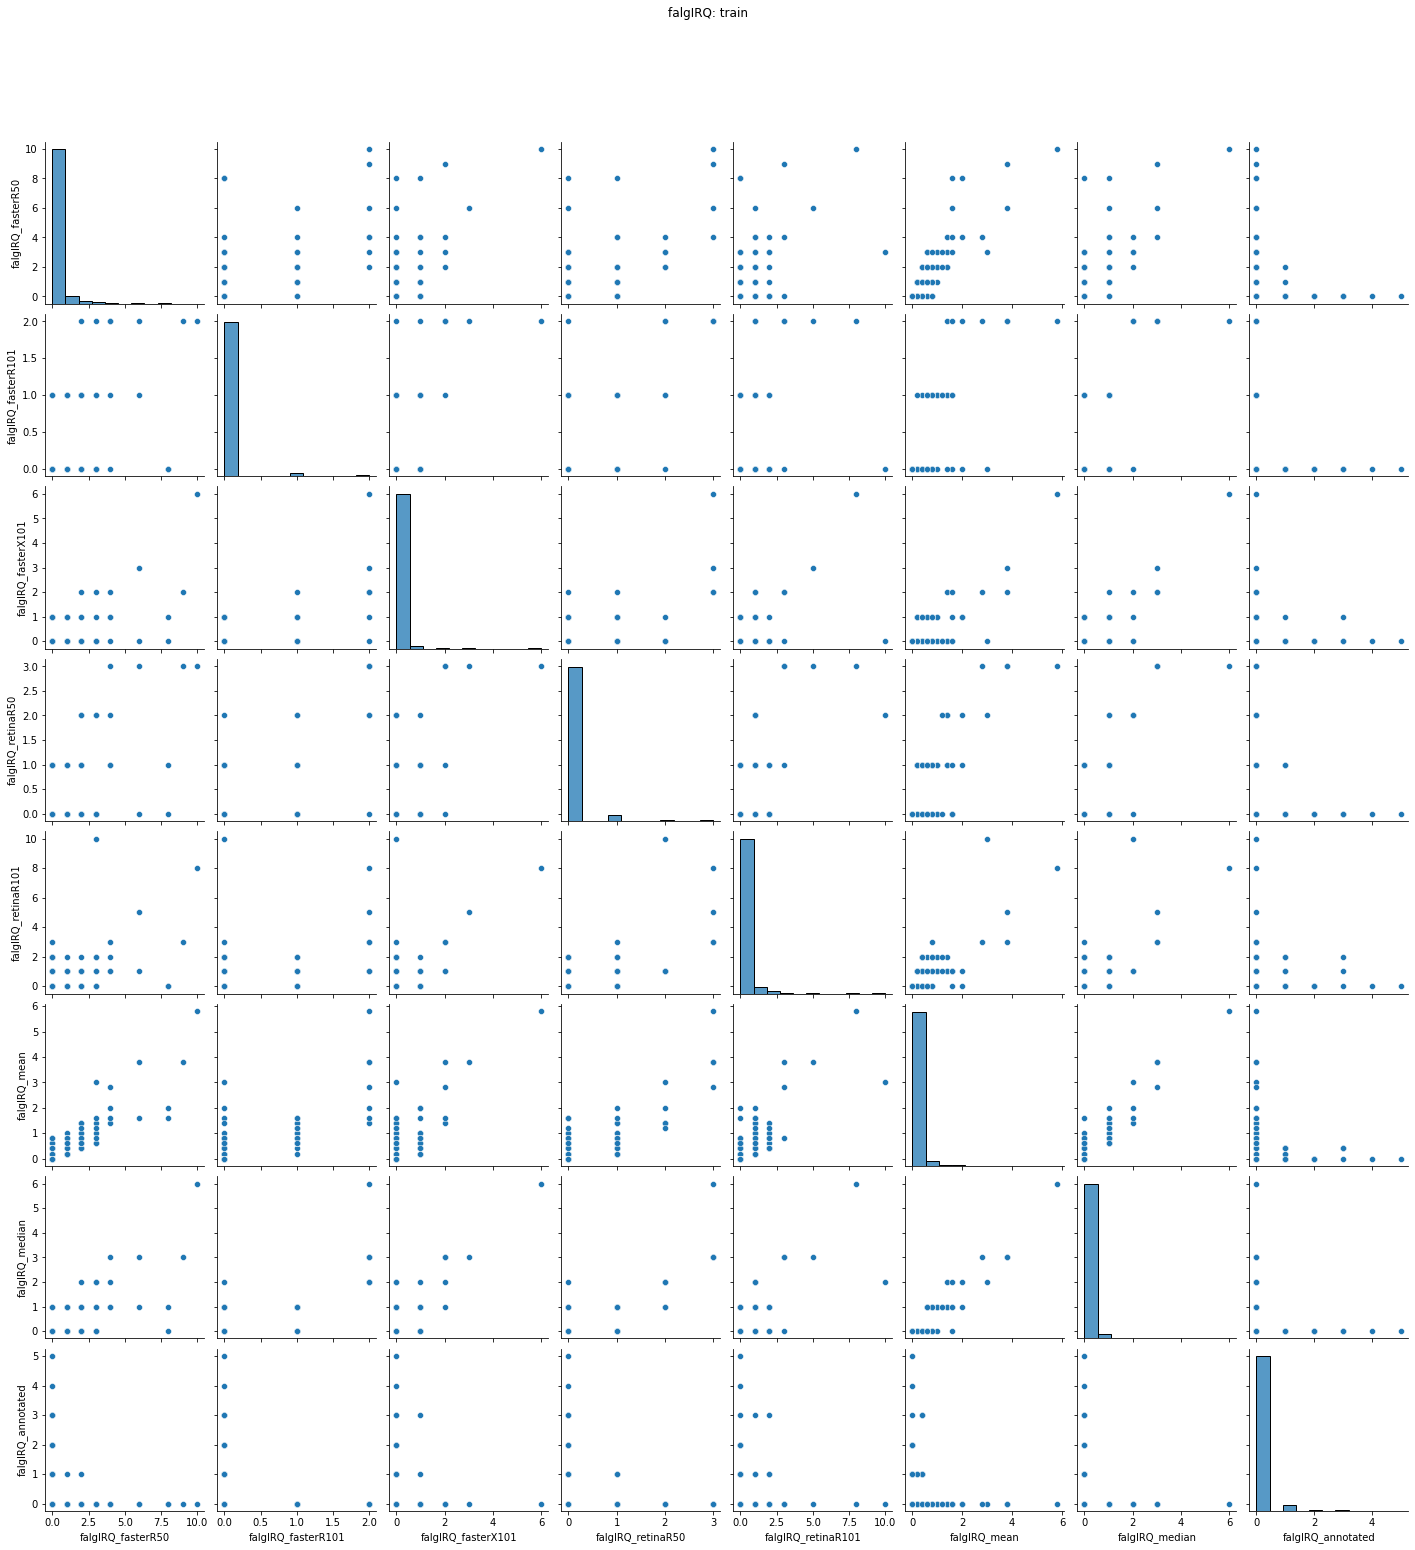

plotting militaryVehicle: train. Dim: (805, 132)


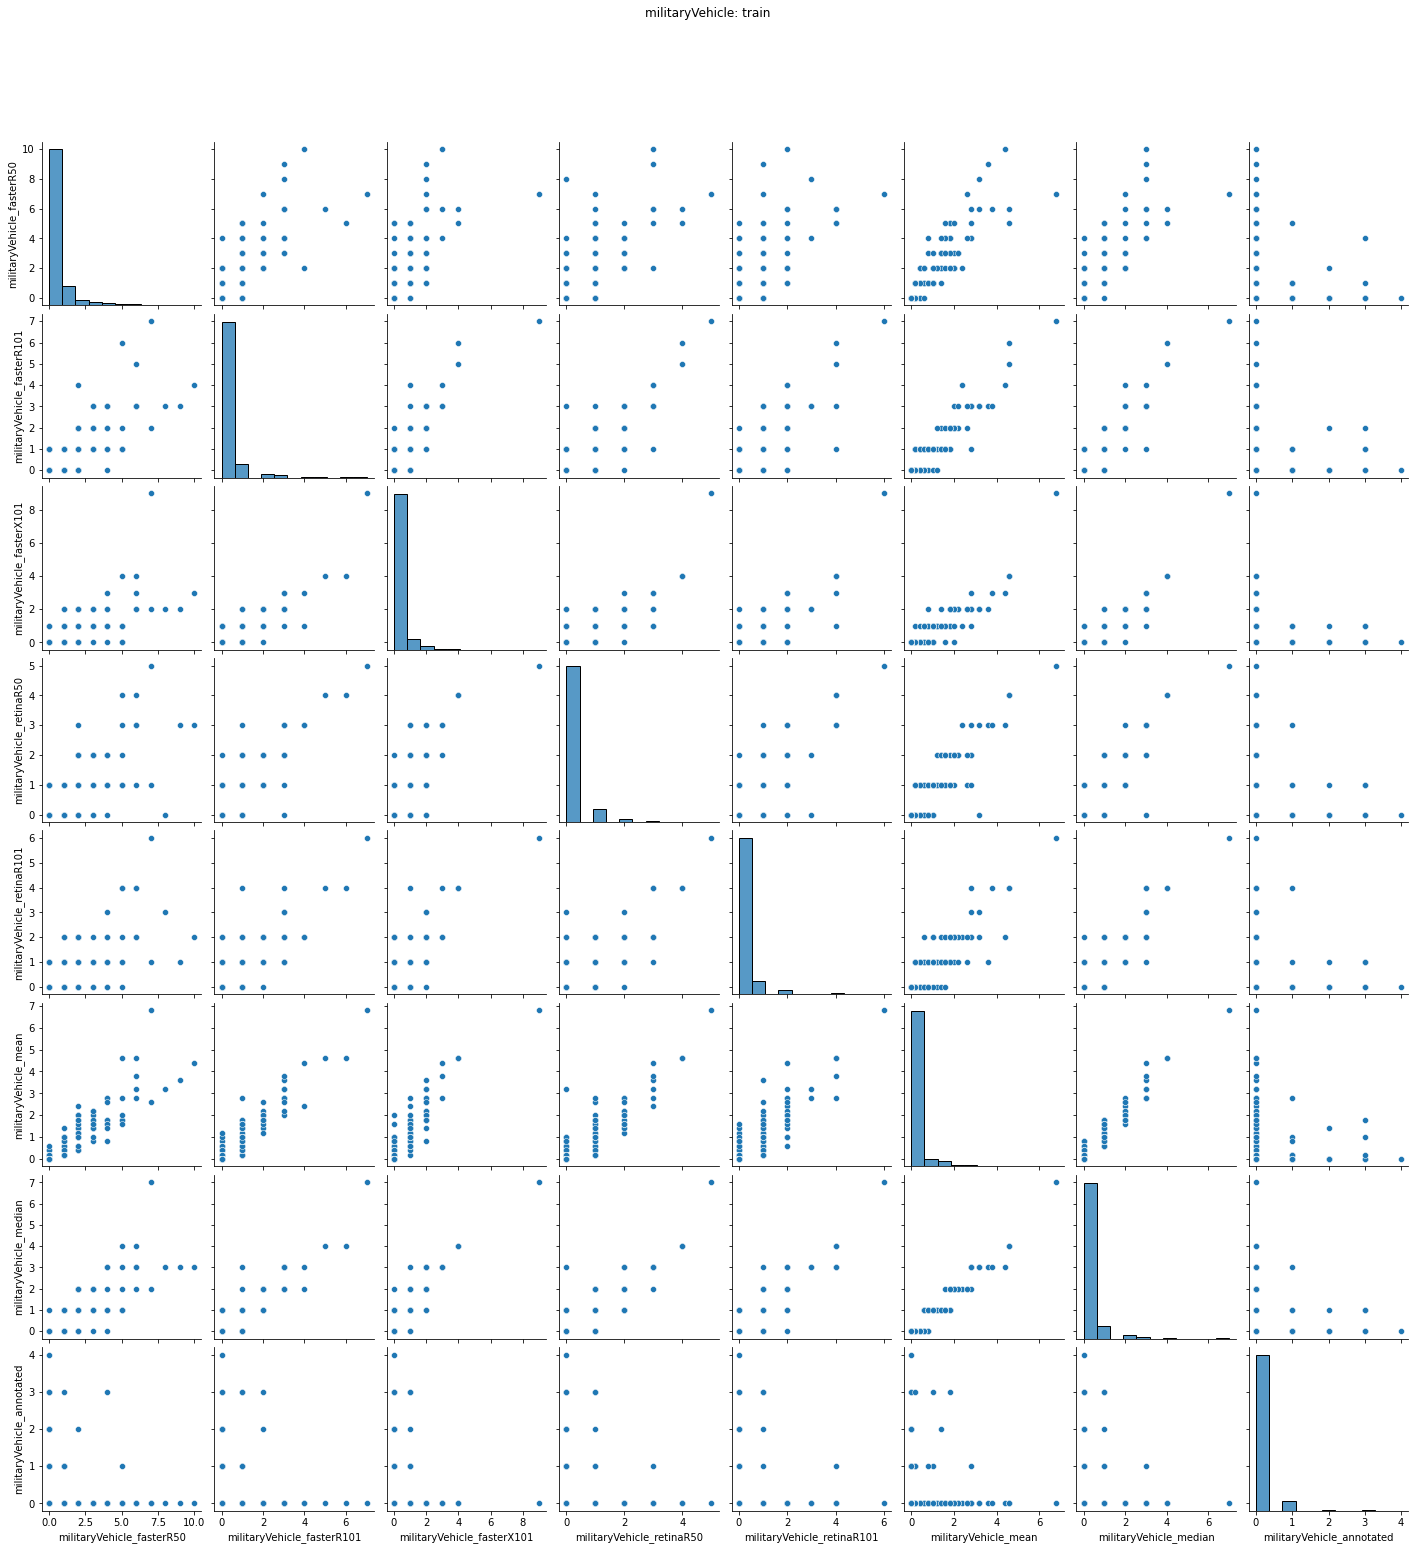

plotting female: train. Dim: (805, 132)


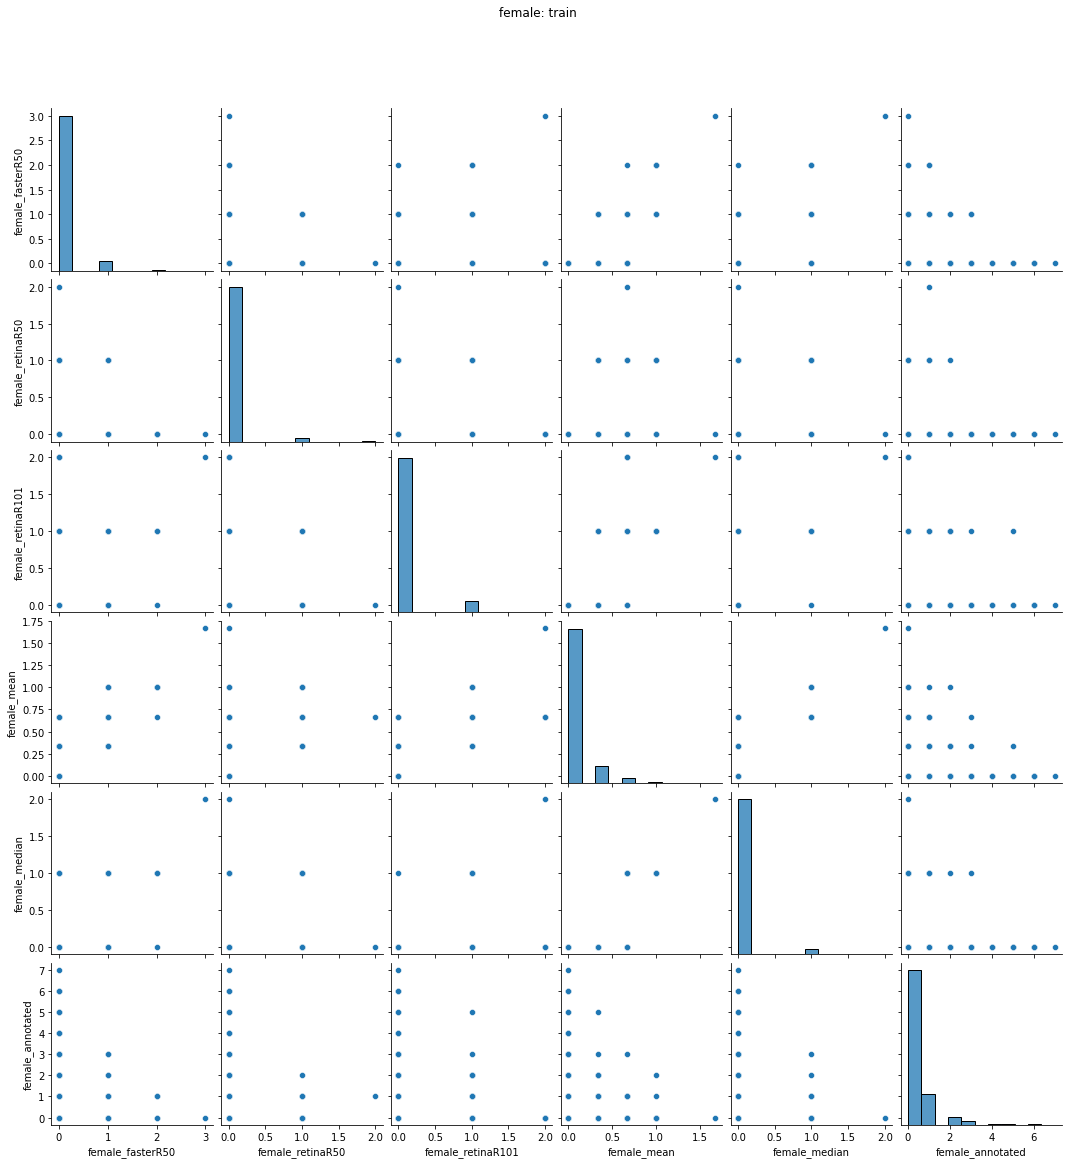

plotting uniformed: train. Dim: (805, 132)


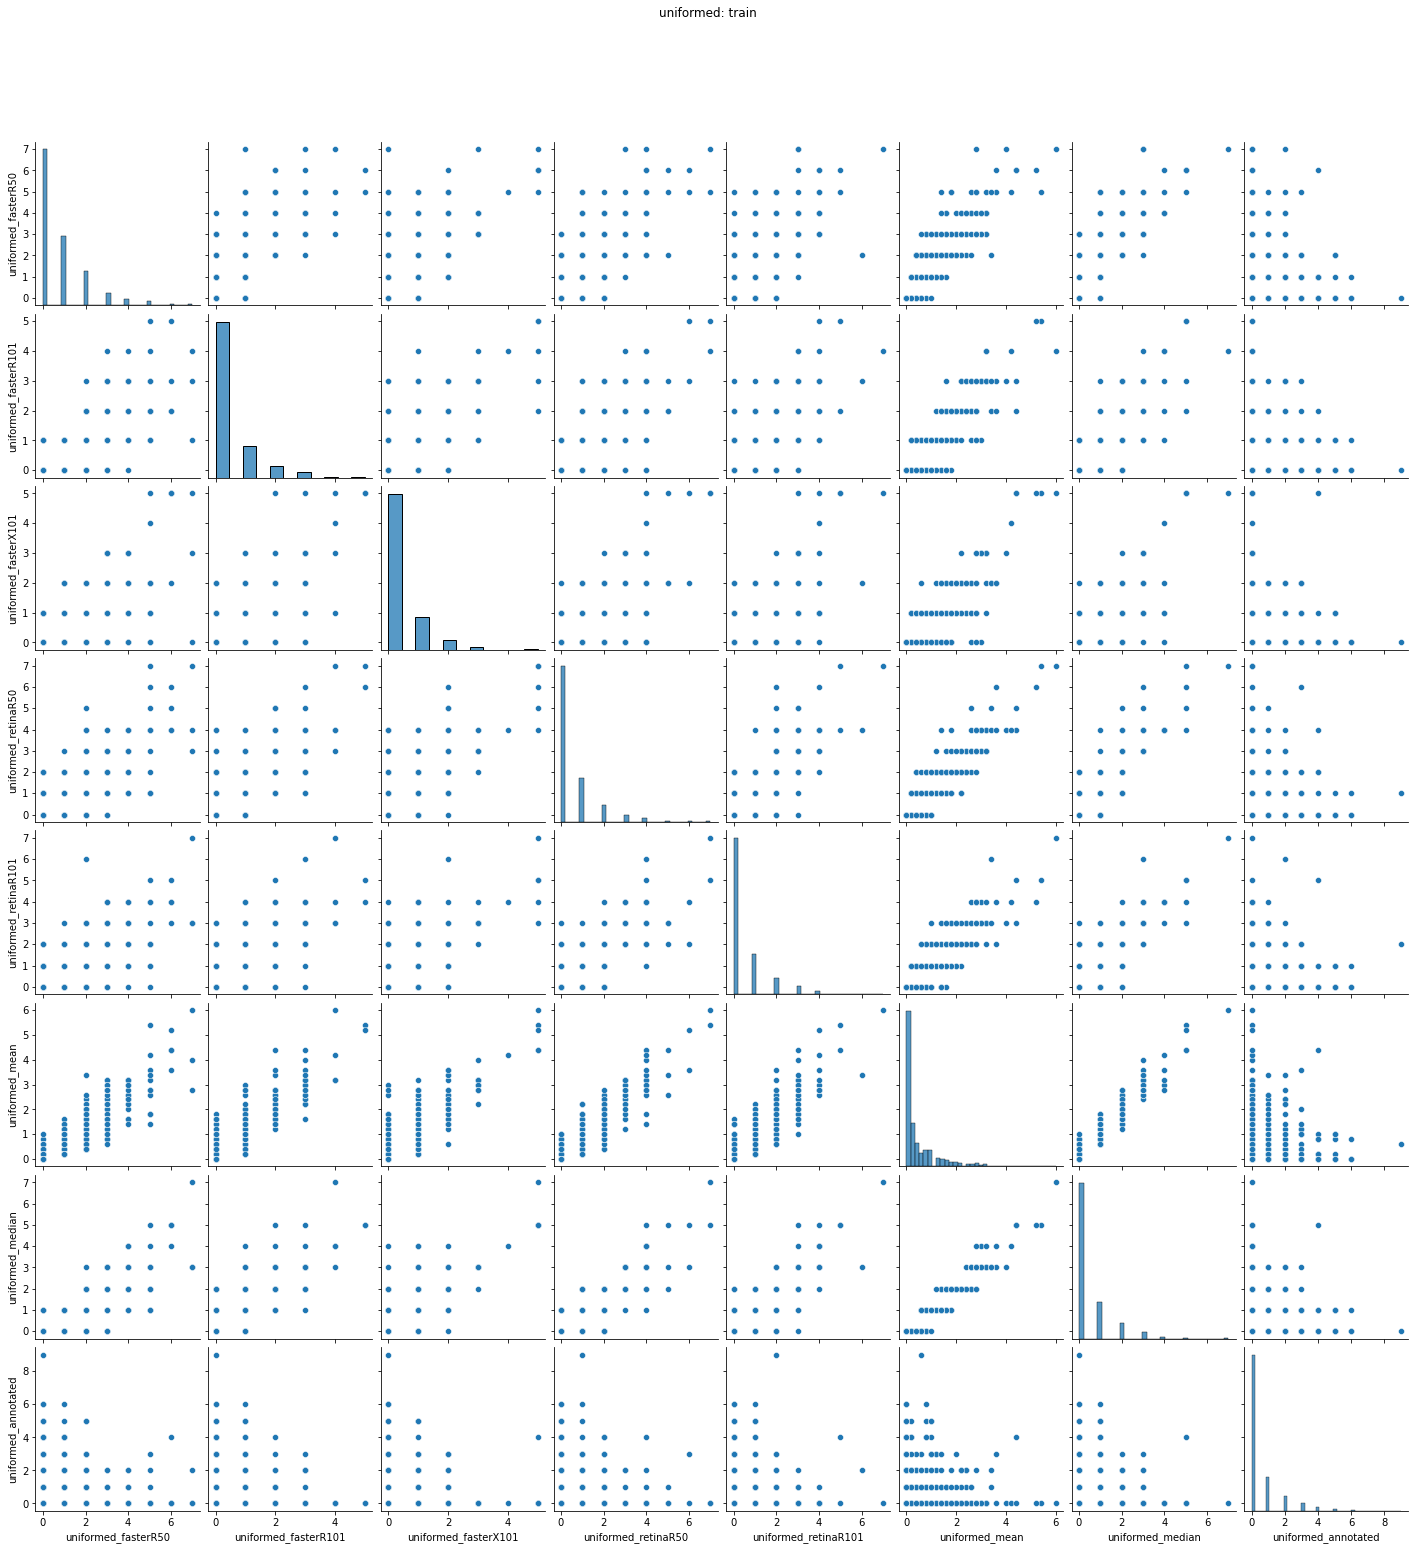

plotting bloodedArea: train. Dim: (805, 132)


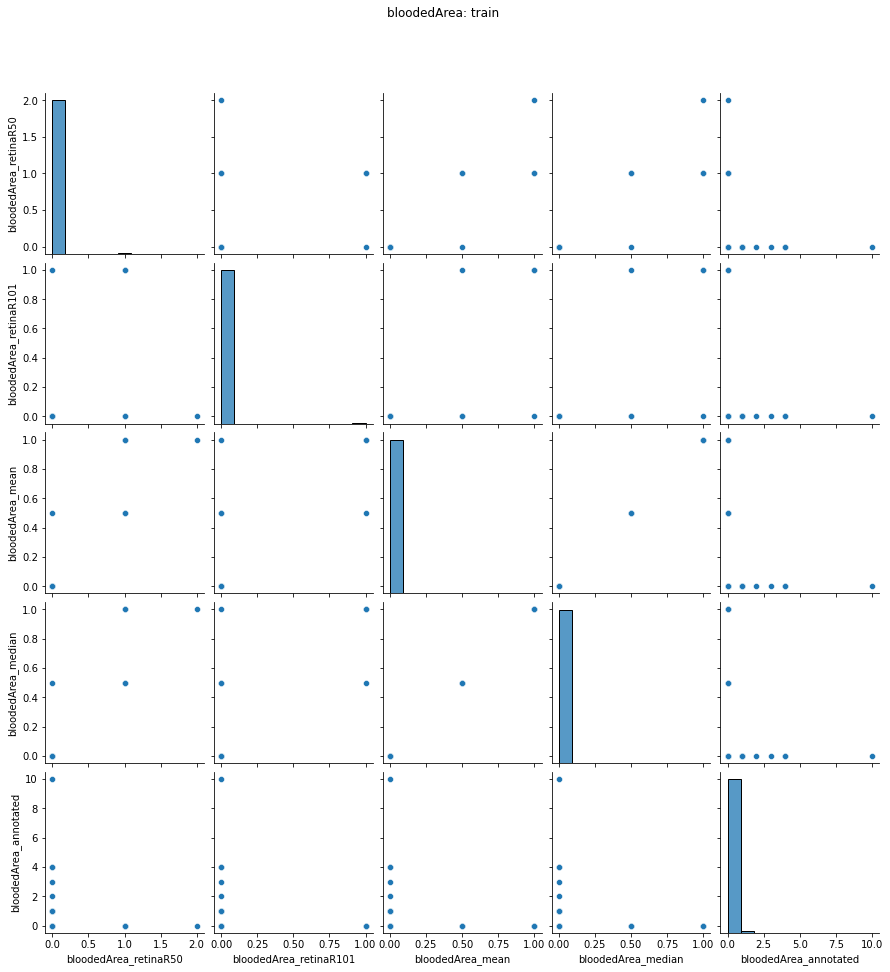

plotting male: train. Dim: (805, 132)


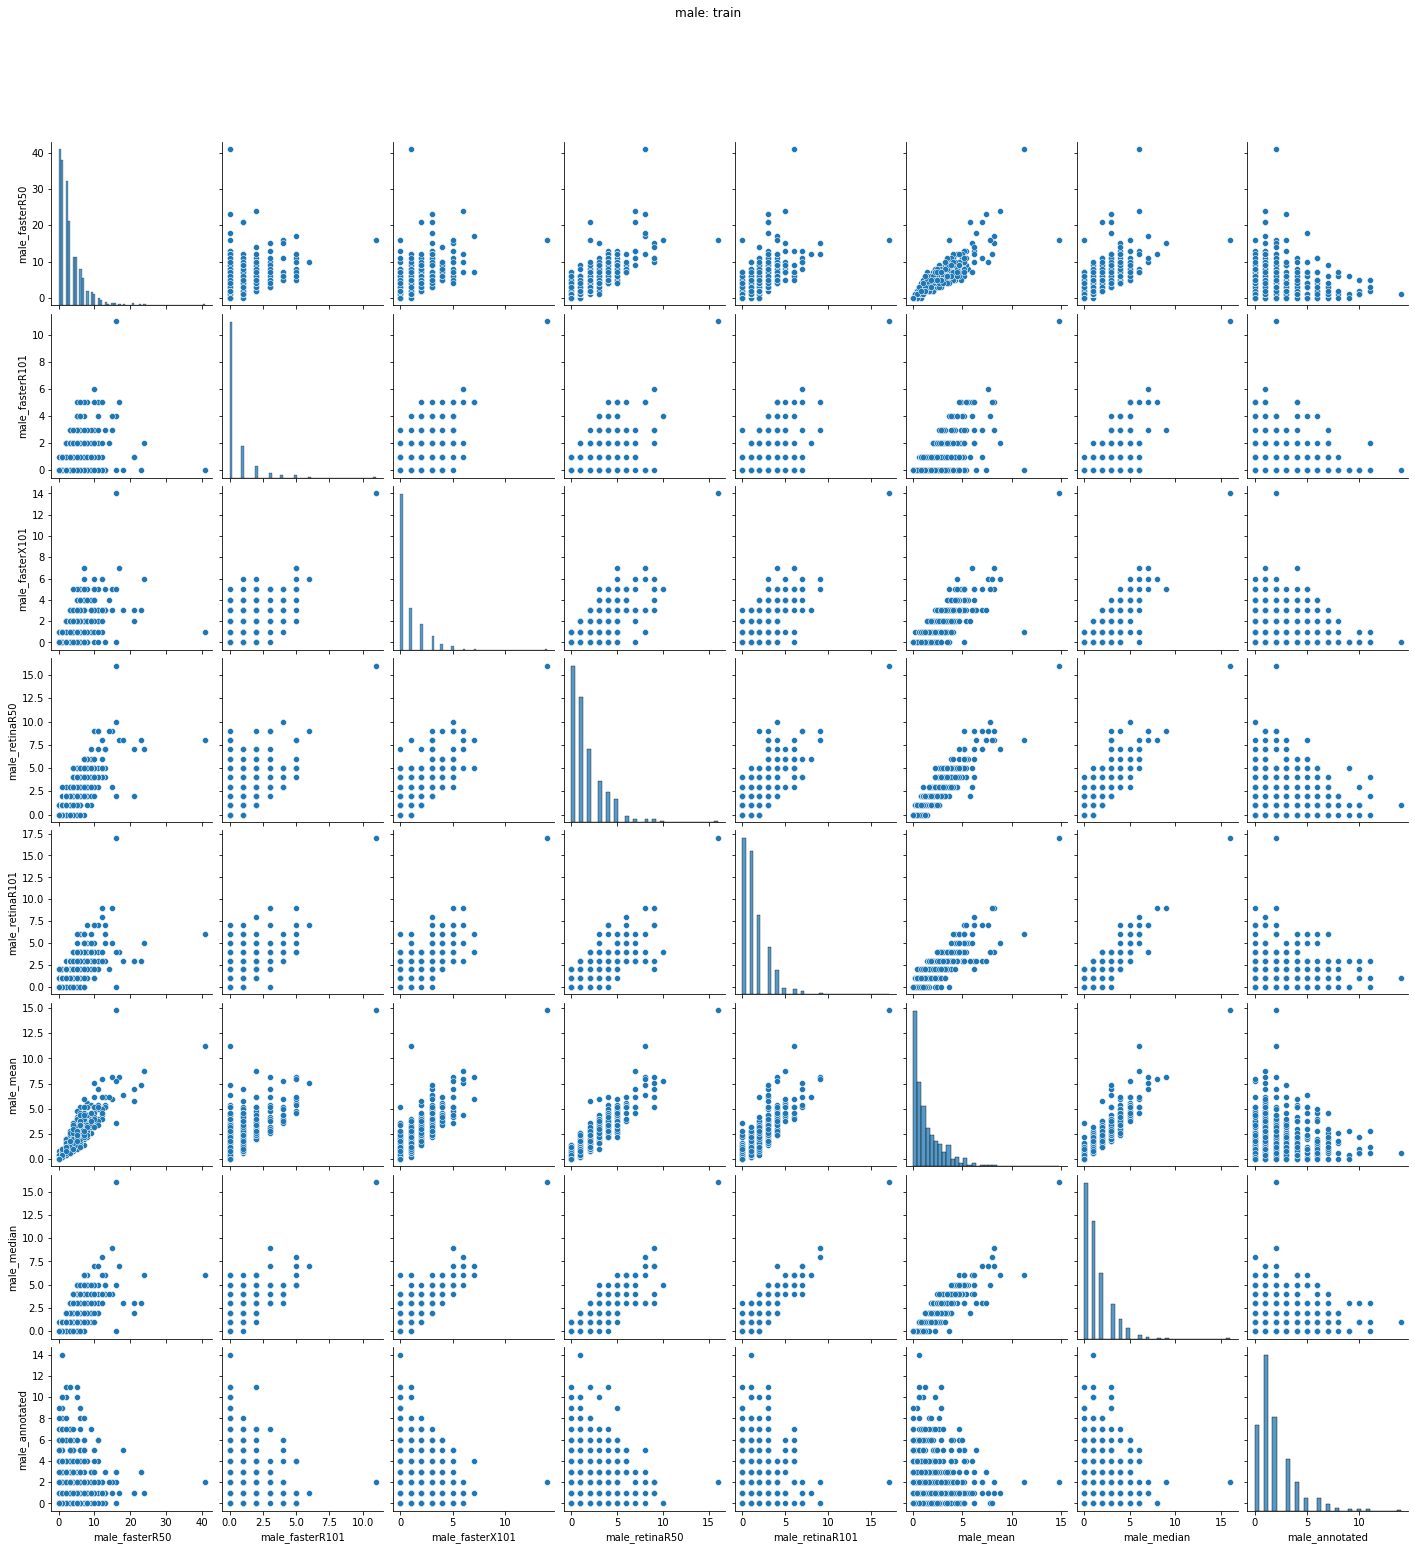

plotting casualty: test. Dim: (202, 132)


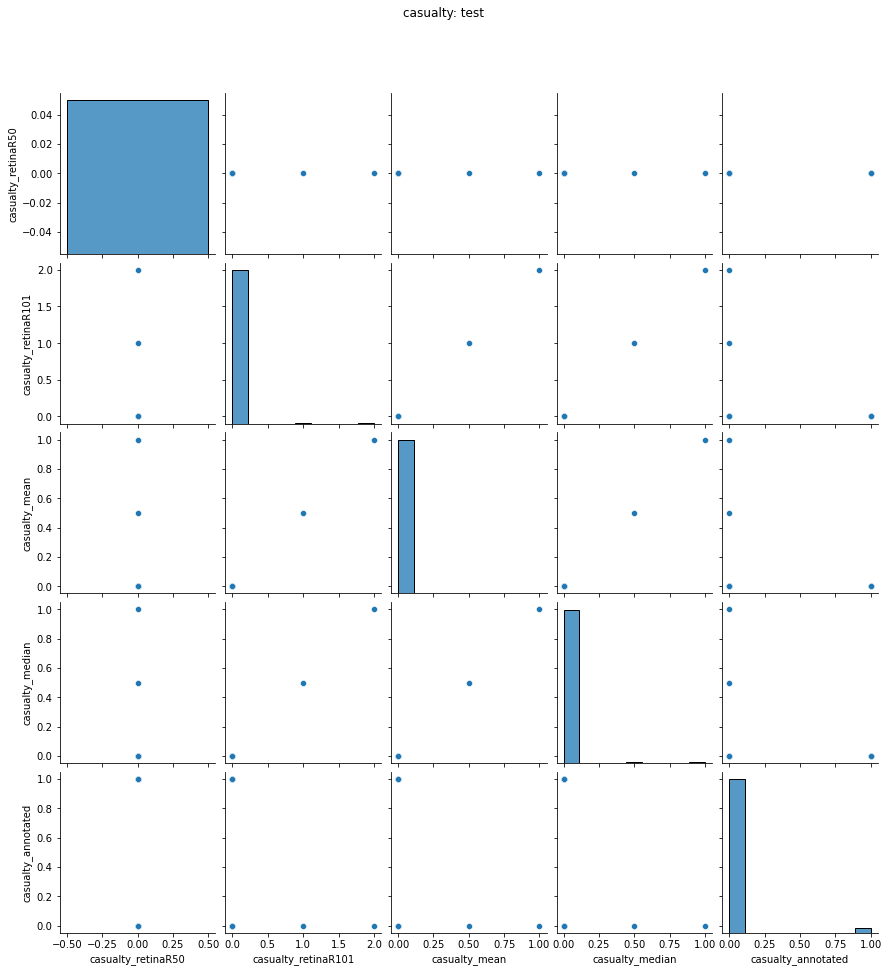

plotting flagUS: test. Dim: (202, 132)


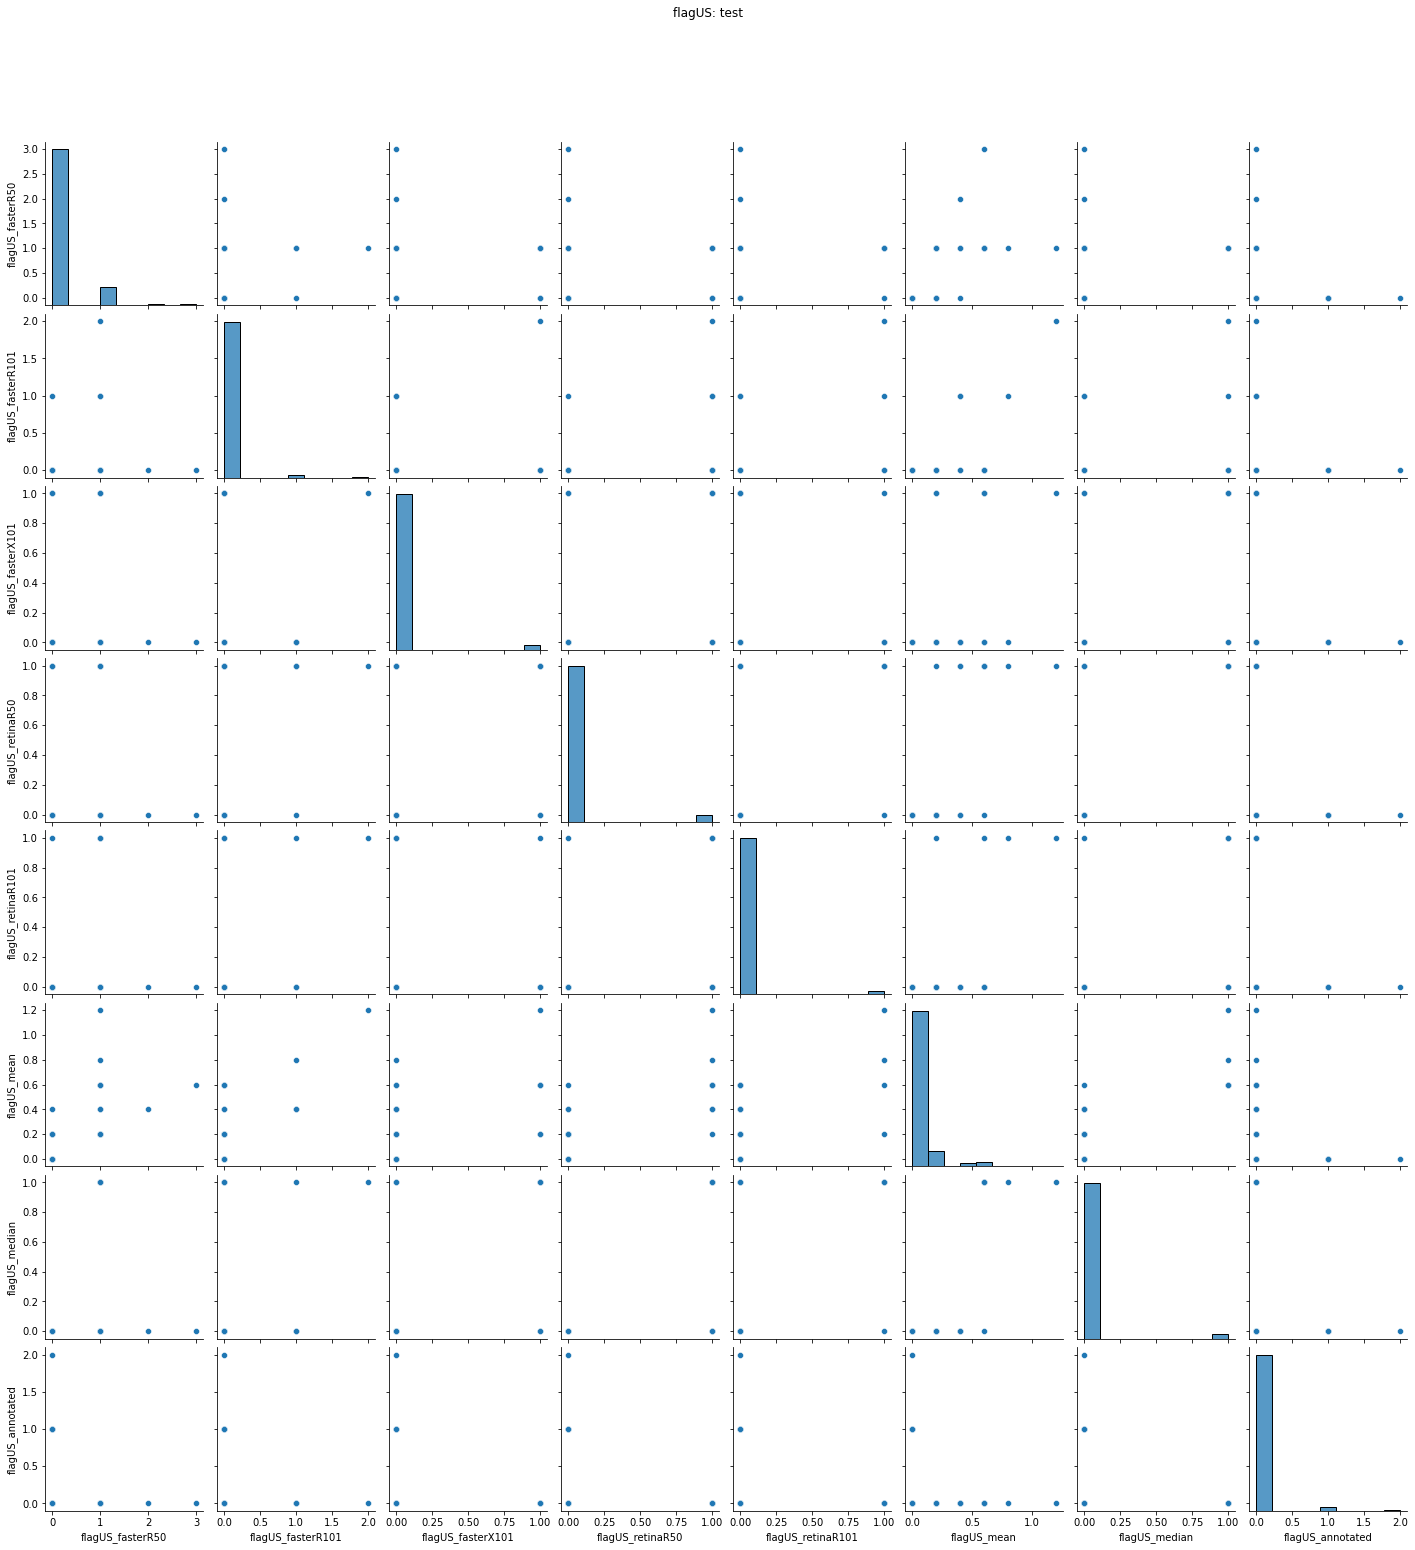

plotting youth: test. Dim: (202, 132)


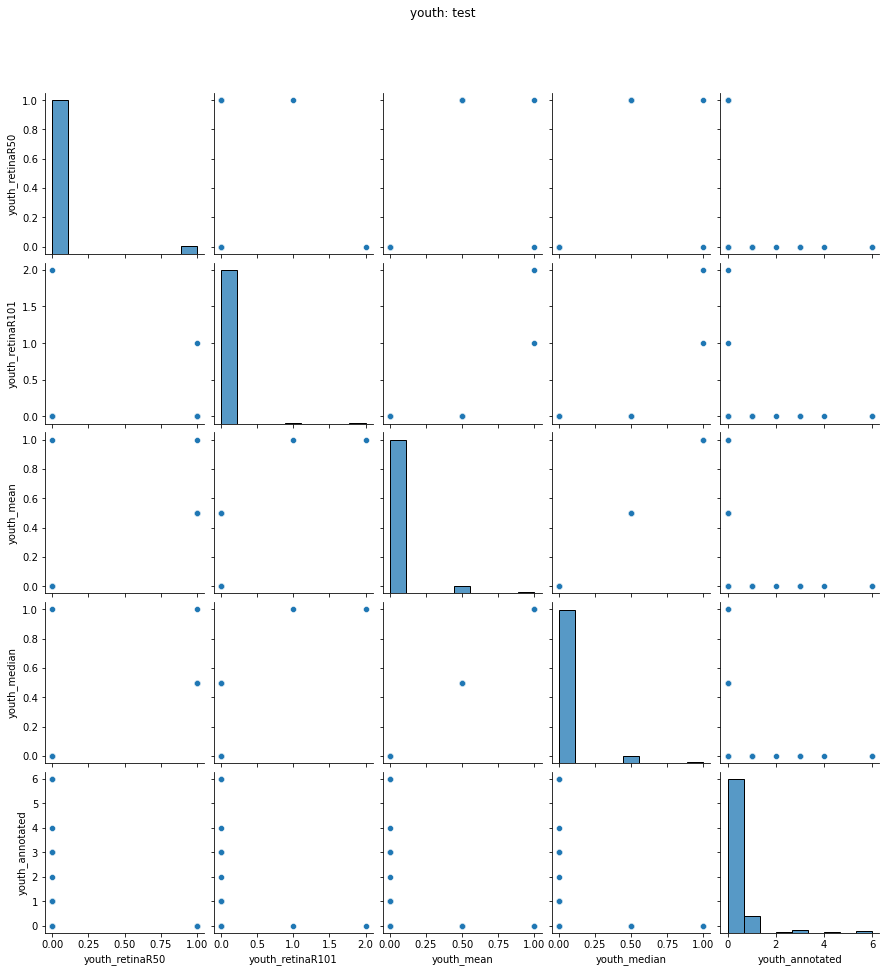

plotting elderly: test. Dim: (202, 132)


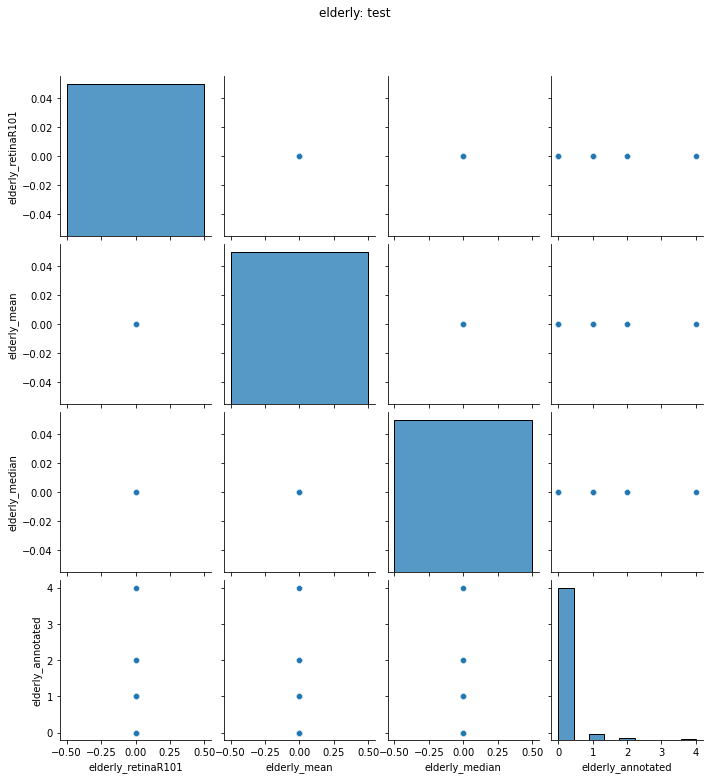

plotting child: test. Dim: (202, 132)


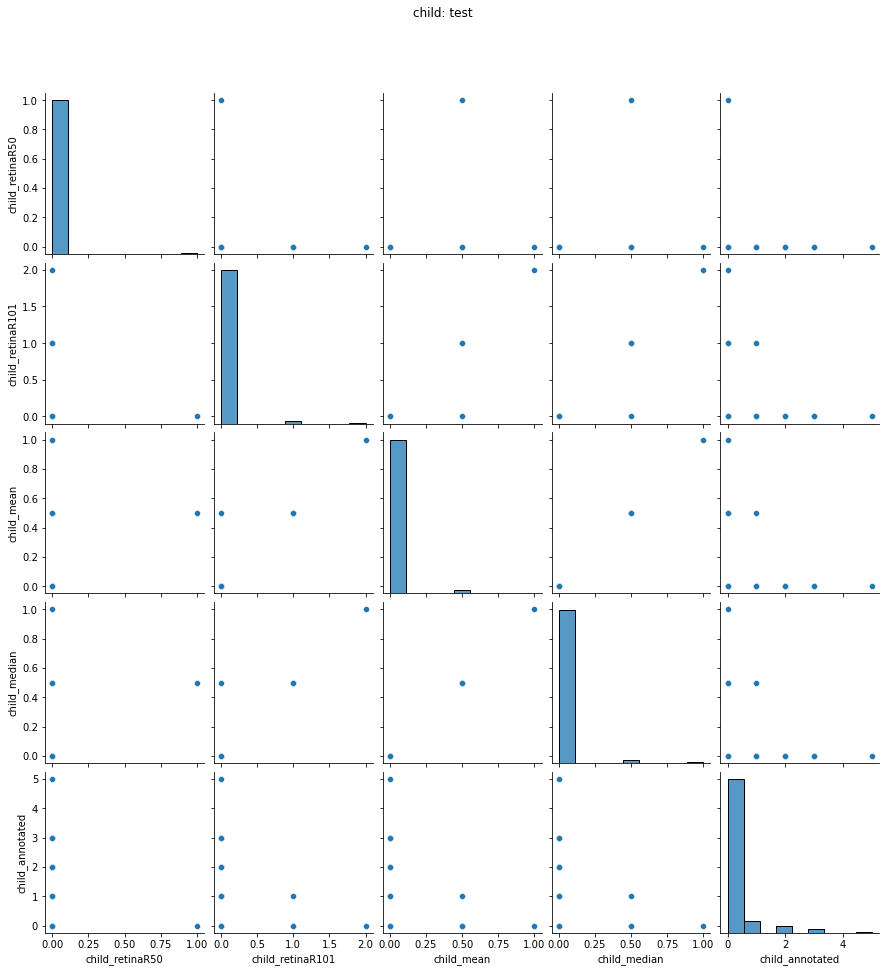

plotting person: test. Dim: (202, 132)


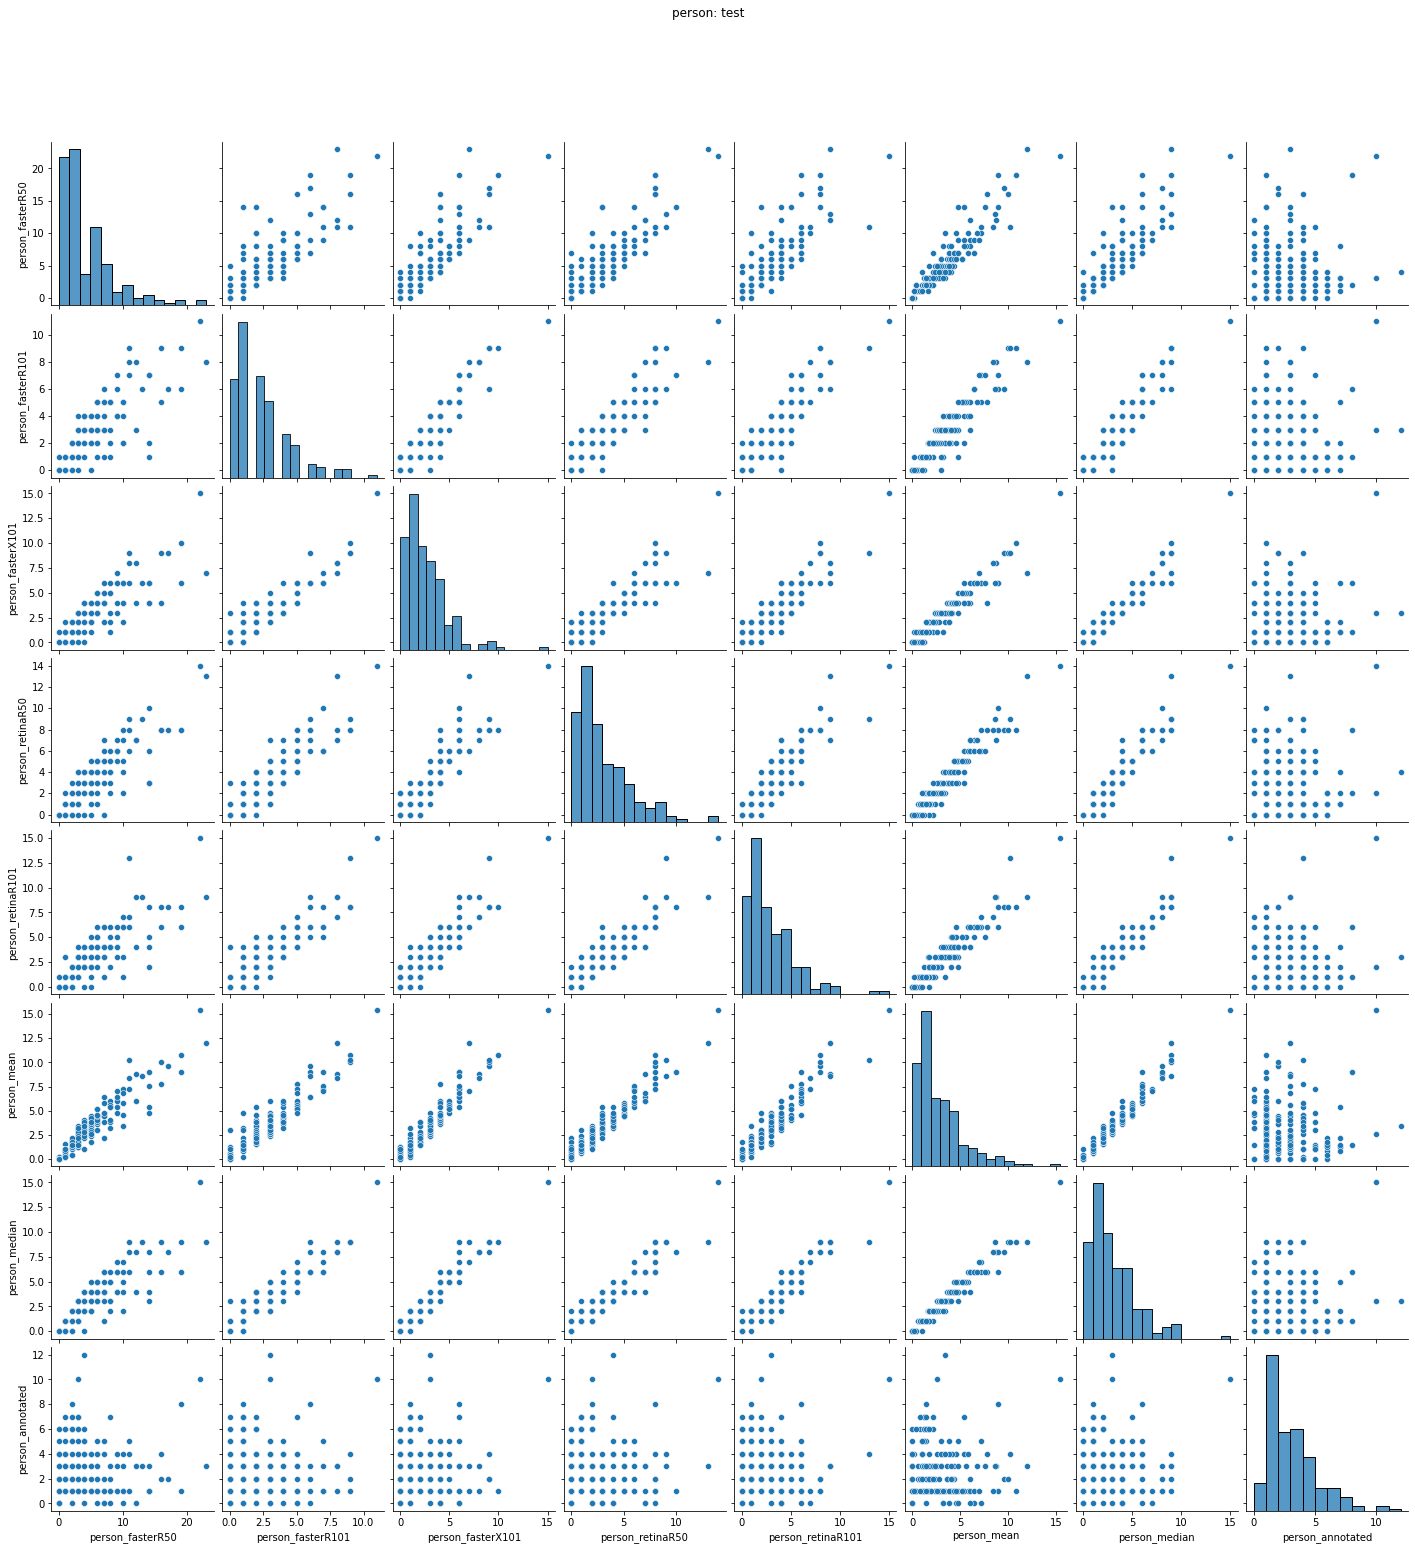

plotting hostage: test. Dim: (202, 132)


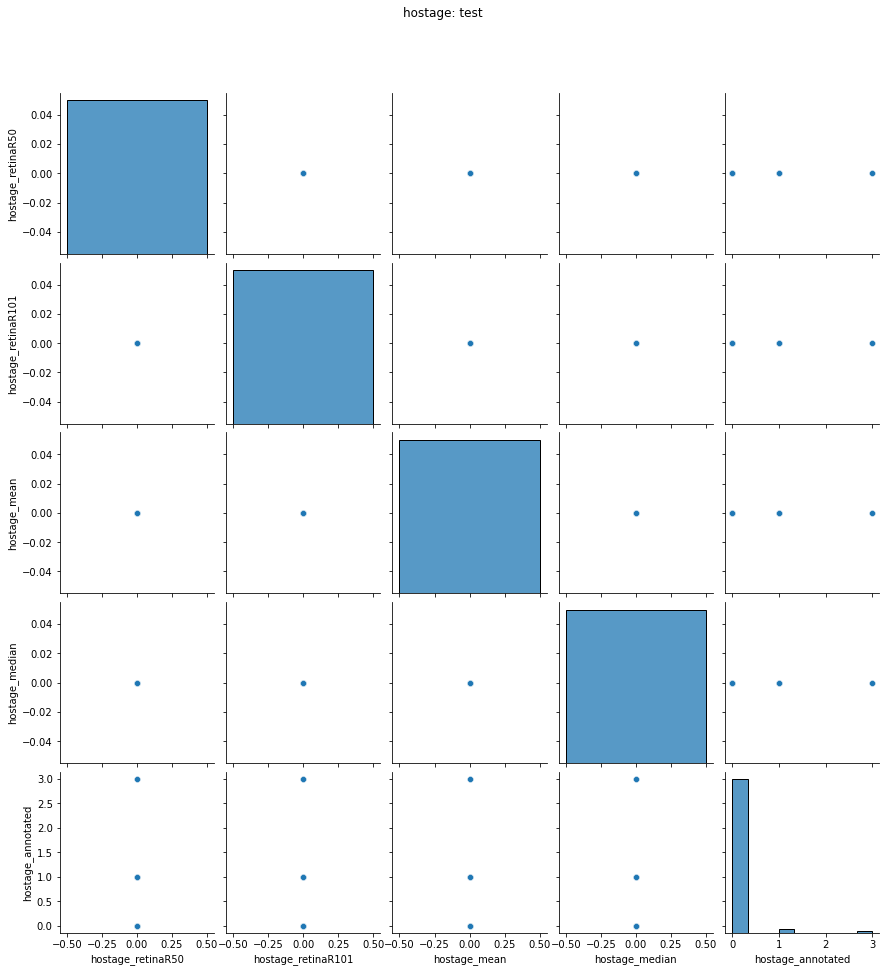

plotting adult: test. Dim: (202, 132)


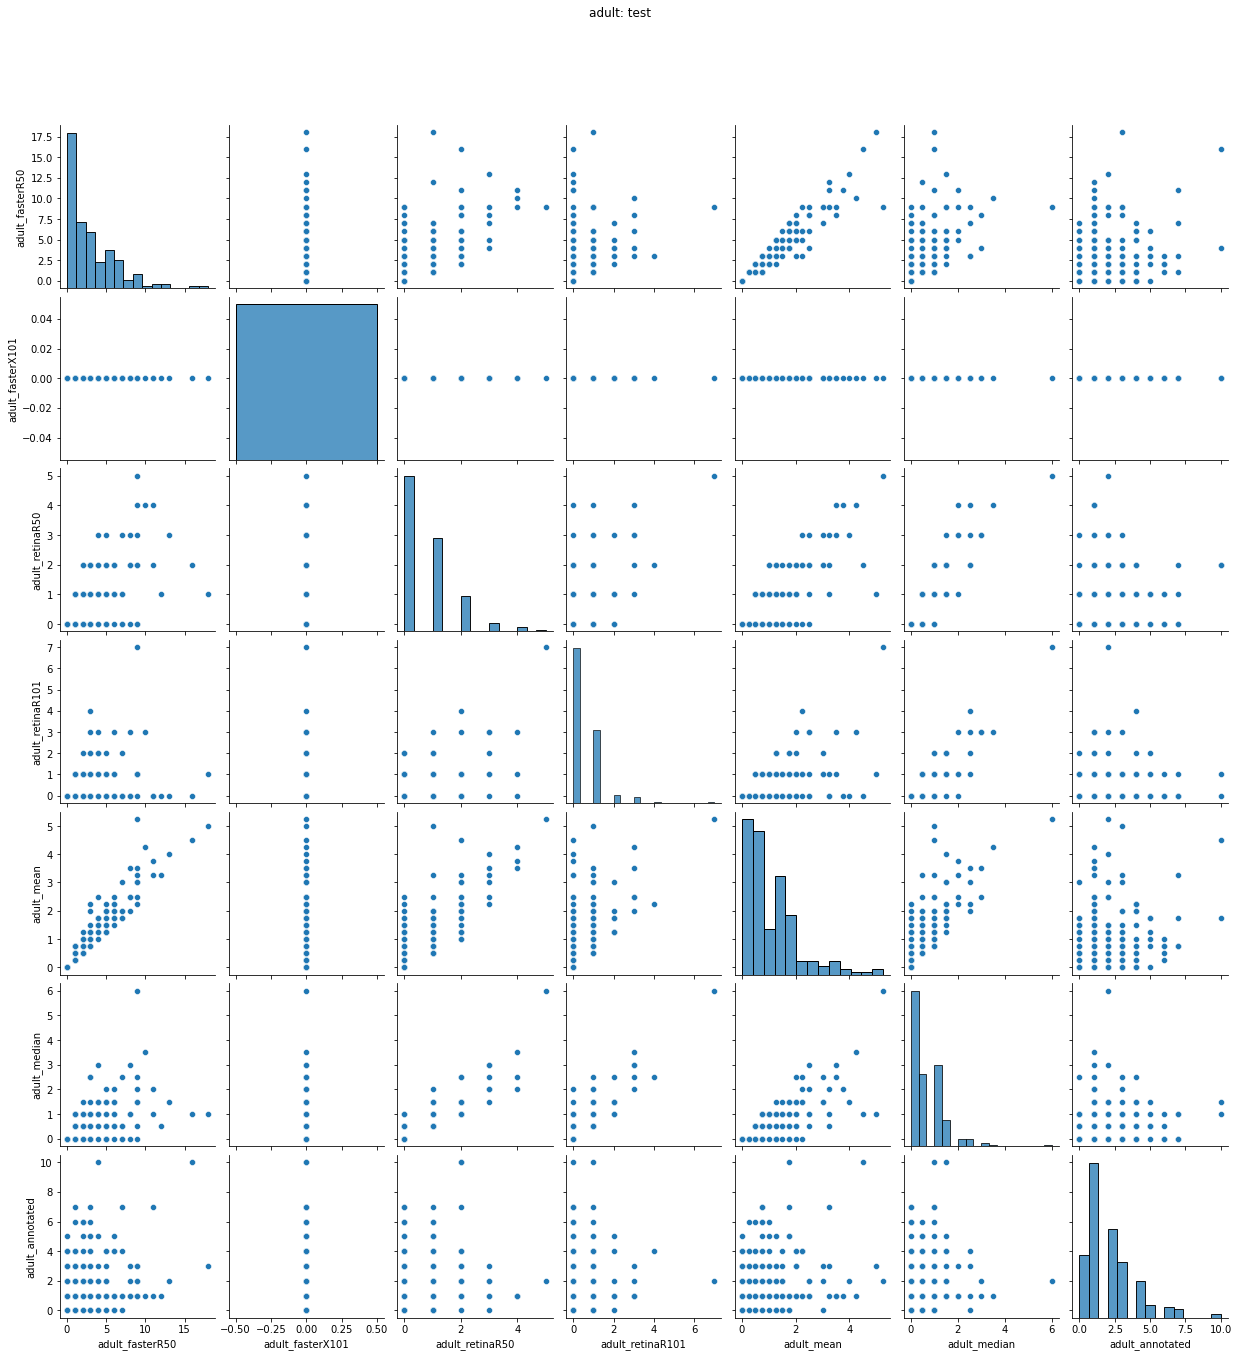

plotting religiousGarmentFemale: test. Dim: (202, 132)


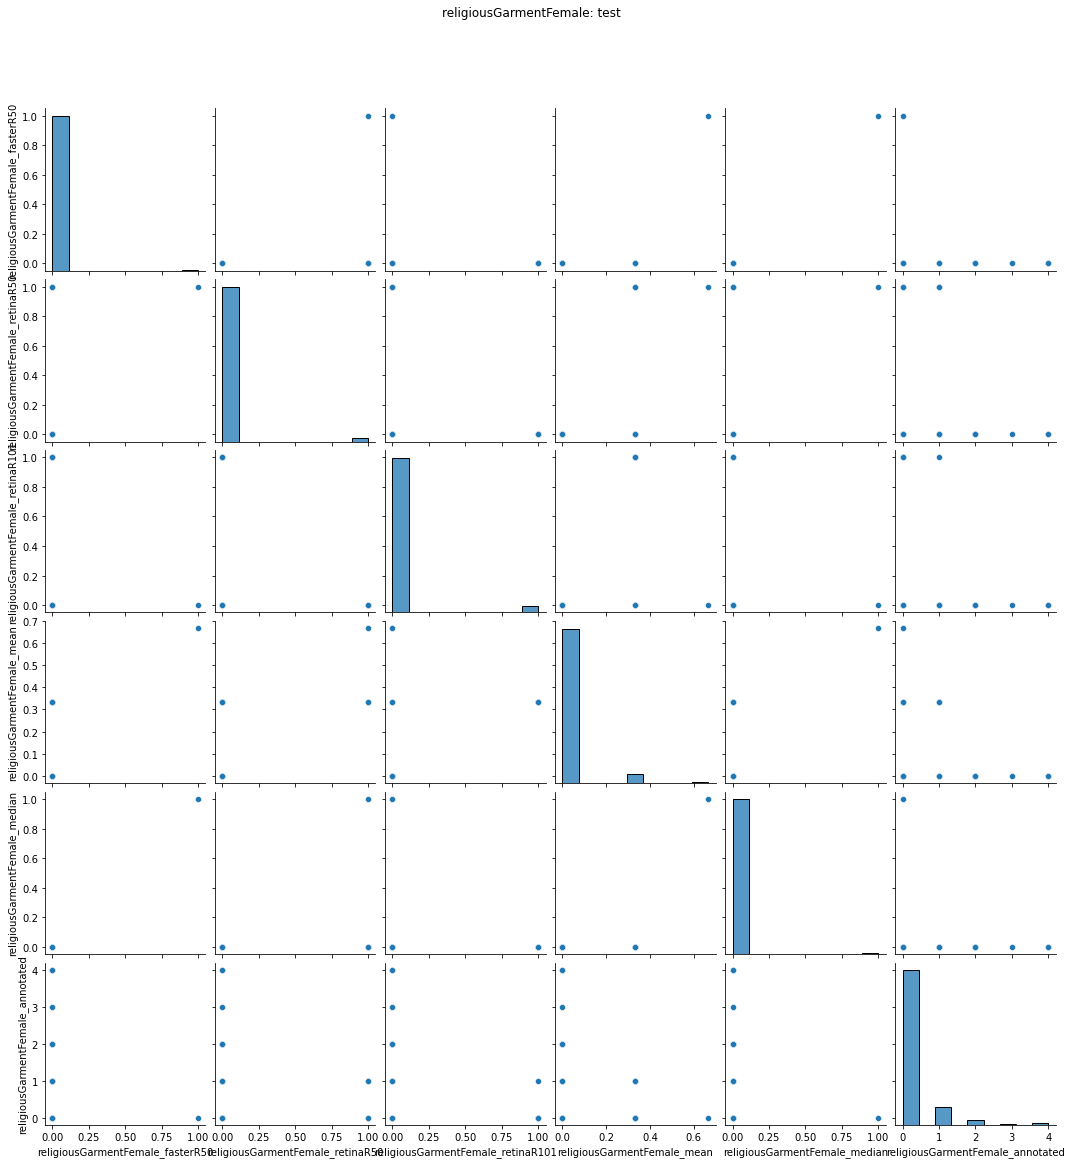

plotting firearm: test. Dim: (202, 132)


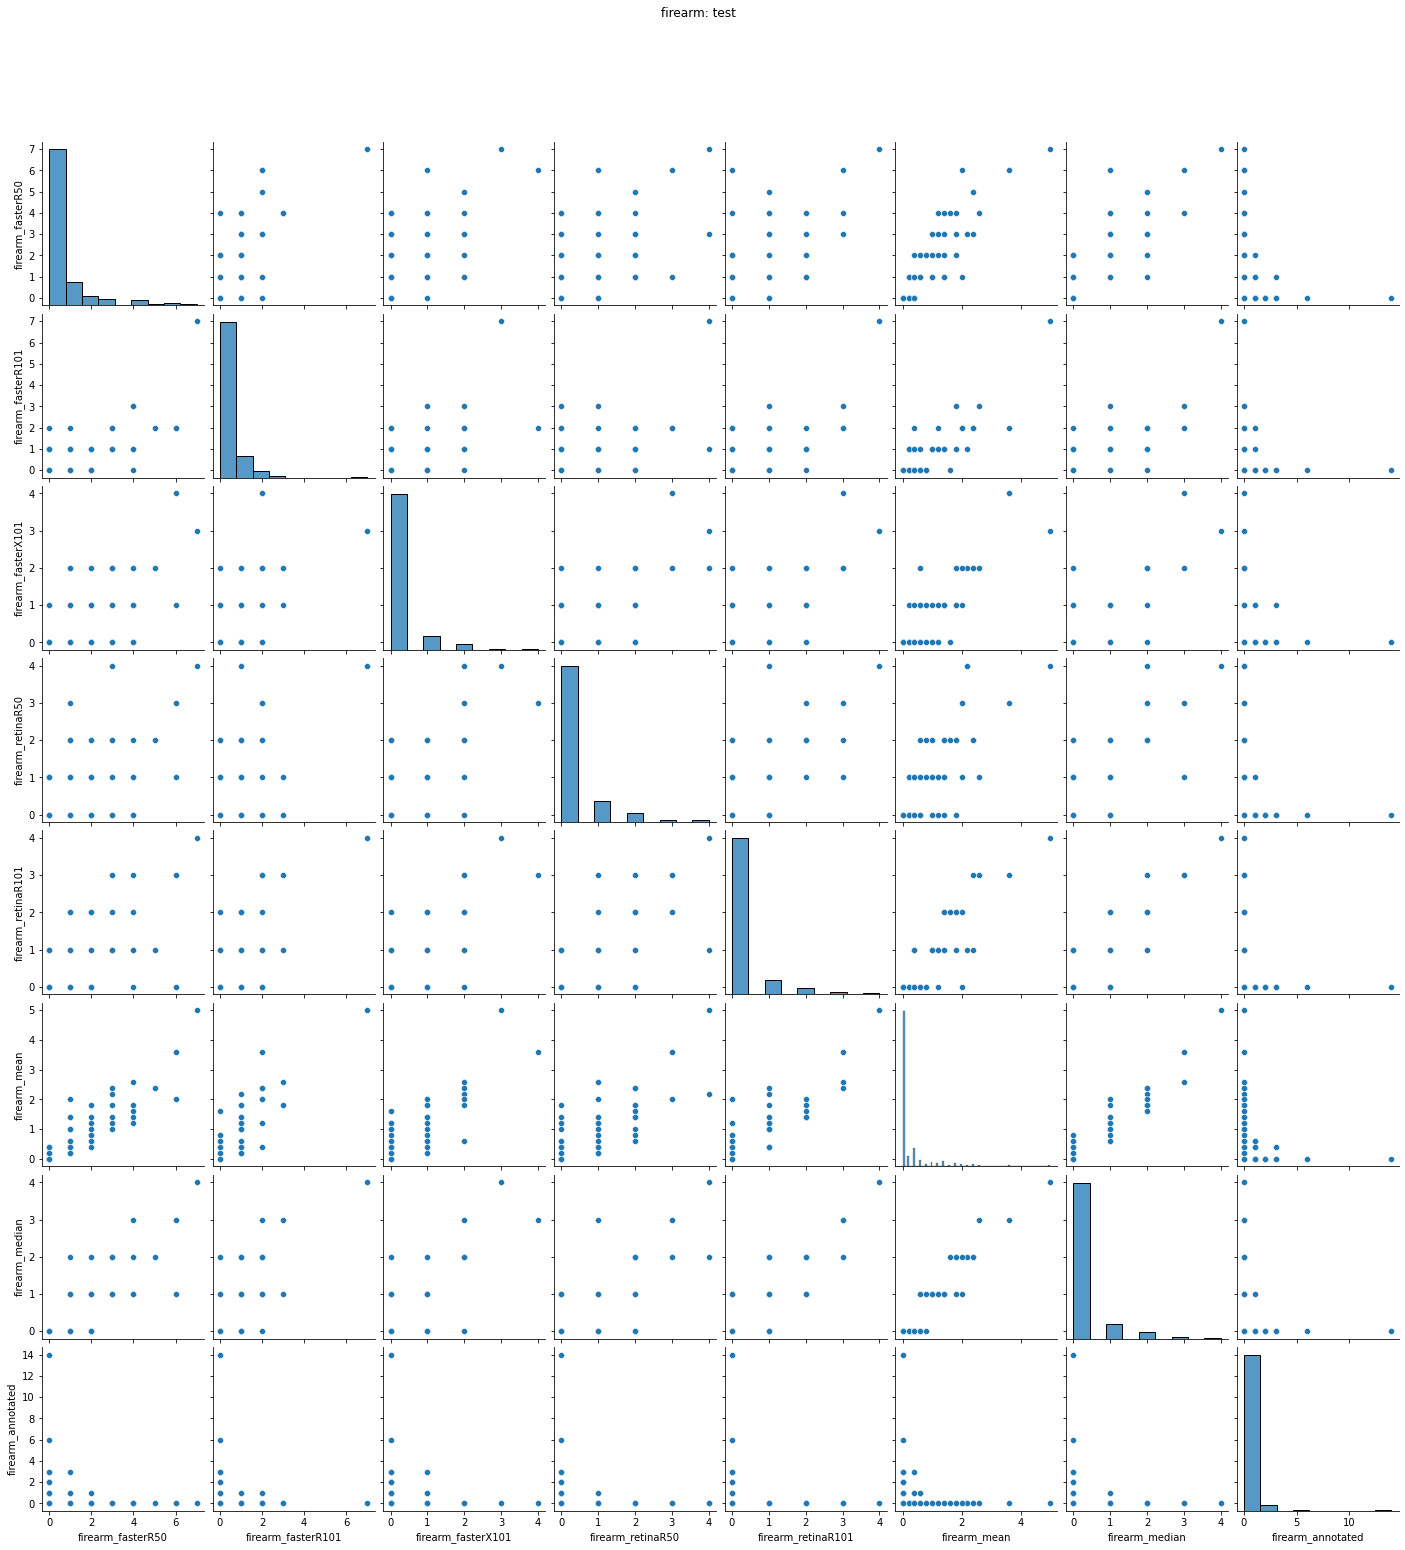

plotting falgIRQ: test. Dim: (202, 132)


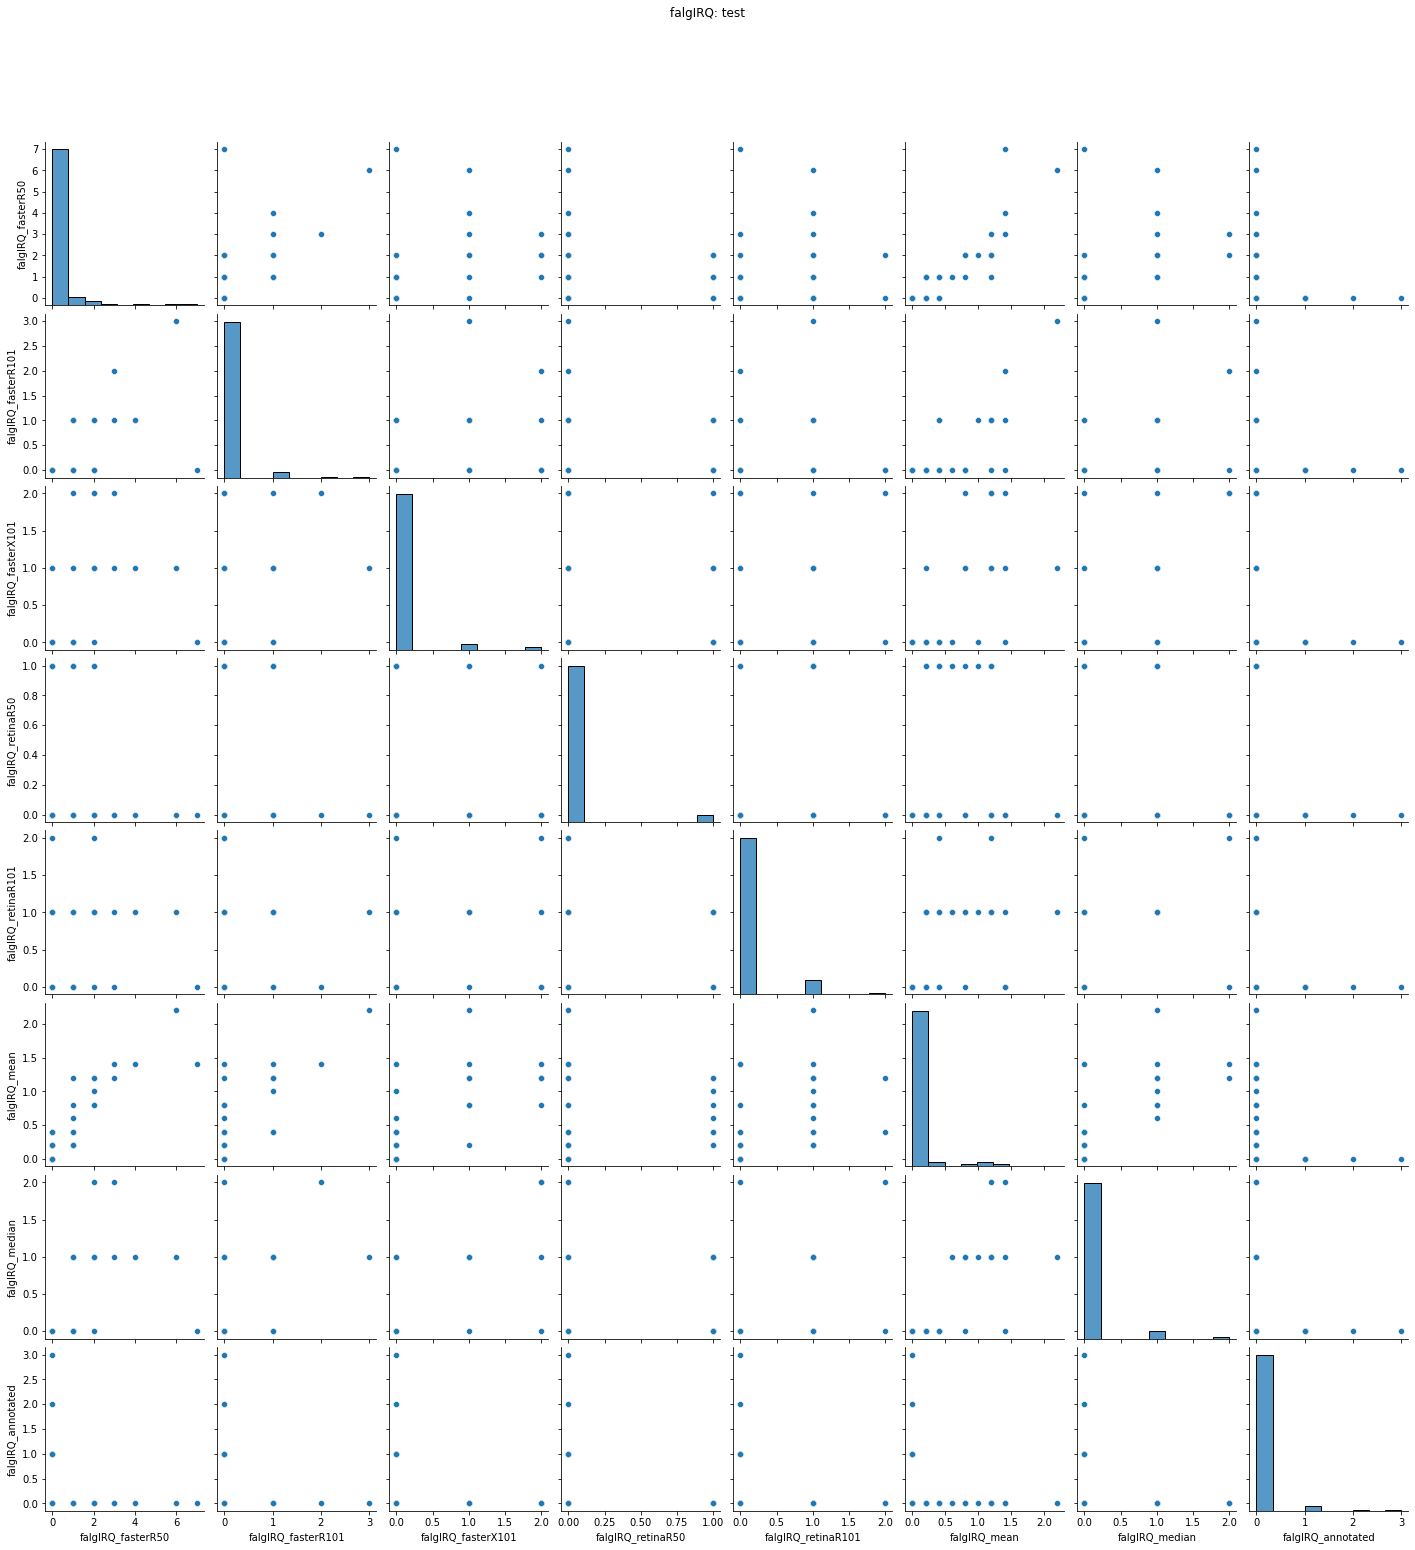

plotting militaryVehicle: test. Dim: (202, 132)


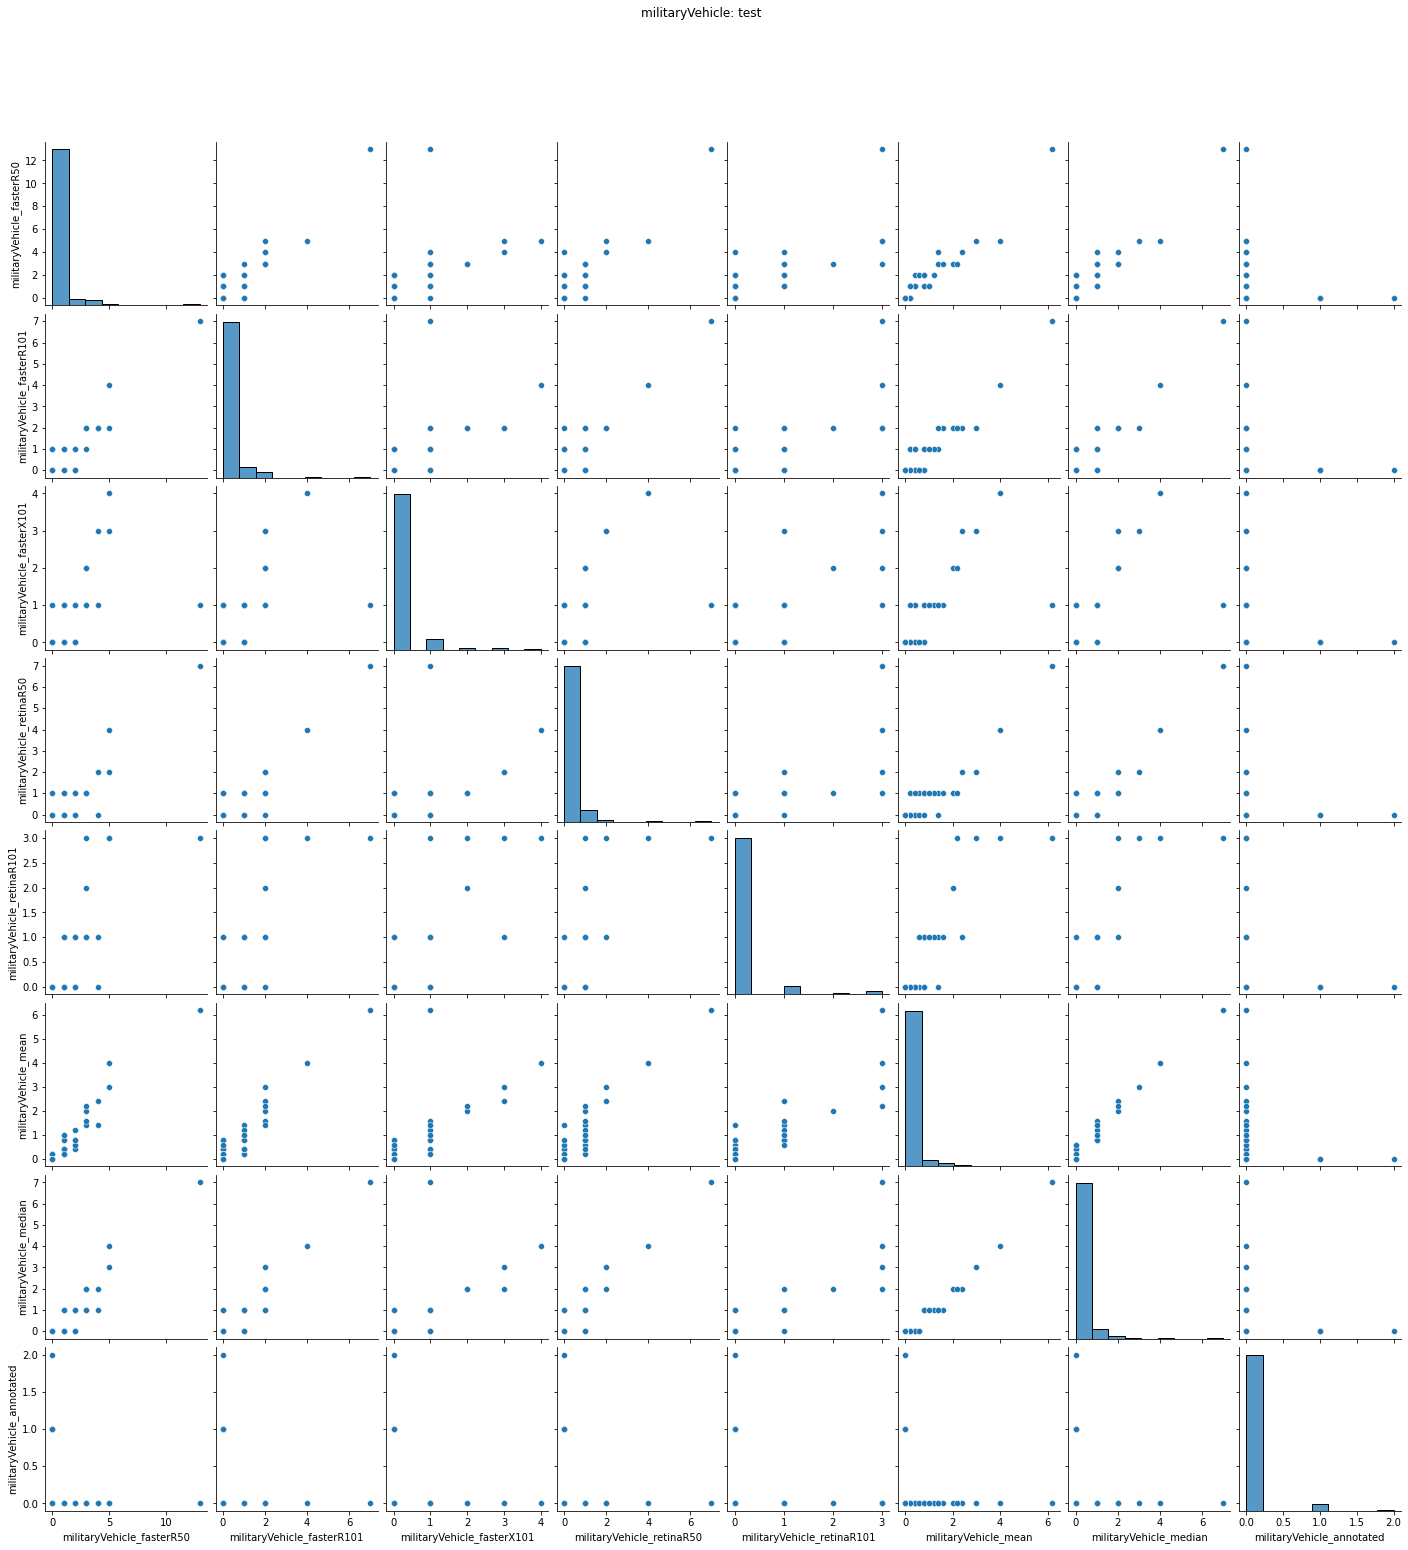

plotting female: test. Dim: (202, 132)


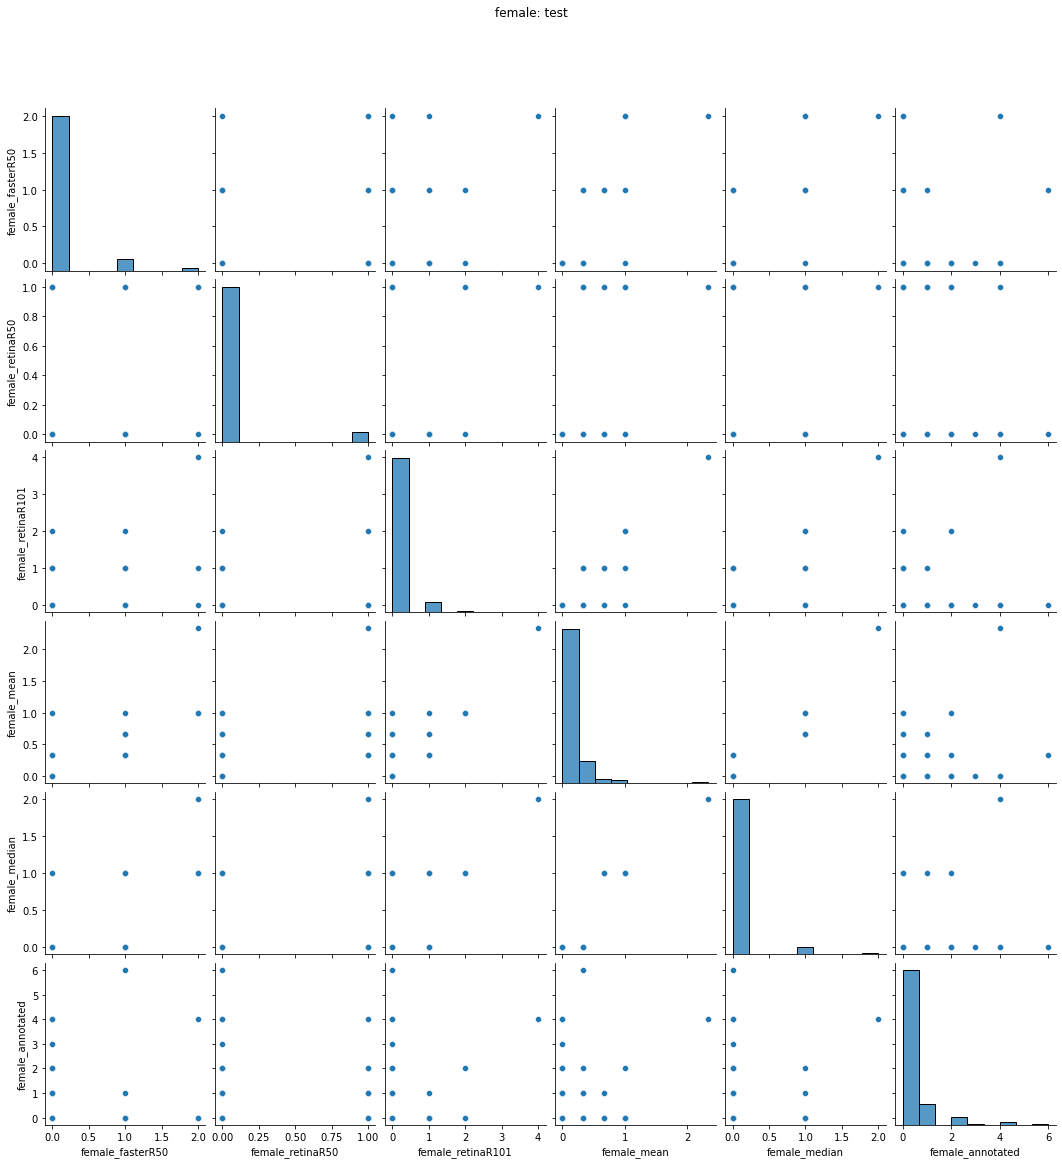

plotting uniformed: test. Dim: (202, 132)


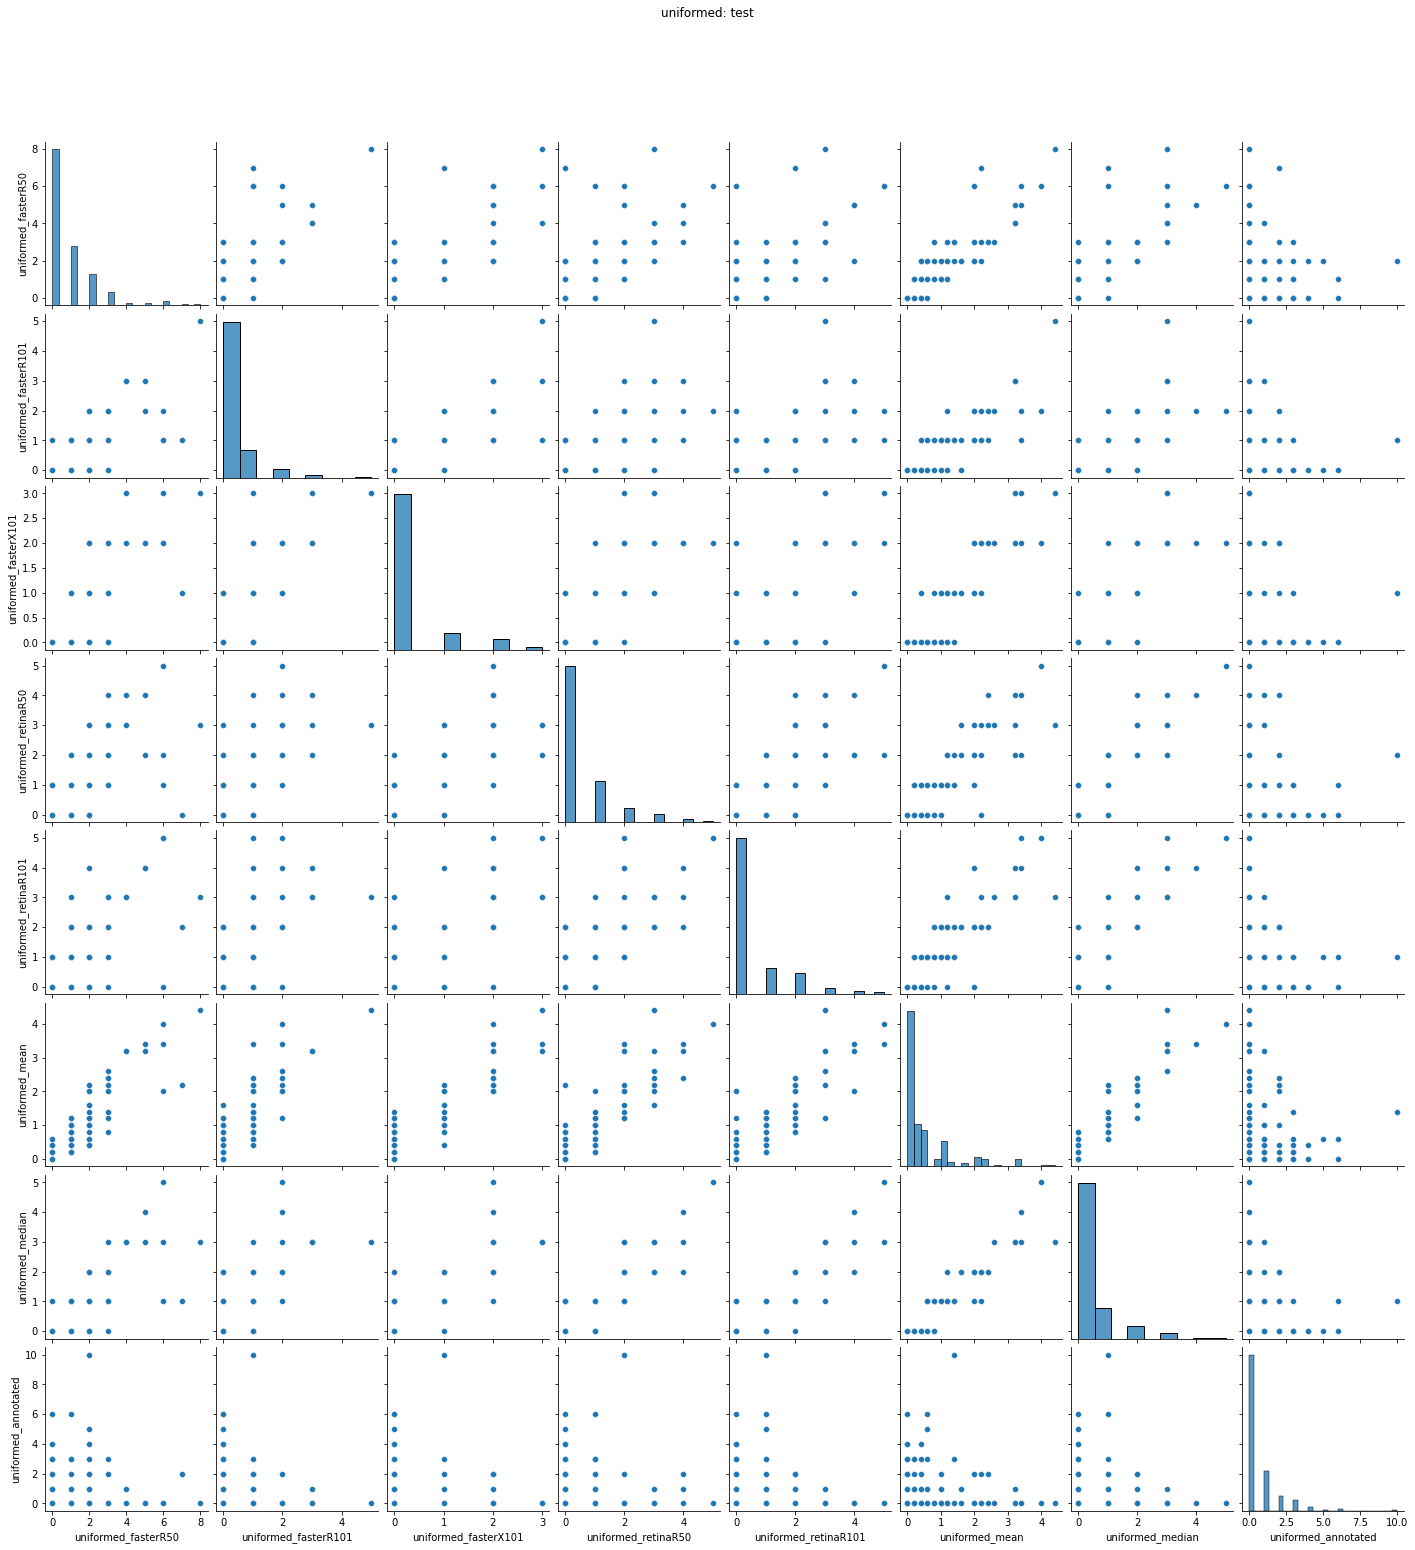

plotting bloodedArea: test. Dim: (202, 132)


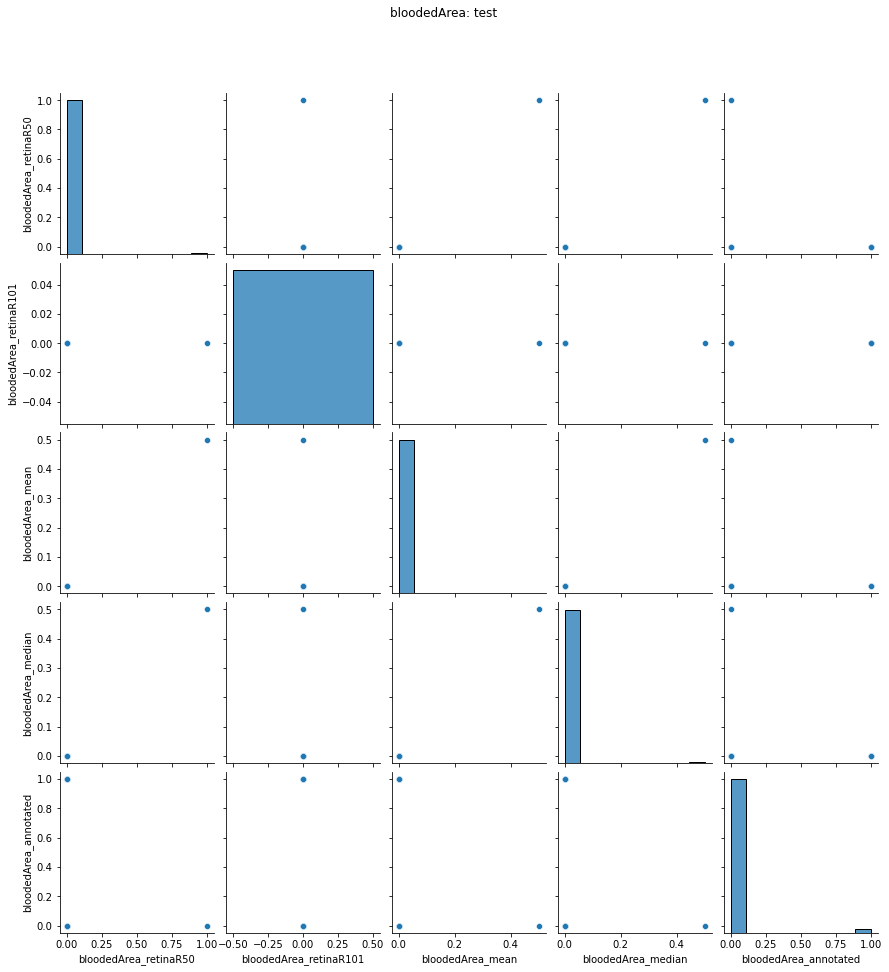

plotting male: test. Dim: (202, 132)


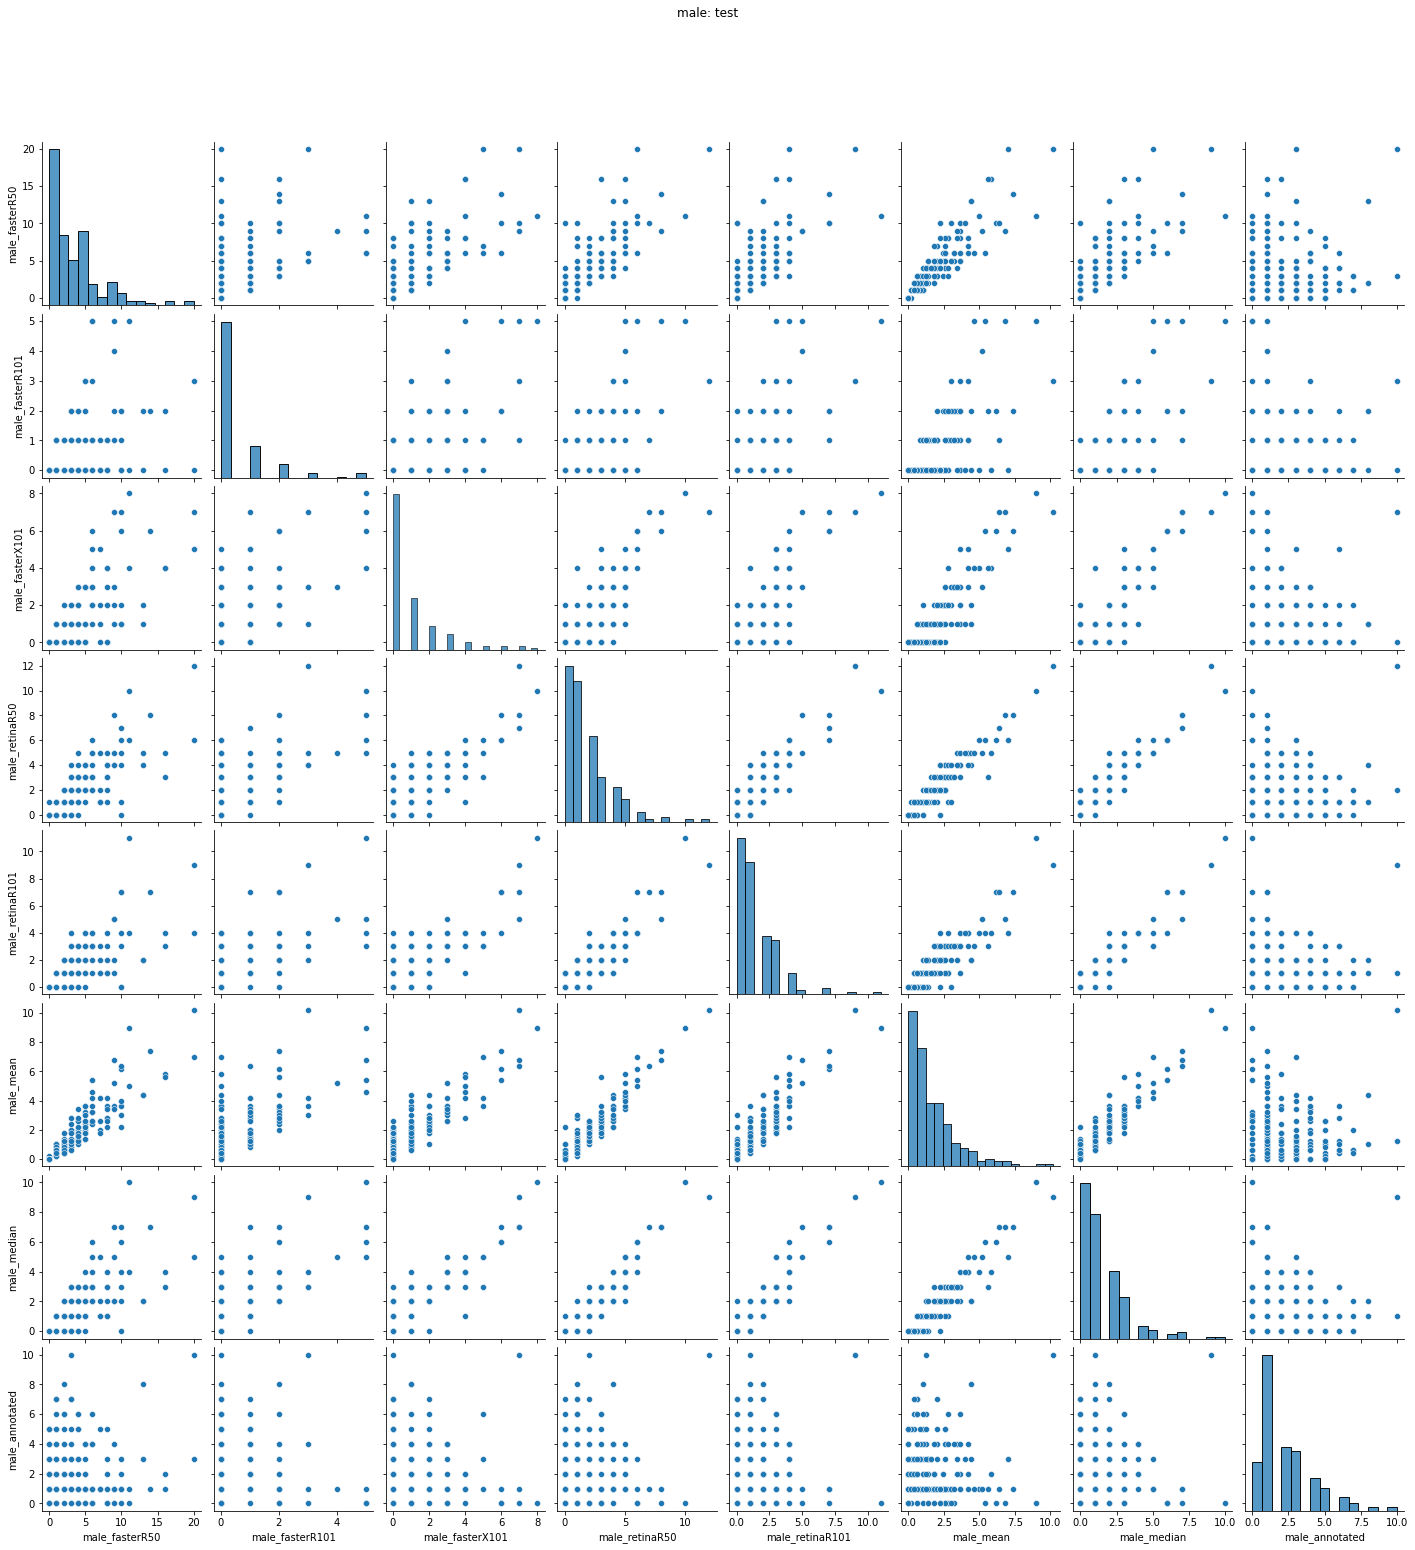

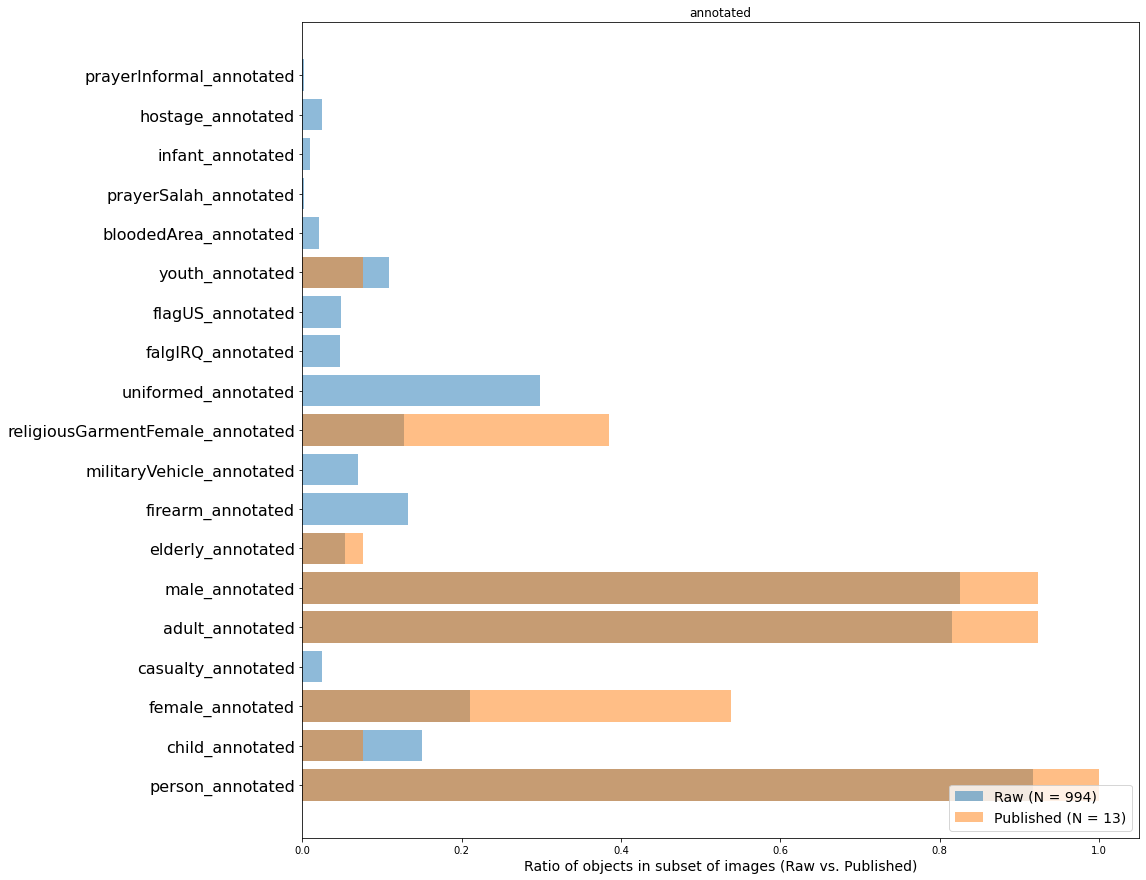

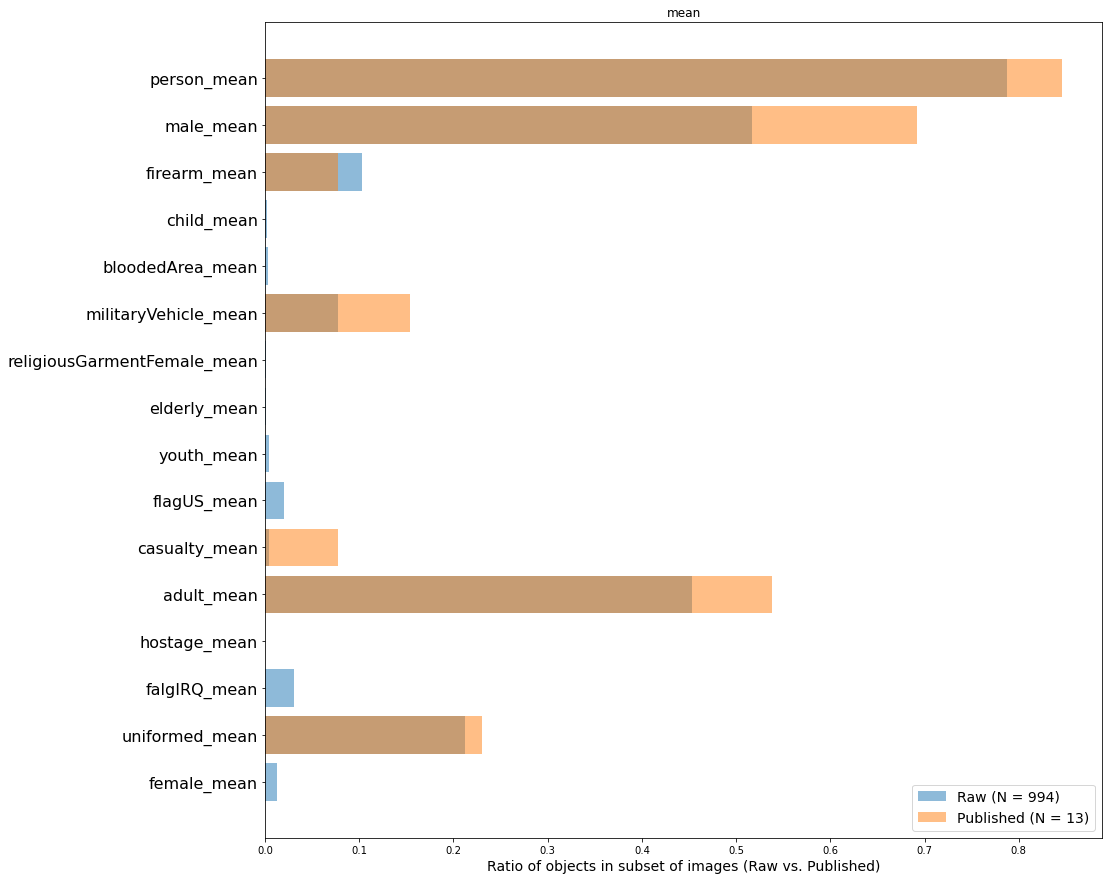

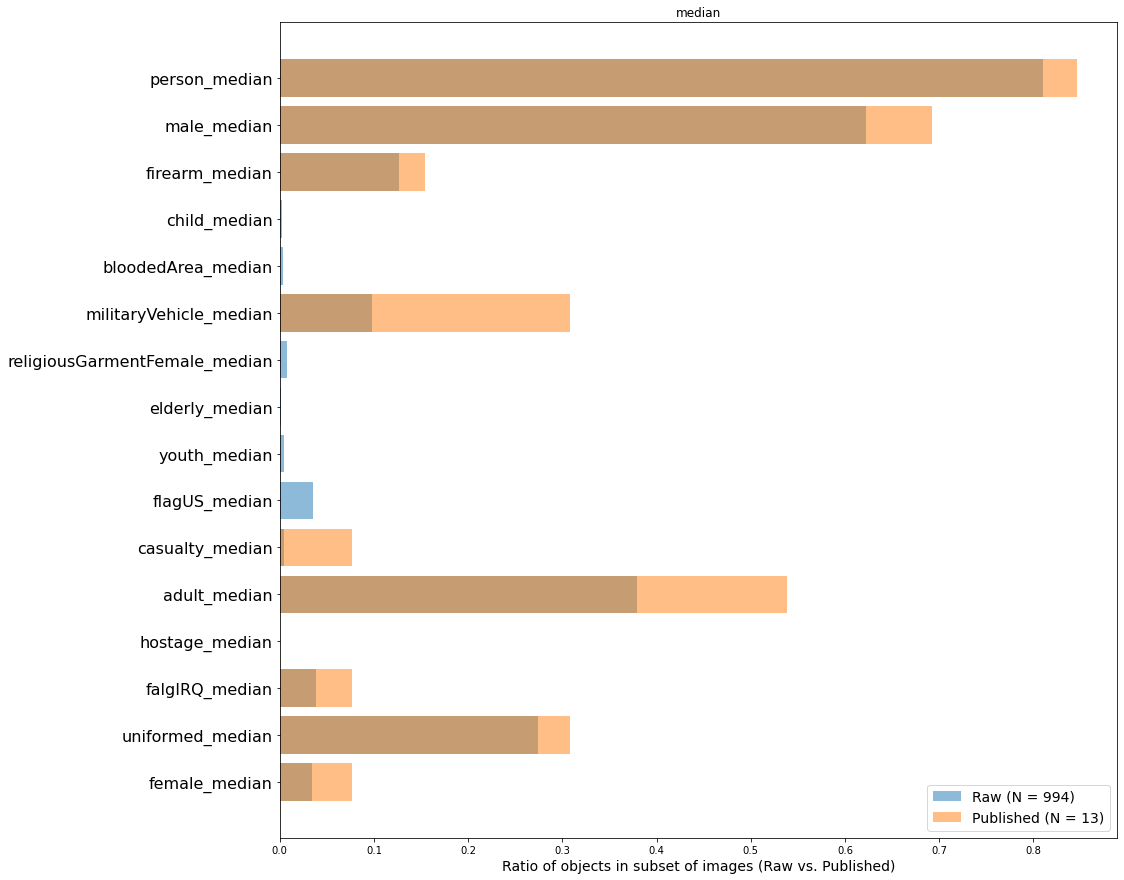

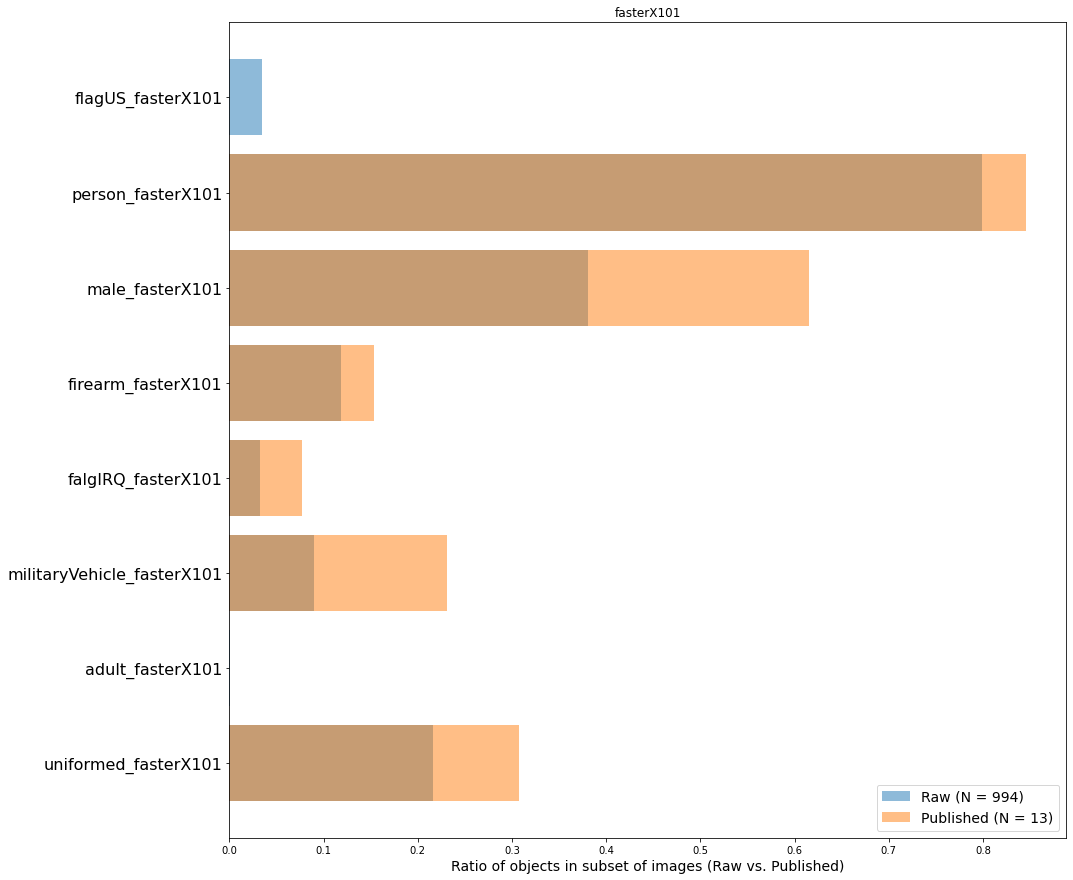

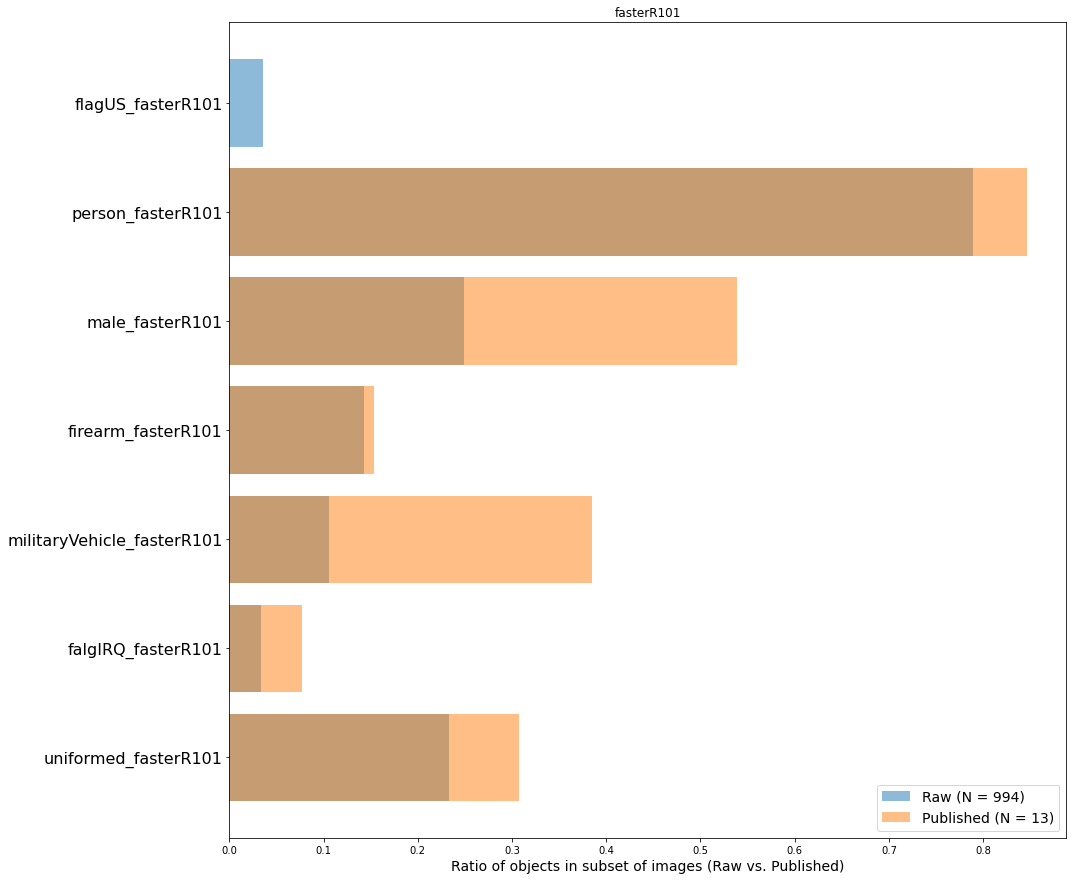

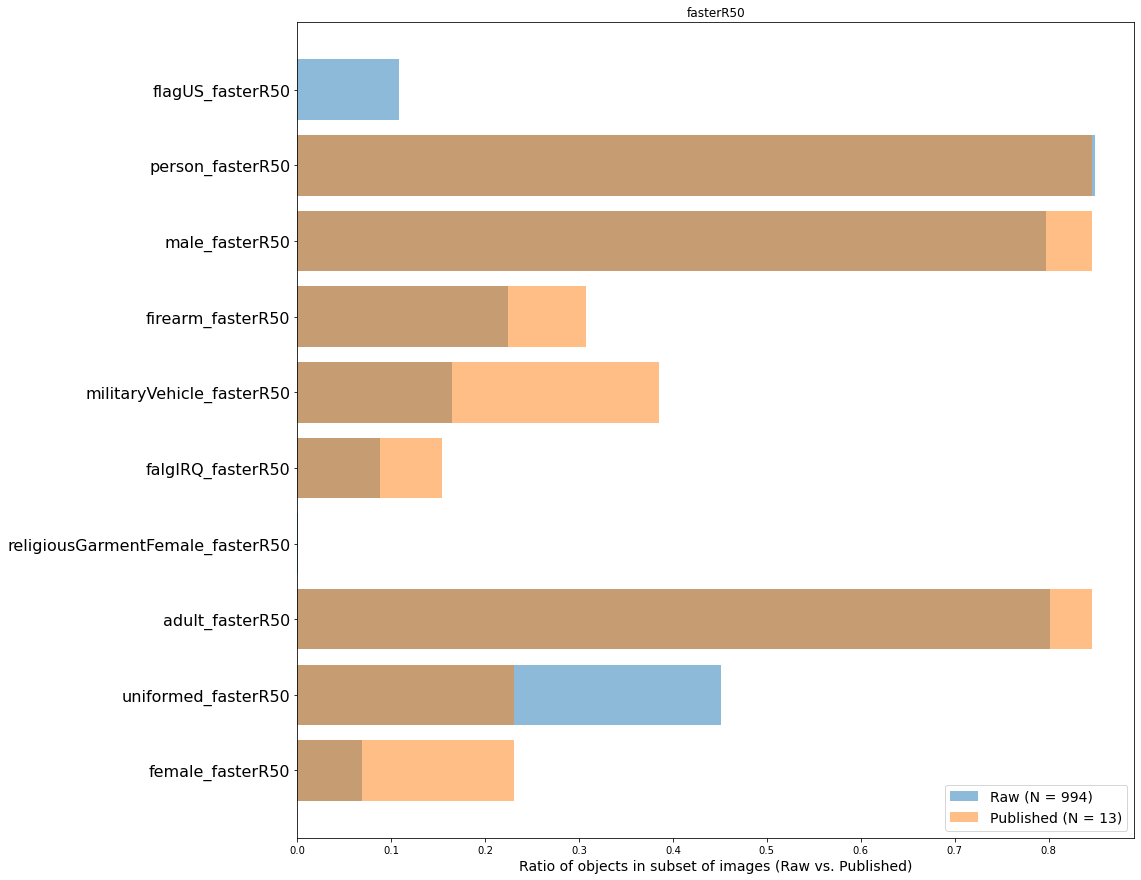

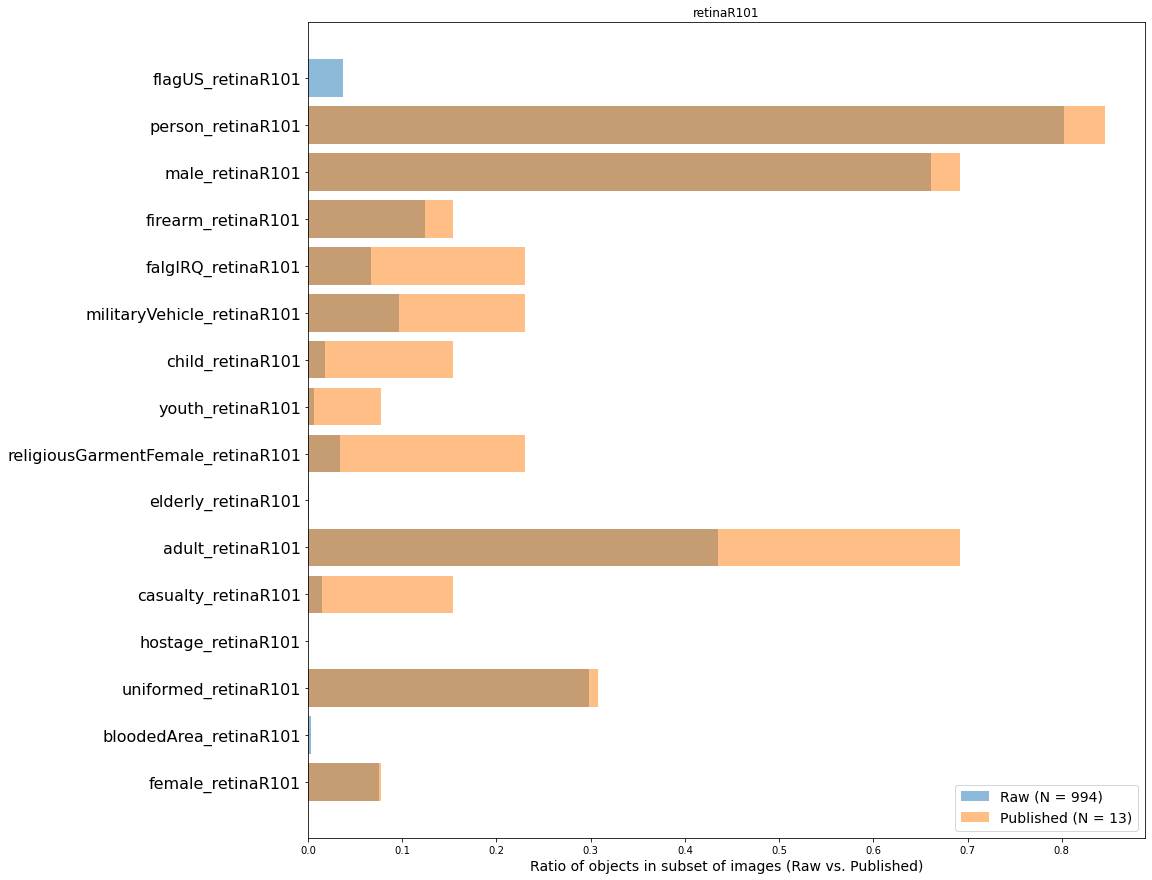

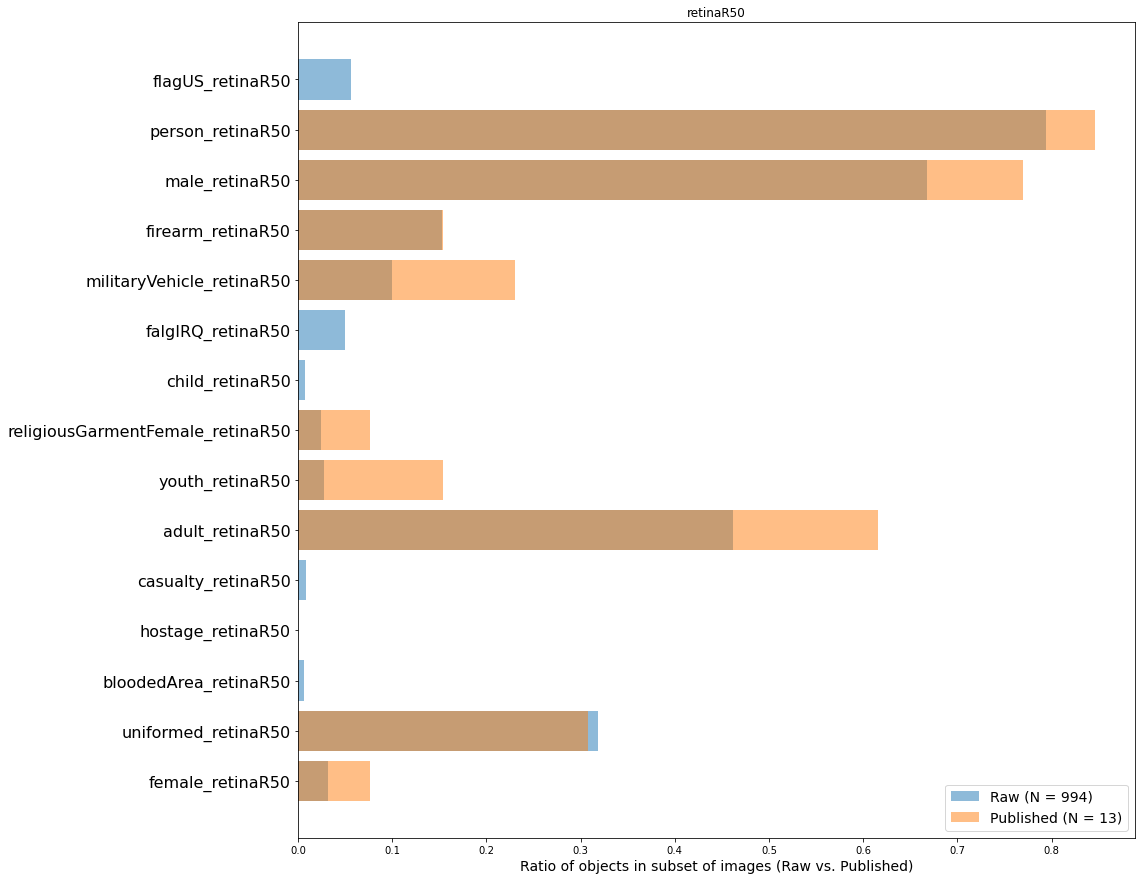

In [6]:
plot_corr(annotated_df_t30)
plot_corr(annotated_df_t30, 'train')
plot_corr(annotated_df_t30, 'test')

feature_version_list = ['annotated', 'mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50']
for i in feature_version_list:
    feature_dist_plots(annotated_df_t30, i)

## Important to do:

- After this you could implement FULL before handling the threshold issue described below..
- Also think about doing the last ratina net also - and meybe not including the fasterRCNN in rare cats (or some other rule)
    - Right now stuff gets fucked upi when the Faster's esitmate only zeores..

- Ok... the "overestimation" due to threshold is kind of irretating now.. But how to decide on that abitrary number? 
    - actually - you do have the socers savd so you maybe you could just do asomething there?
    Else, look at parameter below and run again.
    > cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # set a custom testing threshold in prediction.py....

# FULL

In [ ]:
df = annotate_df(FULL = True)


In [ ]:
df = meta_to_df(df, img_dir='/media/simon/Seagate Expansion Drive/images_spanner')

Aprox 830min or 14hours

In [ ]:
df.shape

In [ ]:
with open('spanner_full_df.pkl', 'wb') as file:
    pickle.dump(df, file)

In [ ]:
df.sample(10)

In [ ]:
df['custom2'].unique()

In [ ]:
n_raw = (df['custom2'] == 'Raw').sum()
n_sub = (df['custom2'] == 'Submitted').sum()
n_pub = (df['custom2'] == 'Published').sum()

for i in [('Raw', n_raw), ('Submitted', n_sub), ('Published', n_pub)]:
    print(f'Number of {i[0]}: {i[1]} \n')

## Test pickle:


In [ ]:

with open('spanner_full_df.pkl', 'rb') as file:
        test_pickle_df = pickle.load(file)

print(test_pickle_df.shape)
print(test_pickle_df['custom2'].unique())

tp_n_raw = (test_pickle_df['custom2'] == 'Raw').sum()
tp_n_sub = (test_pickle_df['custom2'] == 'Submitted').sum()
tp_n_pub = (test_pickle_df['custom2'] == 'Published').sum()

for i in [('Raw', tp_n_raw), ('Submitted', tp_n_sub), ('Published', tp_n_pub)]:
    print(f'Number of {i[0]}: {i[1]} \n')

In [ ]:
test_pickle_df.sample(10)

Seems good.

# Corrolation plots

In [ ]:
sub_df = df.sample(1000) # subset to plot

In [ ]:
plot_corr(sub_df)

# Raw, Sub an Pub

In [ ]:
# you of course do not have meta yet ...
feature_version_list = ['mean', 'median', 'fasterX101', 'fasterR101', 'fasterR50', 'retinaR101', 'retinaR50'] # no annotaated
for i in feature_version_list:
    feature_dist_plots(df, i) # but this is with full df.. Not the subset for scatter plot